In [4]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [5]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, Bidirectional, Reshape, Conv1D, GaussianNoise, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [6]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [7]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [8]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [9]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [10]:
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [11]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [13]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    lstm = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal'))
    lstm_1 = lstm(inputs)
    batch_norm1 = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal'))
    lstm_2_output = lstm_2(lstm_1_droput)
    batch_norm2 = BatchNormalization()(lstm_2_output)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model


## Discriminator

In [14]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model


# Training

In [15]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [16]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # Threshhold
#         if(cur_gen_loss > 0.8):
#                 break;

    return history, history_val

## Visualization

In [17]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [18]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [19]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [20]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [21]:
stock_code = "AAPL"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    0.910714    0.912946    0.845982    0.872768    0.742829   
6    2000-01-11    0.856585    0.887277    0.808036    0.828125    0.704832   
7    2000-01-12    0.848214    0.852679    0.772321    0.778460    0.662562   
8    2000-01-13    0.843610    0.881696    0.825893    0.863839    0.735229   
9    2000-01-14    0.892857    0.912946    0.887277    0.896763    0.763252   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  132.160004  132.429993  130.779999  130.960007  129.209274   
5279 2020-12-24  131.320007  133.460007  131.100006  131.970001  130.205780   
5280 2020-12-28  133.990005  137.339996  133.509995  136.690002  134.862671   
5281 2020-12-29  138.050003  138.789993  134.339996  134.869995  133.066971   
5282 2020-12-30  135.580002  135.990005  133.399994  133.720001  131.932388   

          Volume          Ma  
5      505064000    0.915960  
6      441548800    0.890625  
7      976068800    0.873214  
8     1032684800    0.843192  
9      390376000    0.846317  
...          ...         ...  
5278    88223700  128.656000  
5279    54930100  129.286002  
5280   124486200  129.940002  
5281   121047300  131.946002  
5282    96452100  133.274002  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_3 (Dropout)         (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.8542077541351318 sec Generator Loss: 0.7978544235229492,  Discriminator_loss: 1.3449712991714478
Time for epoch 53 is 0.8504464626312256 sec Generator Loss: 0.7956141233444214,  Discriminator_loss: 1.3469514846801758
Time for epoch 54 is 0.8525278568267822 sec Generator Loss: 0.7893229722976685,  Discriminator_loss: 1.35403573513031
Time for epoch 55 is 0.8177840709686279 sec Generator Loss: 0.7988231778144836,  Discriminator_loss: 1.3526806831359863
Time for epoch 56 is 0.8270494937896729 sec Generator Loss: 0.8016183376312256,  Discriminator_loss: 1.3480751514434814
Time for epoch 57 is 0.8231256008148193 sec Generator Loss: 0.7968243360519409,  Discriminator_loss: 1.347718358039856
Time for epoch 58 is 0.8680224418640137 sec Generator Loss: 0.8068239092826843,  Discriminator_loss: 1.3527889251708984
Time for epoch 59 is 0.8212831020355225 sec Generator Loss: 0.8030495643615723,  Discriminator_loss: 1.3706390857696533
Time for epoch 60 is 0.8490779399871826 sec

Time for epoch 121 is 0.8288183212280273 sec Generator Loss: 0.774767279624939,  Discriminator_loss: 1.360418677330017
Time for epoch 122 is 0.8350939750671387 sec Generator Loss: 0.7759766578674316,  Discriminator_loss: 1.3651686906814575
Time for epoch 123 is 0.8197522163391113 sec Generator Loss: 0.7753354907035828,  Discriminator_loss: 1.356749176979065
Time for epoch 124 is 0.8196377754211426 sec Generator Loss: 0.7765681743621826,  Discriminator_loss: 1.3584418296813965
Time for epoch 125 is 0.8211767673492432 sec Generator Loss: 0.7733035683631897,  Discriminator_loss: 1.3563306331634521
Time for epoch 126 is 0.8206677436828613 sec Generator Loss: 0.7789254784584045,  Discriminator_loss: 1.3569713830947876
Time for epoch 127 is 0.8621361255645752 sec Generator Loss: 0.779443621635437,  Discriminator_loss: 1.36027193069458
Time for epoch 128 is 0.8151764869689941 sec Generator Loss: 0.7710282802581787,  Discriminator_loss: 1.3628343343734741
Time for epoch 129 is 0.81474518775939

Time for epoch 190 is 0.82350754737854 sec Generator Loss: 0.7694761753082275,  Discriminator_loss: 1.363953948020935
Time for epoch 191 is 0.8553774356842041 sec Generator Loss: 0.7670097947120667,  Discriminator_loss: 1.3670237064361572
Time for epoch 192 is 0.9037830829620361 sec Generator Loss: 0.7654773592948914,  Discriminator_loss: 1.3651567697525024
Time for epoch 193 is 0.9010834693908691 sec Generator Loss: 0.769231379032135,  Discriminator_loss: 1.3625036478042603
Time for epoch 194 is 0.8898756504058838 sec Generator Loss: 0.7750462293624878,  Discriminator_loss: 1.3624094724655151
Time for epoch 195 is 0.8374223709106445 sec Generator Loss: 0.7738837599754333,  Discriminator_loss: 1.359902262687683
Time for epoch 196 is 0.8425693511962891 sec Generator Loss: 0.7704088091850281,  Discriminator_loss: 1.3655025959014893
Time for epoch 197 is 0.8386862277984619 sec Generator Loss: 0.7636008858680725,  Discriminator_loss: 1.3661425113677979
Time for epoch 198 is 0.8273959159851

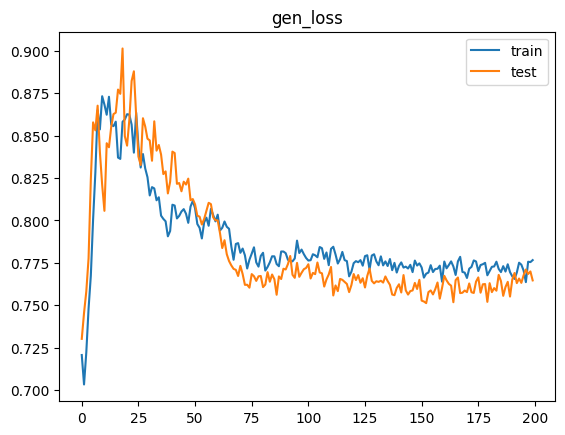

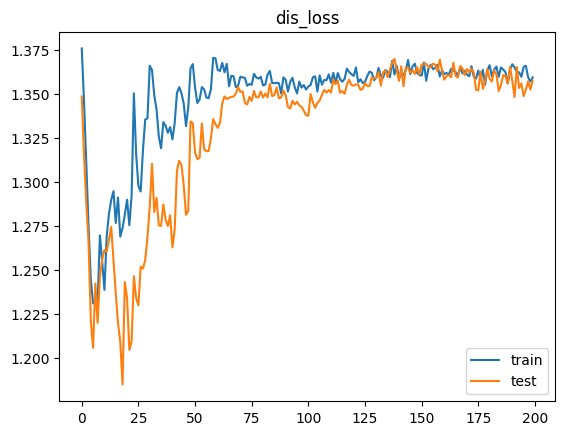

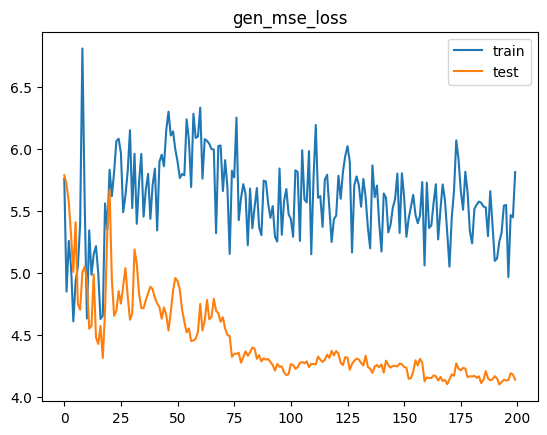

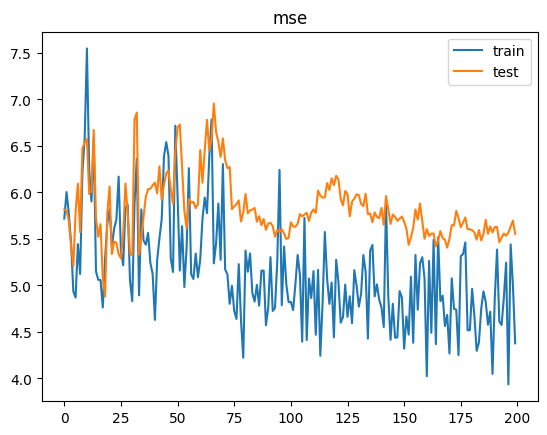

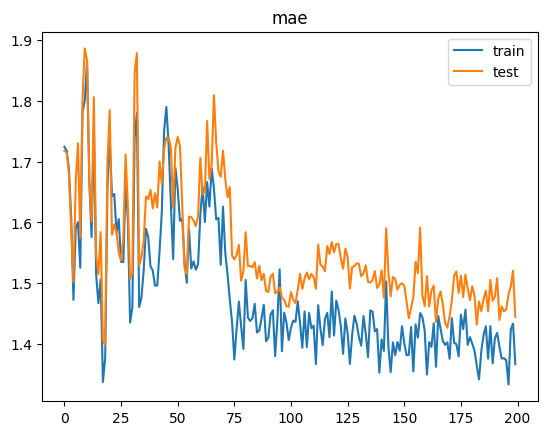

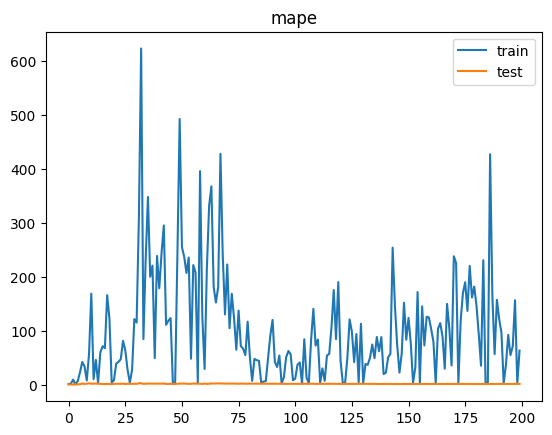

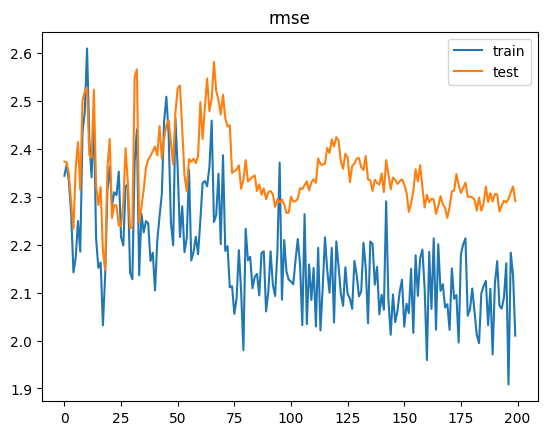

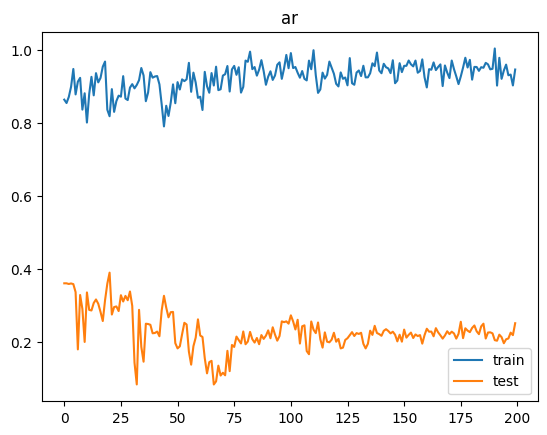

2/2 [==============================] - 1s 4ms/step


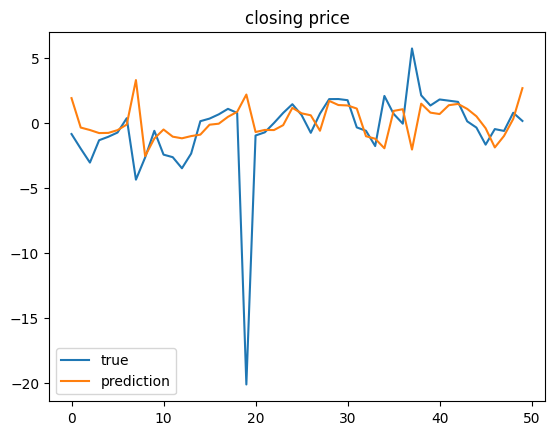

[MSE Baseline] train: 4.447260966761541  test: 4.6881765064049805
Delta time with epochs = 200: 0:03:03.844186


In [23]:
# epochs = 200
# start_time = datetime.datetime.now()
# df = add_Ma(df)
# data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

# generator = make_generator_model(n_sequence, n_features)
# discriminator=make_discriminator_model(n_features)

# learning_rate=1e-4
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

# @tf.function
# def train_step(sequences, sequences_end):
#   return train_step_def(sequences, sequences_end)

# @tf.function
# def test_step(sequences, sequences_end):
#   return test_step_def(sequences, sequences_end)

# checkpoint_dir = './training_checkpoints'+stock_code
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

# history, history_val = train(data_gen_train, data_gen_test, epochs)

# plot_history(history, history_val)
# plot_frame(*data_gen_test[0], generator)

# print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
# now = datetime.datetime.now()
# delta = now - start_time
# print("Delta time with epochs = {0}:".format(epochs), delta)
# generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))
# discriminator.save("ffnn.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.83139967918396 sec Generator Loss: 0.8111183643341064,  Discriminator_loss: 1.3461852073669434
Time for epoch 53 is 0.8535559177398682 sec Generator Loss: 0.799030065536499,  Discriminator_loss: 1.364968180656433
Time for epoch 54 is 0.8674533367156982 sec Generator Loss: 0.8124359846115112,  Discriminator_loss: 1.3599592447280884
Time for epoch 55 is 0.8465585708618164 sec Generator Loss: 0.8116954565048218,  Discriminator_loss: 1.3609979152679443
Time for epoch 56 is 0.8406896591186523 sec Generator Loss: 0.8022058010101318,  Discriminator_loss: 1.36006498336792
Time for epoch 57 is 0.8625035285949707 sec Generator Loss: 0.7969962954521179,  Discriminator_loss: 1.3642693758010864
Time for epoch 58 is 0.8593742847442627 sec Generator Loss: 0.7900987863540649,  Discriminator_loss: 1.3694509267807007
Time for epoch 59 is 0.8255693912506104 sec Generator Loss: 0.7946967482566833,  Discriminator_loss: 1.364356279373169
Time for epoch 60 is 0.8358926773071289 sec Gen

Time for epoch 121 is 0.8050103187561035 sec Generator Loss: 0.783333420753479,  Discriminator_loss: 1.3546602725982666
Time for epoch 122 is 0.817368745803833 sec Generator Loss: 0.7874531745910645,  Discriminator_loss: 1.3483655452728271
Time for epoch 123 is 0.8190028667449951 sec Generator Loss: 0.7864776849746704,  Discriminator_loss: 1.3541806936264038
Time for epoch 124 is 0.8177540302276611 sec Generator Loss: 0.7866700887680054,  Discriminator_loss: 1.3472665548324585
Time for epoch 125 is 0.8039488792419434 sec Generator Loss: 0.7904144525527954,  Discriminator_loss: 1.3483895063400269
Time for epoch 126 is 0.8094534873962402 sec Generator Loss: 0.7793551683425903,  Discriminator_loss: 1.358515739440918
Time for epoch 127 is 0.8085260391235352 sec Generator Loss: 0.7789615988731384,  Discriminator_loss: 1.3515053987503052
Time for epoch 128 is 0.808035135269165 sec Generator Loss: 0.7836133241653442,  Discriminator_loss: 1.3466380834579468
Time for epoch 129 is 0.804240465164

Time for epoch 190 is 0.8091132640838623 sec Generator Loss: 0.7801430225372314,  Discriminator_loss: 1.355391263961792
Time for epoch 191 is 0.8145408630371094 sec Generator Loss: 0.7879326939582825,  Discriminator_loss: 1.3542946577072144
Time for epoch 192 is 0.8111488819122314 sec Generator Loss: 0.7862775325775146,  Discriminator_loss: 1.353978157043457
Time for epoch 193 is 0.832819938659668 sec Generator Loss: 0.7878419160842896,  Discriminator_loss: 1.3482083082199097
Time for epoch 194 is 0.8111529350280762 sec Generator Loss: 0.783147931098938,  Discriminator_loss: 1.3565675020217896
Time for epoch 195 is 0.8078427314758301 sec Generator Loss: 0.7785858511924744,  Discriminator_loss: 1.3515781164169312
Time for epoch 196 is 0.7977516651153564 sec Generator Loss: 0.7832691669464111,  Discriminator_loss: 1.3533209562301636
Time for epoch 197 is 0.882554292678833 sec Generator Loss: 0.7850788831710815,  Discriminator_loss: 1.351311445236206
Time for epoch 198 is 0.82767391204833

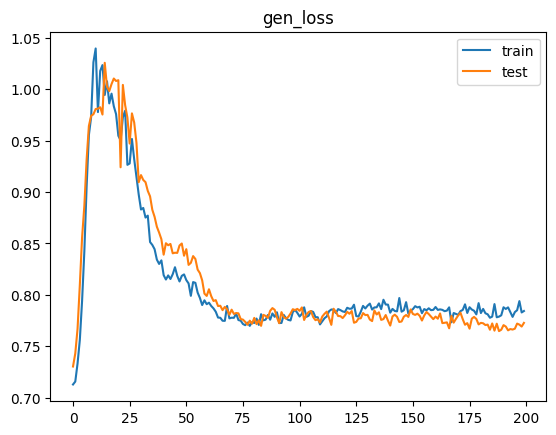

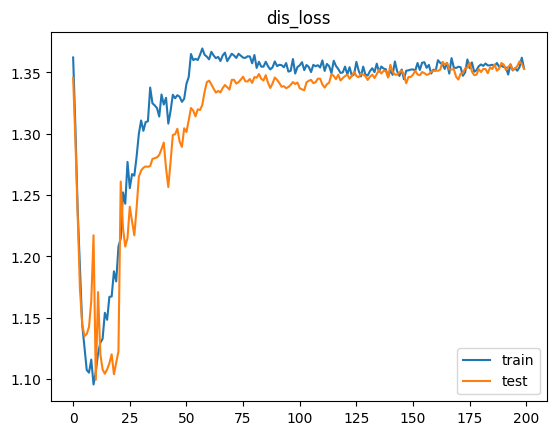

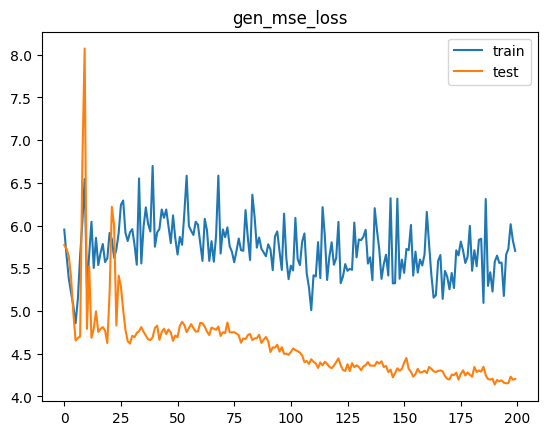

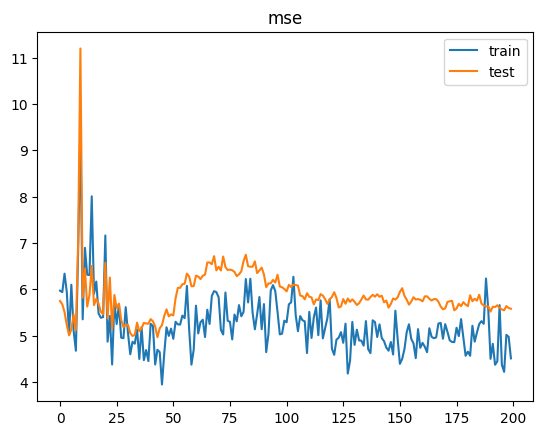

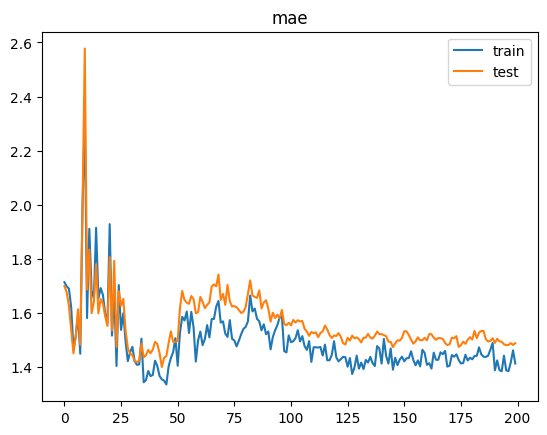

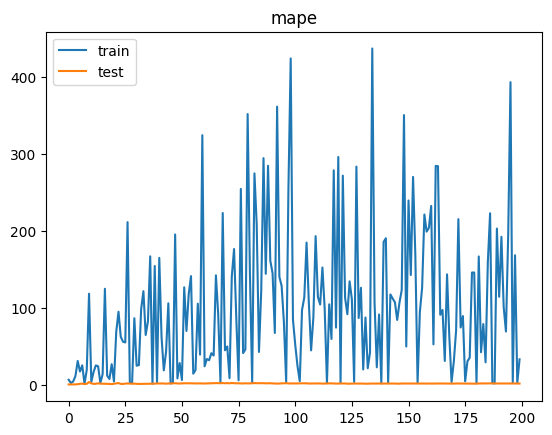

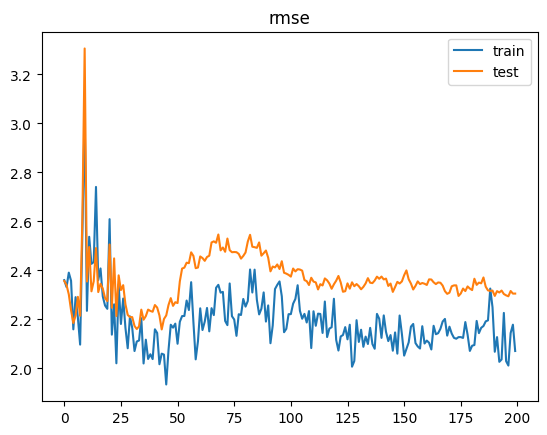

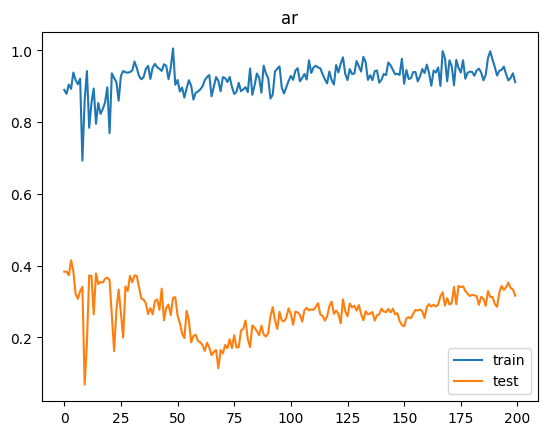

2/2 [==============================] - 0s 3ms/step


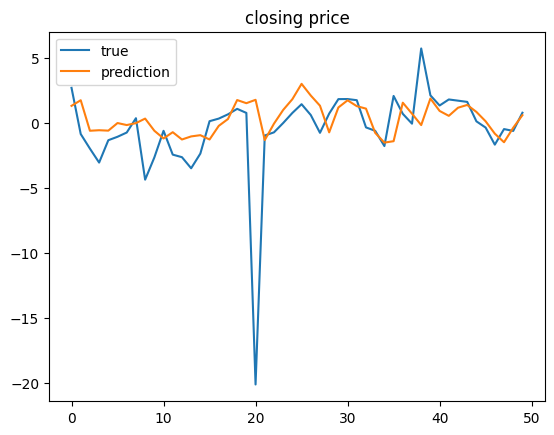

[MSE Baseline] train: 3.5273914039277376  test: 4.679867713895856
Delta time with epochs = 200: 0:02:57.254020
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
              

Time for epoch 51 is 1.018014907836914 sec Generator Loss: 0.7843046188354492,  Discriminator_loss: 1.3699079751968384
Time for epoch 52 is 0.9287545680999756 sec Generator Loss: 0.7851330041885376,  Discriminator_loss: 1.3681960105895996
Time for epoch 53 is 0.8617038726806641 sec Generator Loss: 0.7849222421646118,  Discriminator_loss: 1.366127371788025
Time for epoch 54 is 0.8284451961517334 sec Generator Loss: 0.7765710353851318,  Discriminator_loss: 1.3640168905258179
Time for epoch 55 is 0.8105499744415283 sec Generator Loss: 0.7770273089408875,  Discriminator_loss: 1.3666081428527832
Time for epoch 56 is 0.8103439807891846 sec Generator Loss: 0.7792512774467468,  Discriminator_loss: 1.3700413703918457
Time for epoch 57 is 0.7984175682067871 sec Generator Loss: 0.7848222851753235,  Discriminator_loss: 1.3776882886886597
Time for epoch 58 is 0.8294649124145508 sec Generator Loss: 0.7870503067970276,  Discriminator_loss: 1.37937593460083
Time for epoch 59 is 0.8299753665924072 sec 

Time for epoch 120 is 0.8097238540649414 sec Generator Loss: 0.771697998046875,  Discriminator_loss: 1.361742615699768
Time for epoch 121 is 0.8018543720245361 sec Generator Loss: 0.7646976113319397,  Discriminator_loss: 1.3665040731430054
Time for epoch 122 is 0.8010468482971191 sec Generator Loss: 0.7706471085548401,  Discriminator_loss: 1.3628814220428467
Time for epoch 123 is 0.7955358028411865 sec Generator Loss: 0.7715883255004883,  Discriminator_loss: 1.361741304397583
Time for epoch 124 is 0.8080868721008301 sec Generator Loss: 0.7700001001358032,  Discriminator_loss: 1.362226963043213
Time for epoch 125 is 0.8314833641052246 sec Generator Loss: 0.7646757364273071,  Discriminator_loss: 1.3730626106262207
Time for epoch 126 is 0.90110182762146 sec Generator Loss: 0.7699018716812134,  Discriminator_loss: 1.3693915605545044
Time for epoch 127 is 0.8629379272460938 sec Generator Loss: 0.7721350789070129,  Discriminator_loss: 1.3707398176193237
Time for epoch 128 is 0.84996008872985

Time for epoch 188 is 0.80464768409729 sec Generator Loss: 0.7701627612113953,  Discriminator_loss: 1.367781162261963
Time for epoch 189 is 0.7926473617553711 sec Generator Loss: 0.763068675994873,  Discriminator_loss: 1.3713399171829224
Time for epoch 190 is 0.7963900566101074 sec Generator Loss: 0.7613263130187988,  Discriminator_loss: 1.3701001405715942
Time for epoch 191 is 0.7918262481689453 sec Generator Loss: 0.7629454135894775,  Discriminator_loss: 1.3667943477630615
Time for epoch 192 is 0.7932536602020264 sec Generator Loss: 0.7639901041984558,  Discriminator_loss: 1.3661001920700073
Time for epoch 193 is 0.820690393447876 sec Generator Loss: 0.765555739402771,  Discriminator_loss: 1.3635891675949097
Time for epoch 194 is 1.0560569763183594 sec Generator Loss: 0.7652186155319214,  Discriminator_loss: 1.3641363382339478
Time for epoch 195 is 0.8399240970611572 sec Generator Loss: 0.7669876217842102,  Discriminator_loss: 1.3636165857315063
Time for epoch 196 is 0.84998488426208

Time for epoch 257 is 1.0430514812469482 sec Generator Loss: 0.7719656825065613,  Discriminator_loss: 1.3648574352264404
Time for epoch 258 is 0.9926595687866211 sec Generator Loss: 0.763949453830719,  Discriminator_loss: 1.364450216293335
Time for epoch 259 is 0.965874433517456 sec Generator Loss: 0.7665498852729797,  Discriminator_loss: 1.3662298917770386
Time for epoch 260 is 0.9861621856689453 sec Generator Loss: 0.7704017758369446,  Discriminator_loss: 1.3633465766906738
Time for epoch 261 is 1.0076878070831299 sec Generator Loss: 0.7676951885223389,  Discriminator_loss: 1.3659751415252686
Time for epoch 262 is 0.9689397811889648 sec Generator Loss: 0.7728917598724365,  Discriminator_loss: 1.3619697093963623
Time for epoch 263 is 0.958812952041626 sec Generator Loss: 0.7694776058197021,  Discriminator_loss: 1.3627076148986816
Time for epoch 264 is 0.9546544551849365 sec Generator Loss: 0.7685569524765015,  Discriminator_loss: 1.3651020526885986
Time for epoch 265 is 0.979201316833

Time for epoch 325 is 0.964275598526001 sec Generator Loss: 0.7785268425941467,  Discriminator_loss: 1.3565205335617065
Time for epoch 326 is 0.9087963104248047 sec Generator Loss: 0.7752732634544373,  Discriminator_loss: 1.3591808080673218
Time for epoch 327 is 0.98042893409729 sec Generator Loss: 0.7796223759651184,  Discriminator_loss: 1.3569307327270508
Time for epoch 328 is 0.9067168235778809 sec Generator Loss: 0.783226728439331,  Discriminator_loss: 1.3561426401138306
Time for epoch 329 is 0.8868725299835205 sec Generator Loss: 0.7786251902580261,  Discriminator_loss: 1.357562780380249
Time for epoch 330 is 0.8928735256195068 sec Generator Loss: 0.7765045166015625,  Discriminator_loss: 1.3573554754257202
Time for epoch 331 is 0.9527661800384521 sec Generator Loss: 0.7767890691757202,  Discriminator_loss: 1.3554329872131348
Time for epoch 332 is 0.9860215187072754 sec Generator Loss: 0.7750932574272156,  Discriminator_loss: 1.3556395769119263
Time for epoch 333 is 0.9294452667236

Time for epoch 394 is 0.9934060573577881 sec Generator Loss: 0.7806081175804138,  Discriminator_loss: 1.351223349571228
Time for epoch 395 is 0.9493727684020996 sec Generator Loss: 0.7855623960494995,  Discriminator_loss: 1.3470741510391235
Time for epoch 396 is 0.99259352684021 sec Generator Loss: 0.7908231616020203,  Discriminator_loss: 1.3467949628829956
Time for epoch 397 is 1.051565170288086 sec Generator Loss: 0.7784926295280457,  Discriminator_loss: 1.3525007963180542
Time for epoch 398 is 0.9926950931549072 sec Generator Loss: 0.7951647639274597,  Discriminator_loss: 1.3444503545761108
Time for epoch 399 is 1.001523494720459 sec Generator Loss: 0.7872715592384338,  Discriminator_loss: 1.3492053747177124
Time for epoch 400 is 0.9131138324737549 sec Generator Loss: 0.7902462482452393,  Discriminator_loss: 1.3474373817443848
Time for epoch 401 is 0.9062228202819824 sec Generator Loss: 0.7884610295295715,  Discriminator_loss: 1.348401665687561
Time for epoch 402 is 0.90828418731689

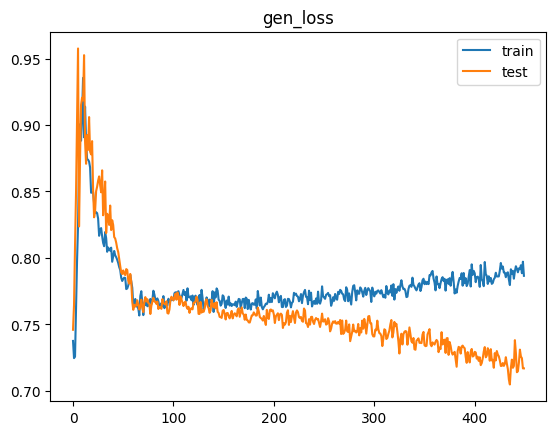

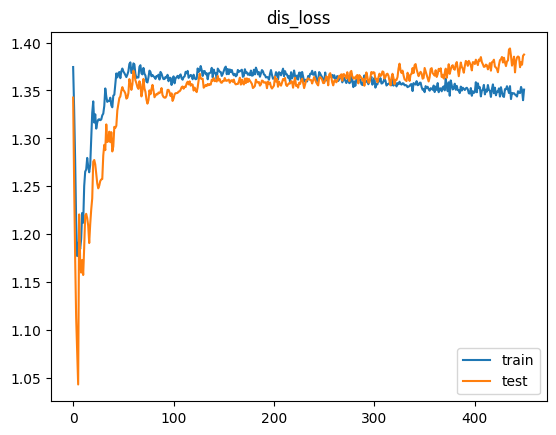

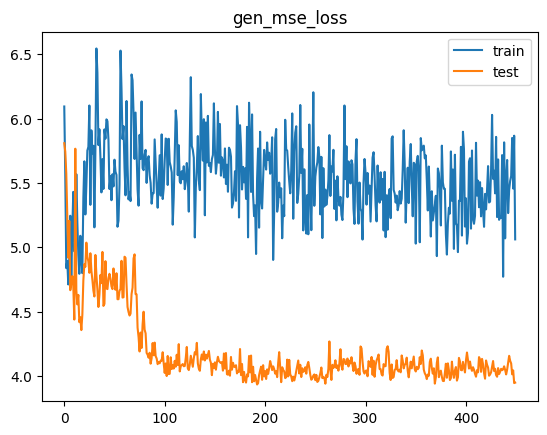

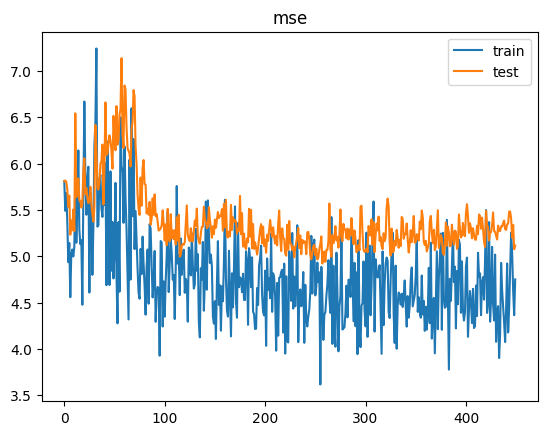

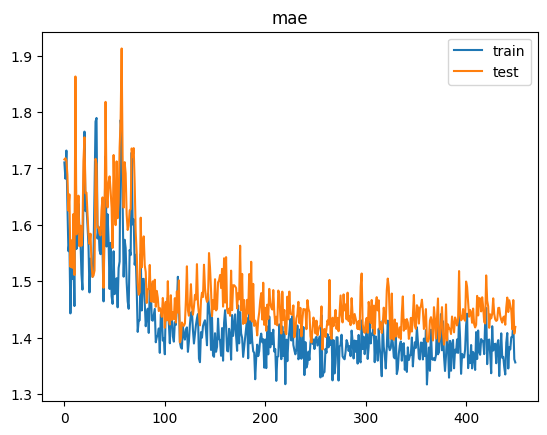

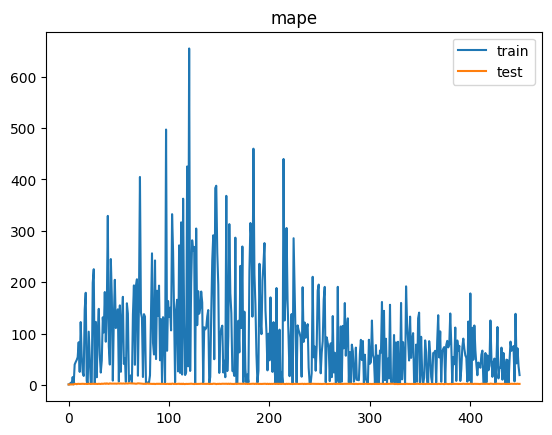

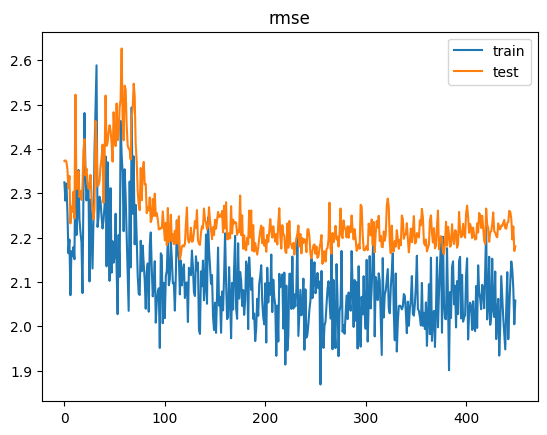

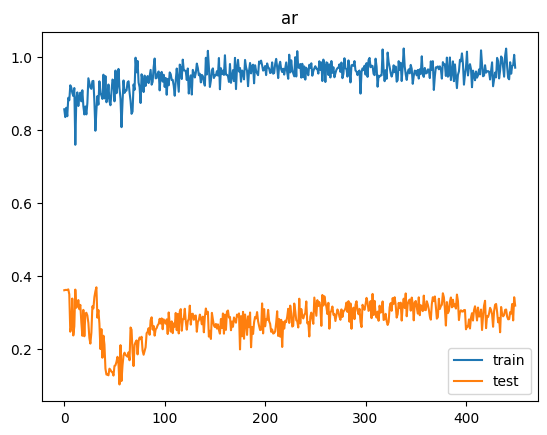

2/2 [==============================] - 0s 3ms/step


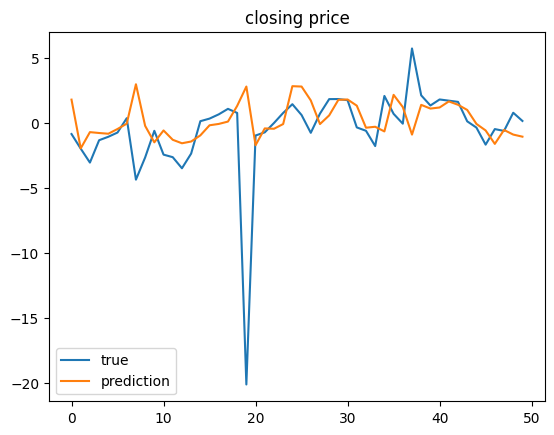

[MSE Baseline] train: 5.0611886519915625  test: 4.6881765064049805
Delta time with epochs = 450: 0:06:56.125592
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 20)             0         
             

Time for epoch 51 is 1.0501816272735596 sec Generator Loss: 0.7935512661933899,  Discriminator_loss: 1.3430290222167969
Time for epoch 52 is 1.1133713722229004 sec Generator Loss: 0.7968975305557251,  Discriminator_loss: 1.343648910522461
Time for epoch 53 is 1.039353847503662 sec Generator Loss: 0.8011900782585144,  Discriminator_loss: 1.3531004190444946
Time for epoch 54 is 1.0134575366973877 sec Generator Loss: 0.796628475189209,  Discriminator_loss: 1.351595163345337
Time for epoch 55 is 1.0181634426116943 sec Generator Loss: 0.797946572303772,  Discriminator_loss: 1.3654680252075195
Time for epoch 56 is 0.9891715049743652 sec Generator Loss: 0.7786833047866821,  Discriminator_loss: 1.37903892993927
Time for epoch 57 is 0.9541137218475342 sec Generator Loss: 0.7746744751930237,  Discriminator_loss: 1.393910527229309
Time for epoch 58 is 0.941216230392456 sec Generator Loss: 0.7826991677284241,  Discriminator_loss: 1.3838192224502563
Time for epoch 59 is 0.9839539527893066 sec Gener

Time for epoch 120 is 0.9931681156158447 sec Generator Loss: 0.7734455466270447,  Discriminator_loss: 1.3611048460006714
Time for epoch 121 is 0.998255729675293 sec Generator Loss: 0.7760319113731384,  Discriminator_loss: 1.3563096523284912
Time for epoch 122 is 1.0348920822143555 sec Generator Loss: 0.7804893851280212,  Discriminator_loss: 1.3600658178329468
Time for epoch 123 is 0.9719266891479492 sec Generator Loss: 0.777725338935852,  Discriminator_loss: 1.3588210344314575
Time for epoch 124 is 1.010483741760254 sec Generator Loss: 0.7794358730316162,  Discriminator_loss: 1.3563481569290161
Time for epoch 125 is 0.9985573291778564 sec Generator Loss: 0.781930685043335,  Discriminator_loss: 1.3641422986984253
Time for epoch 126 is 1.0035431385040283 sec Generator Loss: 0.776578962802887,  Discriminator_loss: 1.3652126789093018
Time for epoch 127 is 1.0261075496673584 sec Generator Loss: 0.7726736664772034,  Discriminator_loss: 1.3623335361480713
Time for epoch 128 is 0.9550375938415

Time for epoch 189 is 0.9363641738891602 sec Generator Loss: 0.7821938991546631,  Discriminator_loss: 1.3583166599273682
Time for epoch 190 is 0.938439130783081 sec Generator Loss: 0.7768846154212952,  Discriminator_loss: 1.3592644929885864
Time for epoch 191 is 0.9520413875579834 sec Generator Loss: 0.7748895287513733,  Discriminator_loss: 1.3655495643615723
Time for epoch 192 is 0.9480612277984619 sec Generator Loss: 0.7812595367431641,  Discriminator_loss: 1.3612875938415527
Time for epoch 193 is 0.9320061206817627 sec Generator Loss: 0.7853049039840698,  Discriminator_loss: 1.3560676574707031
Time for epoch 194 is 1.004807710647583 sec Generator Loss: 0.7725552320480347,  Discriminator_loss: 1.3566474914550781
Time for epoch 195 is 0.9993202686309814 sec Generator Loss: 0.7791714072227478,  Discriminator_loss: 1.3539626598358154
Time for epoch 196 is 0.9262268543243408 sec Generator Loss: 0.784673273563385,  Discriminator_loss: 1.3571345806121826
Time for epoch 197 is 0.96025300025

Time for epoch 257 is 1.0566790103912354 sec Generator Loss: 0.7865375876426697,  Discriminator_loss: 1.3518315553665161
Time for epoch 258 is 1.077092170715332 sec Generator Loss: 0.7862755656242371,  Discriminator_loss: 1.3517976999282837
Time for epoch 259 is 1.001269817352295 sec Generator Loss: 0.7842478156089783,  Discriminator_loss: 1.3539907932281494
Time for epoch 260 is 1.0749468803405762 sec Generator Loss: 0.7897128462791443,  Discriminator_loss: 1.3487975597381592
Time for epoch 261 is 1.07661771774292 sec Generator Loss: 0.7893275618553162,  Discriminator_loss: 1.3545671701431274
Time for epoch 262 is 1.0967481136322021 sec Generator Loss: 0.7889648675918579,  Discriminator_loss: 1.3446526527404785
Time for epoch 263 is 1.0406527519226074 sec Generator Loss: 0.7874624133110046,  Discriminator_loss: 1.357946515083313
Time for epoch 264 is 1.0919015407562256 sec Generator Loss: 0.7812816500663757,  Discriminator_loss: 1.3531663417816162
Time for epoch 265 is 1.0375423431396

Time for epoch 326 is 0.9041914939880371 sec Generator Loss: 0.7971063852310181,  Discriminator_loss: 1.3501590490341187
Time for epoch 327 is 0.9059016704559326 sec Generator Loss: 0.7899566888809204,  Discriminator_loss: 1.34595787525177
Time for epoch 328 is 0.9159598350524902 sec Generator Loss: 0.798784613609314,  Discriminator_loss: 1.3391425609588623
Time for epoch 329 is 0.9529635906219482 sec Generator Loss: 0.7948746681213379,  Discriminator_loss: 1.34015953540802
Time for epoch 330 is 1.0372071266174316 sec Generator Loss: 0.7931526303291321,  Discriminator_loss: 1.3438706398010254
Time for epoch 331 is 0.9832186698913574 sec Generator Loss: 0.7894322872161865,  Discriminator_loss: 1.3501508235931396
Time for epoch 332 is 0.910834550857544 sec Generator Loss: 0.7909045219421387,  Discriminator_loss: 1.343996524810791
Time for epoch 333 is 0.9142546653747559 sec Generator Loss: 0.8002278804779053,  Discriminator_loss: 1.3463431596755981
Time for epoch 334 is 0.923640489578247

Time for epoch 395 is 1.061495065689087 sec Generator Loss: 0.8027684092521667,  Discriminator_loss: 1.3407257795333862
Time for epoch 396 is 1.084076166152954 sec Generator Loss: 0.7920641303062439,  Discriminator_loss: 1.346097469329834
Time for epoch 397 is 1.0749831199645996 sec Generator Loss: 0.7950177192687988,  Discriminator_loss: 1.343596339225769
Time for epoch 398 is 1.0664875507354736 sec Generator Loss: 0.794401228427887,  Discriminator_loss: 1.3430066108703613
Time for epoch 399 is 0.935746431350708 sec Generator Loss: 0.7943806052207947,  Discriminator_loss: 1.3432344198226929
Time for epoch 400 is 0.8965647220611572 sec Generator Loss: 0.8009521961212158,  Discriminator_loss: 1.3382142782211304
Time for epoch 401 is 0.9292113780975342 sec Generator Loss: 0.8043532371520996,  Discriminator_loss: 1.3474386930465698
Time for epoch 402 is 1.0051190853118896 sec Generator Loss: 0.8000391721725464,  Discriminator_loss: 1.3427242040634155
Time for epoch 403 is 1.04668712615966

Time for epoch 464 is 1.1479430198669434 sec Generator Loss: 0.8005437850952148,  Discriminator_loss: 1.337390422821045
Time for epoch 465 is 1.100853681564331 sec Generator Loss: 0.8026666641235352,  Discriminator_loss: 1.3354698419570923
Time for epoch 466 is 1.029655933380127 sec Generator Loss: 0.8035078644752502,  Discriminator_loss: 1.3391804695129395
Time for epoch 467 is 0.9584200382232666 sec Generator Loss: 0.8058398365974426,  Discriminator_loss: 1.3388216495513916
Time for epoch 468 is 0.9621536731719971 sec Generator Loss: 0.8071029782295227,  Discriminator_loss: 1.3386098146438599
Time for epoch 469 is 0.95855712890625 sec Generator Loss: 0.8106576800346375,  Discriminator_loss: 1.3386921882629395
Time for epoch 470 is 0.964169979095459 sec Generator Loss: 0.8000627756118774,  Discriminator_loss: 1.3459031581878662
Time for epoch 471 is 0.9711482524871826 sec Generator Loss: 0.8025014400482178,  Discriminator_loss: 1.3395508527755737
Time for epoch 472 is 0.95899558067321

Time for epoch 533 is 0.9203343391418457 sec Generator Loss: 0.8110266923904419,  Discriminator_loss: 1.3309881687164307
Time for epoch 534 is 0.9361991882324219 sec Generator Loss: 0.8026182651519775,  Discriminator_loss: 1.3416212797164917
Time for epoch 535 is 0.917189359664917 sec Generator Loss: 0.8016200065612793,  Discriminator_loss: 1.3402514457702637
Time for epoch 536 is 0.9655113220214844 sec Generator Loss: 0.8055605292320251,  Discriminator_loss: 1.3389383554458618
Time for epoch 537 is 0.9806921482086182 sec Generator Loss: 0.8086795210838318,  Discriminator_loss: 1.3405333757400513
Time for epoch 538 is 0.938042163848877 sec Generator Loss: 0.8030783534049988,  Discriminator_loss: 1.3433486223220825
Time for epoch 539 is 1.081664800643921 sec Generator Loss: 0.7944607734680176,  Discriminator_loss: 1.3431340456008911
Time for epoch 540 is 1.1415886878967285 sec Generator Loss: 0.8053817749023438,  Discriminator_loss: 1.3432952165603638
Time for epoch 541 is 1.08537054061

Time for epoch 602 is 0.9781157970428467 sec Generator Loss: 0.7987311482429504,  Discriminator_loss: 1.3421821594238281
Time for epoch 603 is 0.910660982131958 sec Generator Loss: 0.8036779165267944,  Discriminator_loss: 1.3345121145248413
Time for epoch 604 is 0.9090299606323242 sec Generator Loss: 0.8126243352890015,  Discriminator_loss: 1.3372129201889038
Time for epoch 605 is 0.9429993629455566 sec Generator Loss: 0.7983935475349426,  Discriminator_loss: 1.3453952074050903
Time for epoch 606 is 0.9070367813110352 sec Generator Loss: 0.8025648593902588,  Discriminator_loss: 1.3404008150100708
Time for epoch 607 is 0.9247066974639893 sec Generator Loss: 0.806725025177002,  Discriminator_loss: 1.3398902416229248
Time for epoch 608 is 0.9011819362640381 sec Generator Loss: 0.8116897344589233,  Discriminator_loss: 1.3358925580978394
Time for epoch 609 is 0.956453800201416 sec Generator Loss: 0.8041329383850098,  Discriminator_loss: 1.3416811227798462
Time for epoch 610 is 0.91451501846

Time for epoch 670 is 0.9623701572418213 sec Generator Loss: 0.8042888641357422,  Discriminator_loss: 1.3411725759506226
Time for epoch 671 is 0.9912130832672119 sec Generator Loss: 0.8046267032623291,  Discriminator_loss: 1.341935396194458
Time for epoch 672 is 0.9970073699951172 sec Generator Loss: 0.8157826066017151,  Discriminator_loss: 1.3333468437194824
Time for epoch 673 is 1.0097651481628418 sec Generator Loss: 0.8073427081108093,  Discriminator_loss: 1.3338638544082642
Time for epoch 674 is 1.0384166240692139 sec Generator Loss: 0.8086984753608704,  Discriminator_loss: 1.3394455909729004
Time for epoch 675 is 0.9779560565948486 sec Generator Loss: 0.8004880547523499,  Discriminator_loss: 1.347538948059082
Time for epoch 676 is 1.0423412322998047 sec Generator Loss: 0.8033278584480286,  Discriminator_loss: 1.3415392637252808
Time for epoch 677 is 1.0998945236206055 sec Generator Loss: 0.8032596707344055,  Discriminator_loss: 1.3417913913726807
Time for epoch 678 is 1.0869698524

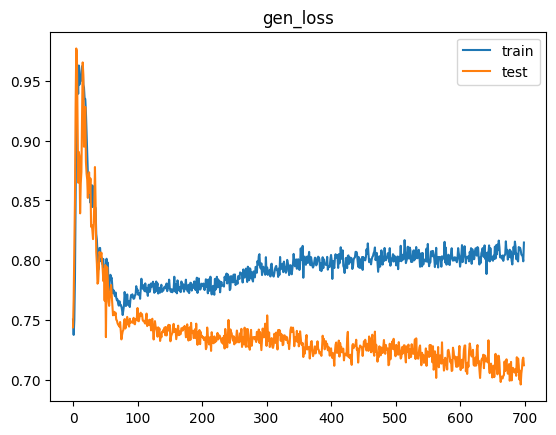

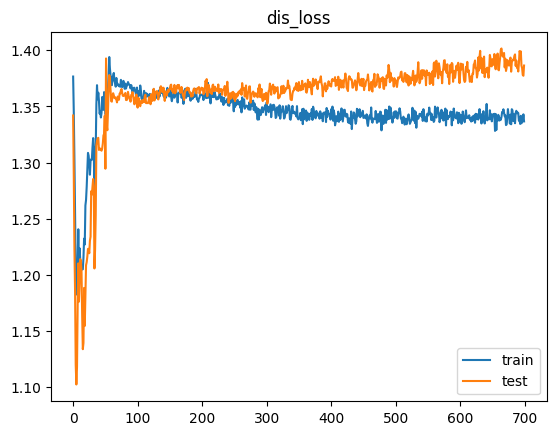

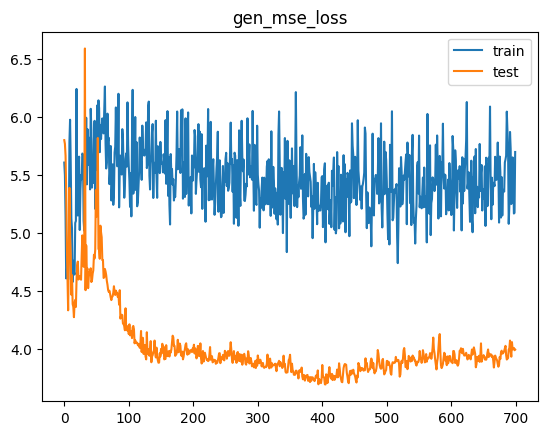

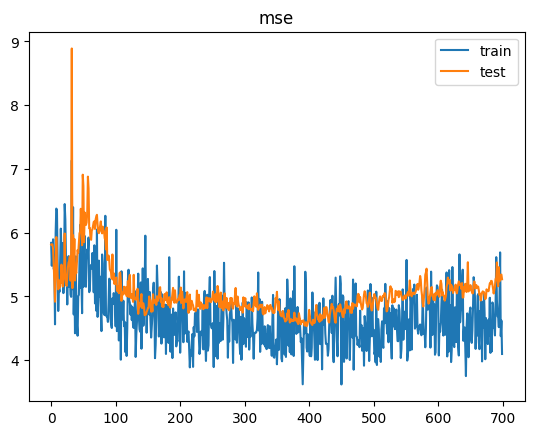

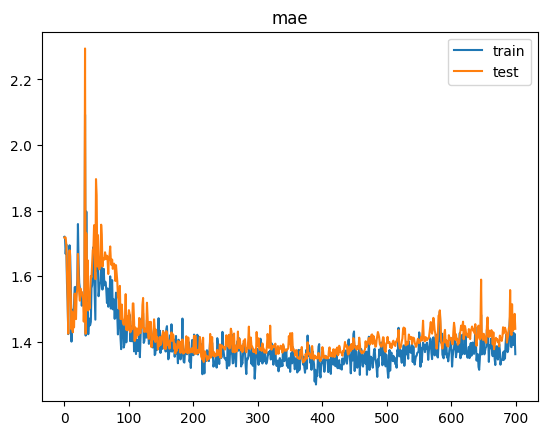

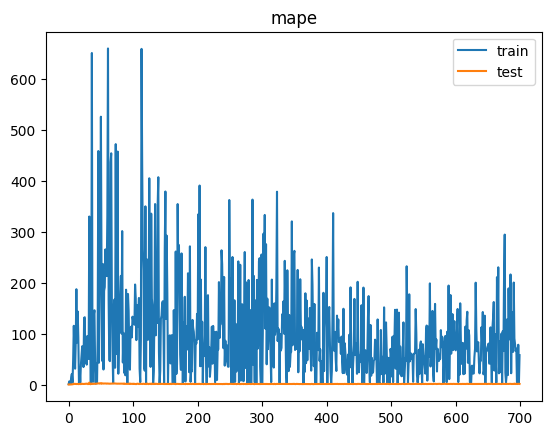

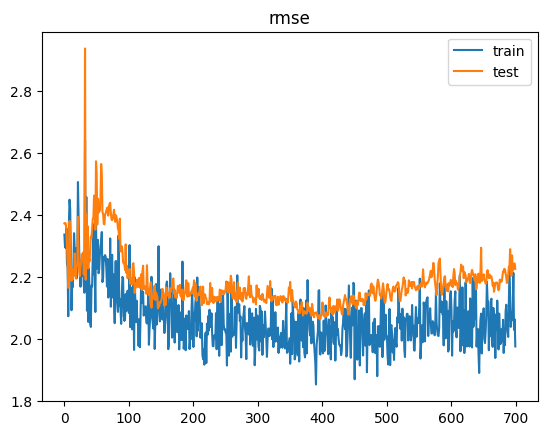

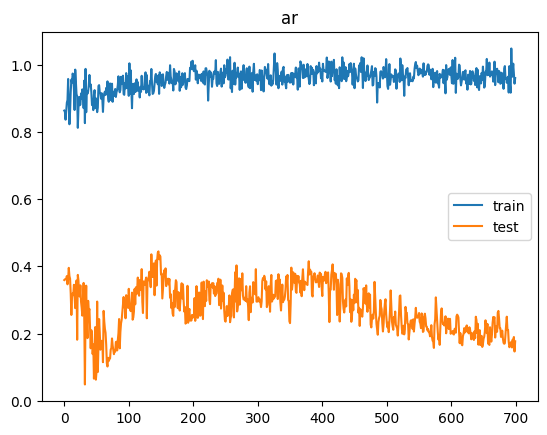

2/2 [==============================] - 1s 3ms/step


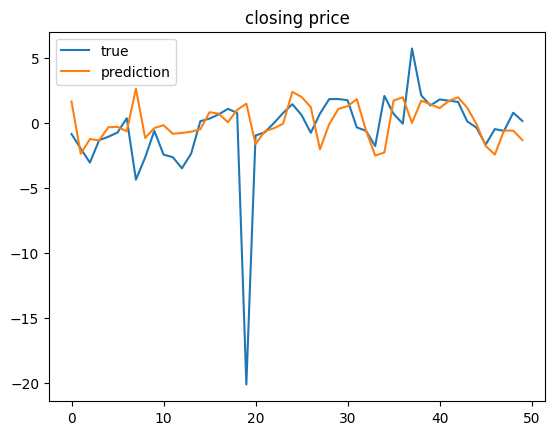

[MSE Baseline] train: 3.713310403378629  test: 4.6881765064049805
Delta time with epochs = 700: 0:11:36.517719
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.9053816795349121 sec Generator Loss: 0.7830153107643127,  Discriminator_loss: 1.3585056066513062
Time for epoch 52 is 0.8984613418579102 sec Generator Loss: 0.7798174023628235,  Discriminator_loss: 1.3577181100845337
Time for epoch 53 is 0.8936407566070557 sec Generator Loss: 0.7850043177604675,  Discriminator_loss: 1.3549925088882446
Time for epoch 54 is 0.8953077793121338 sec Generator Loss: 0.7872213125228882,  Discriminator_loss: 1.3611716032028198
Time for epoch 55 is 0.9023716449737549 sec Generator Loss: 0.7816169857978821,  Discriminator_loss: 1.3576385974884033
Time for epoch 56 is 0.9022543430328369 sec Generator Loss: 0.7850276231765747,  Discriminator_loss: 1.3562332391738892
Time for epoch 57 is 0.9203979969024658 sec Generator Loss: 0.7803328633308411,  Discriminator_loss: 1.354501724243164
Time for epoch 58 is 0.8989086151123047 sec Generator Loss: 0.7929375171661377,  Discriminator_loss: 1.352917194366455
Time for epoch 59 is 0.9030942916870117 se

Time for epoch 120 is 1.0481536388397217 sec Generator Loss: 0.7760178446769714,  Discriminator_loss: 1.358703851699829
Time for epoch 121 is 1.0519413948059082 sec Generator Loss: 0.767686128616333,  Discriminator_loss: 1.3640413284301758
Time for epoch 122 is 0.9819221496582031 sec Generator Loss: 0.7742851376533508,  Discriminator_loss: 1.3655225038528442
Time for epoch 123 is 0.981081485748291 sec Generator Loss: 0.774215042591095,  Discriminator_loss: 1.3665435314178467
Time for epoch 124 is 0.9872159957885742 sec Generator Loss: 0.7762745022773743,  Discriminator_loss: 1.3649903535842896
Time for epoch 125 is 1.018049955368042 sec Generator Loss: 0.7742093801498413,  Discriminator_loss: 1.3648406267166138
Time for epoch 126 is 1.026843786239624 sec Generator Loss: 0.7745566964149475,  Discriminator_loss: 1.3669826984405518
Time for epoch 127 is 0.990811824798584 sec Generator Loss: 0.7724048495292664,  Discriminator_loss: 1.3629692792892456
Time for epoch 128 is 1.012932777404785

Time for epoch 189 is 0.9596271514892578 sec Generator Loss: 0.7666646242141724,  Discriminator_loss: 1.365093469619751
Time for epoch 190 is 0.9392821788787842 sec Generator Loss: 0.7633655071258545,  Discriminator_loss: 1.3649781942367554
Time for epoch 191 is 0.9371836185455322 sec Generator Loss: 0.7660903334617615,  Discriminator_loss: 1.3632010221481323
Time for epoch 192 is 0.9335579872131348 sec Generator Loss: 0.7645342350006104,  Discriminator_loss: 1.368801474571228
Time for epoch 193 is 0.9919278621673584 sec Generator Loss: 0.7672495245933533,  Discriminator_loss: 1.3645464181900024
Time for epoch 194 is 0.9894707202911377 sec Generator Loss: 0.7686258554458618,  Discriminator_loss: 1.3665201663970947
Time for epoch 195 is 1.0485494136810303 sec Generator Loss: 0.7740259766578674,  Discriminator_loss: 1.3596692085266113
Time for epoch 196 is 1.0821783542633057 sec Generator Loss: 0.7672309875488281,  Discriminator_loss: 1.3690834045410156
Time for epoch 197 is 0.9464492797

Time for epoch 258 is 0.9168510437011719 sec Generator Loss: 0.7685074806213379,  Discriminator_loss: 1.3648463487625122
Time for epoch 259 is 0.9154336452484131 sec Generator Loss: 0.7720568180084229,  Discriminator_loss: 1.3656386137008667
Time for epoch 260 is 0.9266884326934814 sec Generator Loss: 0.7663094401359558,  Discriminator_loss: 1.3628243207931519
Time for epoch 261 is 0.9208111763000488 sec Generator Loss: 0.7706750631332397,  Discriminator_loss: 1.3598313331604004
Time for epoch 262 is 0.9354226589202881 sec Generator Loss: 0.7754100561141968,  Discriminator_loss: 1.3539689779281616
Time for epoch 263 is 0.9133119583129883 sec Generator Loss: 0.7732653021812439,  Discriminator_loss: 1.3612908124923706
Time for epoch 264 is 0.9111599922180176 sec Generator Loss: 0.777148425579071,  Discriminator_loss: 1.3571182489395142
Time for epoch 265 is 0.908728837966919 sec Generator Loss: 0.7726985812187195,  Discriminator_loss: 1.3622796535491943
Time for epoch 266 is 0.9108872413

Time for epoch 327 is 0.935232400894165 sec Generator Loss: 0.783402144908905,  Discriminator_loss: 1.3586524724960327
Time for epoch 328 is 0.9699735641479492 sec Generator Loss: 0.7837055325508118,  Discriminator_loss: 1.353367567062378
Time for epoch 329 is 0.9294133186340332 sec Generator Loss: 0.7806535363197327,  Discriminator_loss: 1.351797342300415
Time for epoch 330 is 0.924614429473877 sec Generator Loss: 0.7810044884681702,  Discriminator_loss: 1.351200819015503
Time for epoch 331 is 0.9288196563720703 sec Generator Loss: 0.7918224334716797,  Discriminator_loss: 1.3492891788482666
Time for epoch 332 is 0.9294931888580322 sec Generator Loss: 0.7802926301956177,  Discriminator_loss: 1.3519864082336426
Time for epoch 333 is 0.9201555252075195 sec Generator Loss: 0.7858620882034302,  Discriminator_loss: 1.3534084558486938
Time for epoch 334 is 0.9253804683685303 sec Generator Loss: 0.7826659679412842,  Discriminator_loss: 1.354622483253479
Time for epoch 335 is 0.940347671508789

Time for epoch 395 is 0.9593505859375 sec Generator Loss: 0.7929455637931824,  Discriminator_loss: 1.3438327312469482
Time for epoch 396 is 0.9850423336029053 sec Generator Loss: 0.7861623764038086,  Discriminator_loss: 1.3512572050094604
Time for epoch 397 is 0.9675755500793457 sec Generator Loss: 0.7888036966323853,  Discriminator_loss: 1.3460936546325684
Time for epoch 398 is 1.218886375427246 sec Generator Loss: 0.7983011603355408,  Discriminator_loss: 1.3410581350326538
Time for epoch 399 is 1.1771814823150635 sec Generator Loss: 0.7922857403755188,  Discriminator_loss: 1.3486642837524414
Time for epoch 400 is 1.180008888244629 sec Generator Loss: 0.7984771728515625,  Discriminator_loss: 1.3431402444839478
Time for epoch 401 is 1.0411288738250732 sec Generator Loss: 0.7881637811660767,  Discriminator_loss: 1.351086139678955
Time for epoch 402 is 1.01802659034729 sec Generator Loss: 0.7936830520629883,  Discriminator_loss: 1.3394187688827515
Time for epoch 403 is 1.0802559852600098

Time for epoch 464 is 1.2305734157562256 sec Generator Loss: 0.7965587973594666,  Discriminator_loss: 1.3471283912658691
Time for epoch 465 is 0.9881882667541504 sec Generator Loss: 0.797957181930542,  Discriminator_loss: 1.3428975343704224
Time for epoch 466 is 0.963005542755127 sec Generator Loss: 0.7966928482055664,  Discriminator_loss: 1.3372734785079956
Time for epoch 467 is 0.9920907020568848 sec Generator Loss: 0.8034476637840271,  Discriminator_loss: 1.3345606327056885
Time for epoch 468 is 0.9767441749572754 sec Generator Loss: 0.8036172389984131,  Discriminator_loss: 1.3345224857330322
Time for epoch 469 is 0.9562304019927979 sec Generator Loss: 0.8061618208885193,  Discriminator_loss: 1.3356623649597168
Time for epoch 470 is 0.9889249801635742 sec Generator Loss: 0.7958617210388184,  Discriminator_loss: 1.3376233577728271
Time for epoch 471 is 0.9605815410614014 sec Generator Loss: 0.7985506653785706,  Discriminator_loss: 1.3361736536026
Time for epoch 472 is 0.9835860729217

Time for epoch 533 is 0.9981186389923096 sec Generator Loss: 0.7980024218559265,  Discriminator_loss: 1.3434301614761353
Time for epoch 534 is 0.9659600257873535 sec Generator Loss: 0.7965644598007202,  Discriminator_loss: 1.3423357009887695
Time for epoch 535 is 0.9765806198120117 sec Generator Loss: 0.8121424317359924,  Discriminator_loss: 1.3286869525909424
Time for epoch 536 is 0.9688479900360107 sec Generator Loss: 0.8039031028747559,  Discriminator_loss: 1.3327679634094238
Time for epoch 537 is 0.9941213130950928 sec Generator Loss: 0.8073702454566956,  Discriminator_loss: 1.3352832794189453
Time for epoch 538 is 1.0312225818634033 sec Generator Loss: 0.8103699684143066,  Discriminator_loss: 1.3348501920700073
Time for epoch 539 is 1.007953405380249 sec Generator Loss: 0.8081471920013428,  Discriminator_loss: 1.3349252939224243
Time for epoch 540 is 1.017096757888794 sec Generator Loss: 0.8038901090621948,  Discriminator_loss: 1.3436944484710693
Time for epoch 541 is 0.9695570468

Time for epoch 601 is 1.0041985511779785 sec Generator Loss: 0.8077143430709839,  Discriminator_loss: 1.3441765308380127
Time for epoch 602 is 1.034900426864624 sec Generator Loss: 0.8109904527664185,  Discriminator_loss: 1.3344395160675049
Time for epoch 603 is 0.96343994140625 sec Generator Loss: 0.8078327178955078,  Discriminator_loss: 1.3392258882522583
Time for epoch 604 is 1.0340328216552734 sec Generator Loss: 0.8115338683128357,  Discriminator_loss: 1.333264708518982
Time for epoch 605 is 0.9147453308105469 sec Generator Loss: 0.8141478300094604,  Discriminator_loss: 1.3325278759002686
Time for epoch 606 is 0.9137670993804932 sec Generator Loss: 0.8092589974403381,  Discriminator_loss: 1.3401118516921997
Time for epoch 607 is 0.9211533069610596 sec Generator Loss: 0.8161082863807678,  Discriminator_loss: 1.3338085412979126
Time for epoch 608 is 0.9724776744842529 sec Generator Loss: 0.8070744276046753,  Discriminator_loss: 1.340783953666687
Time for epoch 609 is 1.0517950057983

Time for epoch 669 is 0.9069545269012451 sec Generator Loss: 0.7977197170257568,  Discriminator_loss: 1.3434127569198608
Time for epoch 670 is 1.0071163177490234 sec Generator Loss: 0.8076006770133972,  Discriminator_loss: 1.337978482246399
Time for epoch 671 is 0.9819543361663818 sec Generator Loss: 0.8048174977302551,  Discriminator_loss: 1.3346117734909058
Time for epoch 672 is 0.9740567207336426 sec Generator Loss: 0.8057296276092529,  Discriminator_loss: 1.3378068208694458
Time for epoch 673 is 0.9744713306427002 sec Generator Loss: 0.8091011047363281,  Discriminator_loss: 1.3287593126296997
Time for epoch 674 is 0.907890796661377 sec Generator Loss: 0.8190210461616516,  Discriminator_loss: 1.3323734998703003
Time for epoch 675 is 0.9075255393981934 sec Generator Loss: 0.8087804913520813,  Discriminator_loss: 1.3384236097335815
Time for epoch 676 is 0.905630350112915 sec Generator Loss: 0.8098338842391968,  Discriminator_loss: 1.3362116813659668
Time for epoch 677 is 0.94148111343

Time for epoch 738 is 0.9154109954833984 sec Generator Loss: 0.803997278213501,  Discriminator_loss: 1.339970350265503
Time for epoch 739 is 0.9274735450744629 sec Generator Loss: 0.8026386499404907,  Discriminator_loss: 1.3366204500198364
Time for epoch 740 is 0.9278044700622559 sec Generator Loss: 0.8000391125679016,  Discriminator_loss: 1.3510950803756714
Time for epoch 741 is 0.912285327911377 sec Generator Loss: 0.8051005601882935,  Discriminator_loss: 1.3352147340774536
Time for epoch 742 is 0.9097745418548584 sec Generator Loss: 0.8030527234077454,  Discriminator_loss: 1.339124083518982
Time for epoch 743 is 0.9242064952850342 sec Generator Loss: 0.8044119477272034,  Discriminator_loss: 1.3427540063858032
Time for epoch 744 is 0.915290117263794 sec Generator Loss: 0.7976335287094116,  Discriminator_loss: 1.3397908210754395
Time for epoch 745 is 0.9404268264770508 sec Generator Loss: 0.80376136302948,  Discriminator_loss: 1.3354171514511108
Time for epoch 746 is 0.912215471267700

Time for epoch 806 is 0.9166834354400635 sec Generator Loss: 0.8019137978553772,  Discriminator_loss: 1.3452043533325195
Time for epoch 807 is 0.9115505218505859 sec Generator Loss: 0.8074914813041687,  Discriminator_loss: 1.337286353111267
Time for epoch 808 is 0.9246571063995361 sec Generator Loss: 0.8055563569068909,  Discriminator_loss: 1.3368455171585083
Time for epoch 809 is 0.9498224258422852 sec Generator Loss: 0.8095729351043701,  Discriminator_loss: 1.336903691291809
Time for epoch 810 is 0.9650208950042725 sec Generator Loss: 0.8011507987976074,  Discriminator_loss: 1.3470525741577148
Time for epoch 811 is 0.9148616790771484 sec Generator Loss: 0.8092883825302124,  Discriminator_loss: 1.3365998268127441
Time for epoch 812 is 0.9444911479949951 sec Generator Loss: 0.7981233596801758,  Discriminator_loss: 1.3471533060073853
Time for epoch 813 is 0.9124181270599365 sec Generator Loss: 0.8064400553703308,  Discriminator_loss: 1.338083028793335
Time for epoch 814 is 0.95759391784

Time for epoch 875 is 0.9443583488464355 sec Generator Loss: 0.8050082921981812,  Discriminator_loss: 1.3436083793640137
Time for epoch 876 is 1.0637485980987549 sec Generator Loss: 0.8062305450439453,  Discriminator_loss: 1.3372315168380737
Time for epoch 877 is 1.0842068195343018 sec Generator Loss: 0.80760258436203,  Discriminator_loss: 1.3352205753326416
Time for epoch 878 is 0.9696829319000244 sec Generator Loss: 0.8095014691352844,  Discriminator_loss: 1.3378429412841797
Time for epoch 879 is 1.0094983577728271 sec Generator Loss: 0.8096961379051208,  Discriminator_loss: 1.336040735244751
Time for epoch 880 is 1.010944128036499 sec Generator Loss: 0.8067541718482971,  Discriminator_loss: 1.3406922817230225
Time for epoch 881 is 0.9212436676025391 sec Generator Loss: 0.8016484975814819,  Discriminator_loss: 1.3485455513000488
Time for epoch 882 is 0.9351708889007568 sec Generator Loss: 0.8112897872924805,  Discriminator_loss: 1.3393847942352295
Time for epoch 883 is 1.077392816543

Time for epoch 943 is 0.9252169132232666 sec Generator Loss: 0.8092703819274902,  Discriminator_loss: 1.3411567211151123
Time for epoch 944 is 0.9912331104278564 sec Generator Loss: 0.8037570714950562,  Discriminator_loss: 1.3471696376800537
Time for epoch 945 is 1.1155171394348145 sec Generator Loss: 0.8075457215309143,  Discriminator_loss: 1.3419921398162842
Time for epoch 946 is 0.9234795570373535 sec Generator Loss: 0.8046026229858398,  Discriminator_loss: 1.3406521081924438
Time for epoch 947 is 0.952021598815918 sec Generator Loss: 0.8134293556213379,  Discriminator_loss: 1.333827257156372
Time for epoch 948 is 0.9203791618347168 sec Generator Loss: 0.8135765790939331,  Discriminator_loss: 1.3450329303741455
Time for epoch 949 is 0.9253559112548828 sec Generator Loss: 0.8073884844779968,  Discriminator_loss: 1.3365306854248047
Time for epoch 950 is 0.9678323268890381 sec Generator Loss: 0.8040795922279358,  Discriminator_loss: 1.337186336517334


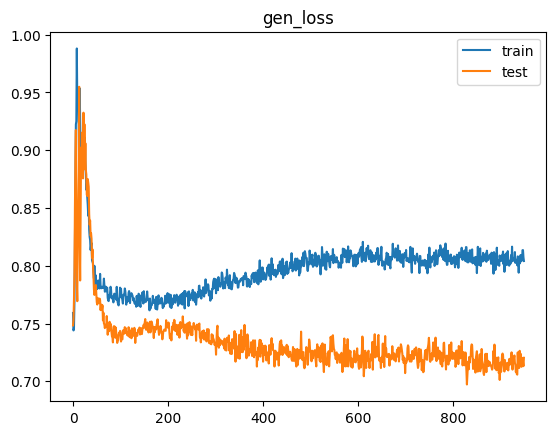

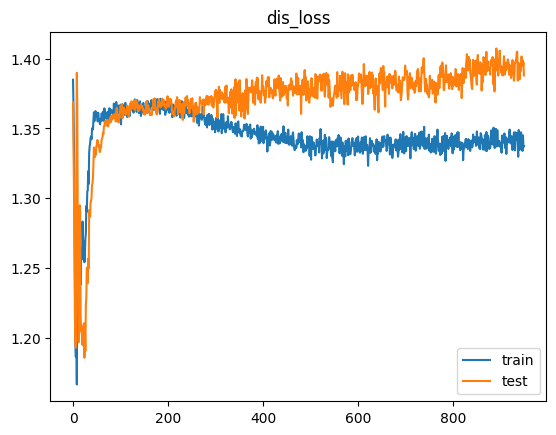

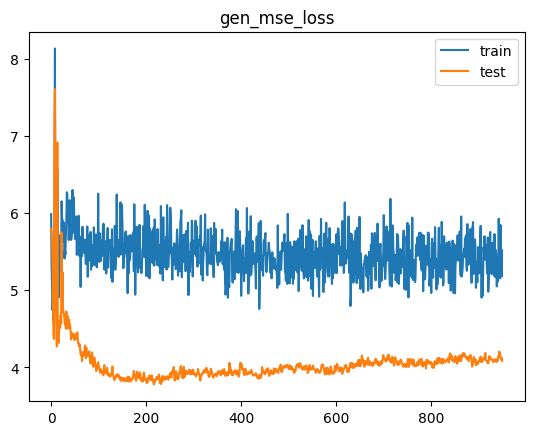

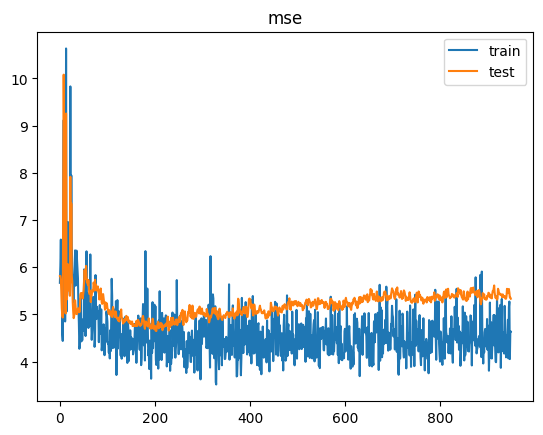

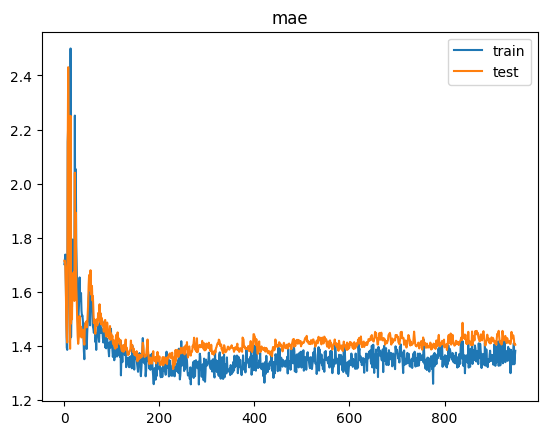

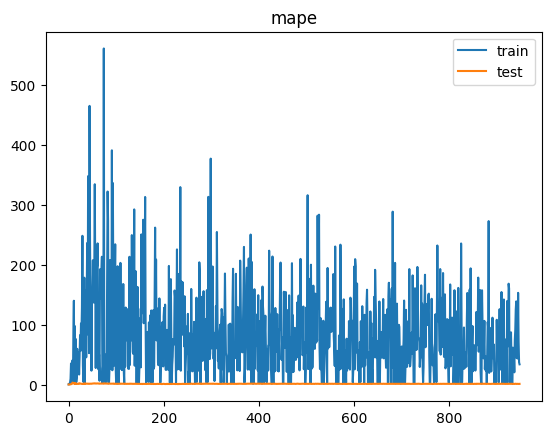

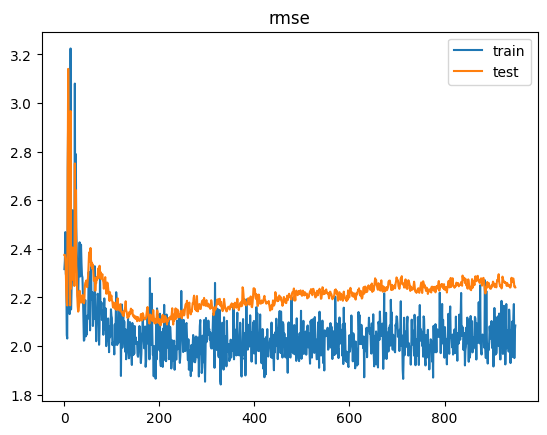

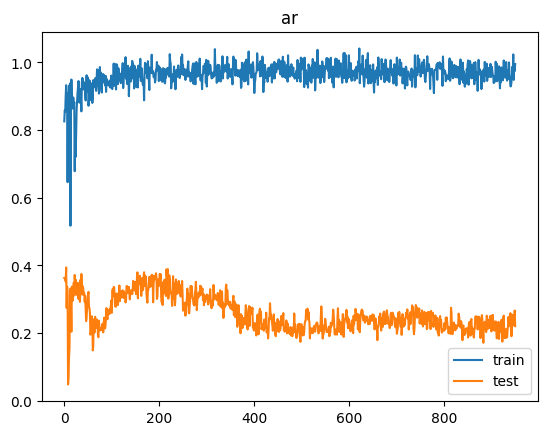

2/2 [==============================] - 1s 4ms/step


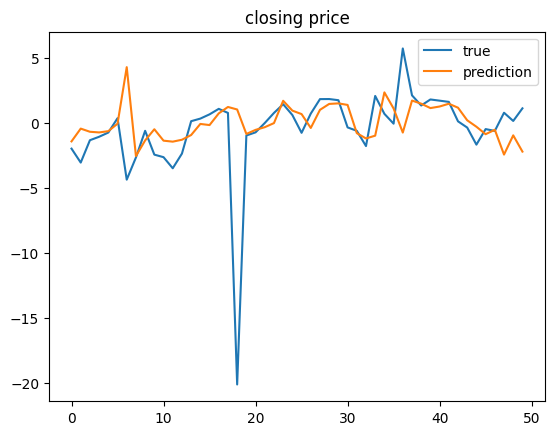

[MSE Baseline] train: 4.427352272069471  test: 4.68758521157695
Delta time with epochs = 950: 0:15:40.758248
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 20)             0         
                

Time for epoch 51 is 0.9300398826599121 sec Generator Loss: 0.7857428789138794,  Discriminator_loss: 1.369796633720398
Time for epoch 52 is 0.9572489261627197 sec Generator Loss: 0.7885841727256775,  Discriminator_loss: 1.3641365766525269
Time for epoch 53 is 0.9637677669525146 sec Generator Loss: 0.7863357663154602,  Discriminator_loss: 1.3675240278244019
Time for epoch 54 is 0.984835147857666 sec Generator Loss: 0.7748919725418091,  Discriminator_loss: 1.3678972721099854
Time for epoch 55 is 1.0439610481262207 sec Generator Loss: 0.7758910655975342,  Discriminator_loss: 1.36820650100708
Time for epoch 56 is 0.947209358215332 sec Generator Loss: 0.7792863845825195,  Discriminator_loss: 1.3639233112335205
Time for epoch 57 is 0.930248498916626 sec Generator Loss: 0.7714552879333496,  Discriminator_loss: 1.3628796339035034
Time for epoch 58 is 0.9254343509674072 sec Generator Loss: 0.7754858136177063,  Discriminator_loss: 1.3618446588516235
Time for epoch 59 is 0.9143407344818115 sec Ge

Time for epoch 120 is 0.9160151481628418 sec Generator Loss: 0.7697170972824097,  Discriminator_loss: 1.3643697500228882
Time for epoch 121 is 0.9066033363342285 sec Generator Loss: 0.7686980366706848,  Discriminator_loss: 1.3688294887542725
Time for epoch 122 is 0.9208731651306152 sec Generator Loss: 0.767504870891571,  Discriminator_loss: 1.3675529956817627
Time for epoch 123 is 0.9026076793670654 sec Generator Loss: 0.766167163848877,  Discriminator_loss: 1.3676711320877075
Time for epoch 124 is 0.9516880512237549 sec Generator Loss: 0.76803058385849,  Discriminator_loss: 1.3711720705032349
Time for epoch 125 is 0.9228525161743164 sec Generator Loss: 0.7714830040931702,  Discriminator_loss: 1.366027593612671
Time for epoch 126 is 0.931290864944458 sec Generator Loss: 0.7661433815956116,  Discriminator_loss: 1.369447112083435
Time for epoch 127 is 0.9433660507202148 sec Generator Loss: 0.7707273960113525,  Discriminator_loss: 1.3663535118103027
Time for epoch 128 is 0.950386762619018

Time for epoch 189 is 0.9360213279724121 sec Generator Loss: 0.7685956954956055,  Discriminator_loss: 1.3618894815444946
Time for epoch 190 is 0.9430639743804932 sec Generator Loss: 0.7708034515380859,  Discriminator_loss: 1.3634148836135864
Time for epoch 191 is 0.969851016998291 sec Generator Loss: 0.763884961605072,  Discriminator_loss: 1.363905906677246
Time for epoch 192 is 0.9663162231445312 sec Generator Loss: 0.7623677849769592,  Discriminator_loss: 1.36505126953125
Time for epoch 193 is 0.9502630233764648 sec Generator Loss: 0.7722679972648621,  Discriminator_loss: 1.36247980594635
Time for epoch 194 is 0.966245174407959 sec Generator Loss: 0.7662064433097839,  Discriminator_loss: 1.3644026517868042
Time for epoch 195 is 0.9293465614318848 sec Generator Loss: 0.7681452035903931,  Discriminator_loss: 1.363982915878296
Time for epoch 196 is 0.9120879173278809 sec Generator Loss: 0.7692150473594666,  Discriminator_loss: 1.3652679920196533
Time for epoch 197 is 0.9250025749206543 

Time for epoch 258 is 1.0165011882781982 sec Generator Loss: 0.7742151618003845,  Discriminator_loss: 1.3576624393463135
Time for epoch 259 is 0.9721975326538086 sec Generator Loss: 0.7743875980377197,  Discriminator_loss: 1.3573589324951172
Time for epoch 260 is 0.9437975883483887 sec Generator Loss: 0.7762844562530518,  Discriminator_loss: 1.357932209968567
Time for epoch 261 is 0.920435905456543 sec Generator Loss: 0.7775582671165466,  Discriminator_loss: 1.354188084602356
Time for epoch 262 is 0.9451513290405273 sec Generator Loss: 0.7766121029853821,  Discriminator_loss: 1.3529913425445557
Time for epoch 263 is 0.9283649921417236 sec Generator Loss: 0.7769533395767212,  Discriminator_loss: 1.3577682971954346
Time for epoch 264 is 1.003098726272583 sec Generator Loss: 0.7745012044906616,  Discriminator_loss: 1.362505316734314
Time for epoch 265 is 0.9886183738708496 sec Generator Loss: 0.7726047039031982,  Discriminator_loss: 1.3579013347625732
Time for epoch 266 is 0.9875707626342

Time for epoch 326 is 0.993248462677002 sec Generator Loss: 0.7760589718818665,  Discriminator_loss: 1.3530114889144897
Time for epoch 327 is 1.0336546897888184 sec Generator Loss: 0.7791286110877991,  Discriminator_loss: 1.3560738563537598
Time for epoch 328 is 0.9849507808685303 sec Generator Loss: 0.7771130204200745,  Discriminator_loss: 1.3533399105072021
Time for epoch 329 is 0.979311466217041 sec Generator Loss: 0.7764008641242981,  Discriminator_loss: 1.3591910600662231
Time for epoch 330 is 0.9542460441589355 sec Generator Loss: 0.7798115611076355,  Discriminator_loss: 1.3575716018676758
Time for epoch 331 is 0.9158914089202881 sec Generator Loss: 0.7785968780517578,  Discriminator_loss: 1.356337070465088
Time for epoch 332 is 0.9302012920379639 sec Generator Loss: 0.7795538306236267,  Discriminator_loss: 1.3553611040115356
Time for epoch 333 is 0.9512448310852051 sec Generator Loss: 0.7809432744979858,  Discriminator_loss: 1.3552812337875366
Time for epoch 334 is 0.91726684570

Time for epoch 394 is 0.9271872043609619 sec Generator Loss: 0.7841930389404297,  Discriminator_loss: 1.3505420684814453
Time for epoch 395 is 0.9192831516265869 sec Generator Loss: 0.7855637669563293,  Discriminator_loss: 1.345441460609436
Time for epoch 396 is 0.9320120811462402 sec Generator Loss: 0.7846088409423828,  Discriminator_loss: 1.343342661857605
Time for epoch 397 is 0.9105923175811768 sec Generator Loss: 0.7877159118652344,  Discriminator_loss: 1.3515863418579102
Time for epoch 398 is 0.9139888286590576 sec Generator Loss: 0.7893604636192322,  Discriminator_loss: 1.3555467128753662
Time for epoch 399 is 0.9181101322174072 sec Generator Loss: 0.7811808586120605,  Discriminator_loss: 1.3549580574035645
Time for epoch 400 is 0.9092776775360107 sec Generator Loss: 0.7806819081306458,  Discriminator_loss: 1.3523638248443604
Time for epoch 401 is 0.9324407577514648 sec Generator Loss: 0.7814042568206787,  Discriminator_loss: 1.3498834371566772
Time for epoch 402 is 0.8748142719

Time for epoch 462 is 0.9043691158294678 sec Generator Loss: 0.7819969058036804,  Discriminator_loss: 1.351694941520691
Time for epoch 463 is 0.9116220474243164 sec Generator Loss: 0.7861754894256592,  Discriminator_loss: 1.3502482175827026
Time for epoch 464 is 0.9045586585998535 sec Generator Loss: 0.7868607044219971,  Discriminator_loss: 1.348771095275879
Time for epoch 465 is 0.9835939407348633 sec Generator Loss: 0.7914440035820007,  Discriminator_loss: 1.3522138595581055
Time for epoch 466 is 0.927966833114624 sec Generator Loss: 0.7869532704353333,  Discriminator_loss: 1.352527379989624
Time for epoch 467 is 1.0702459812164307 sec Generator Loss: 0.7849555611610413,  Discriminator_loss: 1.3527647256851196
Time for epoch 468 is 0.9242069721221924 sec Generator Loss: 0.7784795165061951,  Discriminator_loss: 1.352535367012024
Time for epoch 469 is 0.9026167392730713 sec Generator Loss: 0.7888244390487671,  Discriminator_loss: 1.3449162244796753
Time for epoch 470 is 1.0316717624664

Time for epoch 530 is 1.0139837265014648 sec Generator Loss: 0.782897412776947,  Discriminator_loss: 1.3478790521621704
Time for epoch 531 is 1.0731935501098633 sec Generator Loss: 0.7815299034118652,  Discriminator_loss: 1.3541063070297241
Time for epoch 532 is 1.1753010749816895 sec Generator Loss: 0.7910564541816711,  Discriminator_loss: 1.345329999923706
Time for epoch 533 is 0.9933474063873291 sec Generator Loss: 0.7841391563415527,  Discriminator_loss: 1.3520399332046509
Time for epoch 534 is 1.04691743850708 sec Generator Loss: 0.7872273325920105,  Discriminator_loss: 1.3534482717514038
Time for epoch 535 is 0.99361252784729 sec Generator Loss: 0.7808436155319214,  Discriminator_loss: 1.3582303524017334
Time for epoch 536 is 1.0727581977844238 sec Generator Loss: 0.7812851667404175,  Discriminator_loss: 1.3526169061660767
Time for epoch 537 is 1.1412909030914307 sec Generator Loss: 0.7815802097320557,  Discriminator_loss: 1.3513189554214478
Time for epoch 538 is 1.08995795249938

Time for epoch 599 is 0.9161012172698975 sec Generator Loss: 0.7843931913375854,  Discriminator_loss: 1.3564318418502808
Time for epoch 600 is 0.9156687259674072 sec Generator Loss: 0.7871671915054321,  Discriminator_loss: 1.358148455619812
Time for epoch 601 is 0.911635160446167 sec Generator Loss: 0.7820220589637756,  Discriminator_loss: 1.3523024320602417
Time for epoch 602 is 0.9219136238098145 sec Generator Loss: 0.7829641699790955,  Discriminator_loss: 1.3465542793273926
Time for epoch 603 is 0.9322679042816162 sec Generator Loss: 0.7854635715484619,  Discriminator_loss: 1.3481322526931763
Time for epoch 604 is 0.9213061332702637 sec Generator Loss: 0.7839483022689819,  Discriminator_loss: 1.3508963584899902
Time for epoch 605 is 0.9232563972473145 sec Generator Loss: 0.7841567397117615,  Discriminator_loss: 1.3551933765411377
Time for epoch 606 is 0.911278486251831 sec Generator Loss: 0.7903310656547546,  Discriminator_loss: 1.3507695198059082
Time for epoch 607 is 0.91656565666

Time for epoch 667 is 1.0152788162231445 sec Generator Loss: 0.7849892377853394,  Discriminator_loss: 1.3478140830993652
Time for epoch 668 is 0.9861819744110107 sec Generator Loss: 0.7867000102996826,  Discriminator_loss: 1.3511778116226196
Time for epoch 669 is 0.9727528095245361 sec Generator Loss: 0.7877772450447083,  Discriminator_loss: 1.3578213453292847
Time for epoch 670 is 0.9819607734680176 sec Generator Loss: 0.7884083986282349,  Discriminator_loss: 1.3529787063598633
Time for epoch 671 is 0.9728670120239258 sec Generator Loss: 0.7888663411140442,  Discriminator_loss: 1.3509246110916138
Time for epoch 672 is 0.9944465160369873 sec Generator Loss: 0.7894338369369507,  Discriminator_loss: 1.3487228155136108
Time for epoch 673 is 0.9613180160522461 sec Generator Loss: 0.7883302569389343,  Discriminator_loss: 1.3553398847579956
Time for epoch 674 is 0.9528017044067383 sec Generator Loss: 0.7753714323043823,  Discriminator_loss: 1.360709547996521
Time for epoch 675 is 1.001629352

Time for epoch 735 is 0.9074153900146484 sec Generator Loss: 0.783254861831665,  Discriminator_loss: 1.3511443138122559
Time for epoch 736 is 0.9083561897277832 sec Generator Loss: 0.786515474319458,  Discriminator_loss: 1.3473718166351318
Time for epoch 737 is 0.9574415683746338 sec Generator Loss: 0.7907859683036804,  Discriminator_loss: 1.3467302322387695
Time for epoch 738 is 0.922825813293457 sec Generator Loss: 0.7824722528457642,  Discriminator_loss: 1.3530420064926147
Time for epoch 739 is 0.9215879440307617 sec Generator Loss: 0.7828347682952881,  Discriminator_loss: 1.3556597232818604
Time for epoch 740 is 0.9114303588867188 sec Generator Loss: 0.7958050966262817,  Discriminator_loss: 1.3472354412078857
Time for epoch 741 is 0.9334743022918701 sec Generator Loss: 0.7923954129219055,  Discriminator_loss: 1.3511056900024414
Time for epoch 742 is 0.9138669967651367 sec Generator Loss: 0.796330988407135,  Discriminator_loss: 1.3558824062347412
Time for epoch 743 is 0.934501647949

Time for epoch 804 is 0.9244129657745361 sec Generator Loss: 0.7827838063240051,  Discriminator_loss: 1.3568450212478638
Time for epoch 805 is 0.913994550704956 sec Generator Loss: 0.784906268119812,  Discriminator_loss: 1.3575859069824219
Time for epoch 806 is 0.9195265769958496 sec Generator Loss: 0.784261167049408,  Discriminator_loss: 1.3519847393035889
Time for epoch 807 is 0.9385988712310791 sec Generator Loss: 0.7832036018371582,  Discriminator_loss: 1.3546425104141235
Time for epoch 808 is 0.9170551300048828 sec Generator Loss: 0.7884325385093689,  Discriminator_loss: 1.350275993347168
Time for epoch 809 is 0.932563304901123 sec Generator Loss: 0.7893573641777039,  Discriminator_loss: 1.3529289960861206
Time for epoch 810 is 0.9422702789306641 sec Generator Loss: 0.7938390970230103,  Discriminator_loss: 1.3481295108795166
Time for epoch 811 is 0.9968240261077881 sec Generator Loss: 0.7819541692733765,  Discriminator_loss: 1.347802996635437
Time for epoch 812 is 0.98662877082824

Time for epoch 872 is 1.008434534072876 sec Generator Loss: 0.7839687466621399,  Discriminator_loss: 1.3560377359390259
Time for epoch 873 is 1.0022809505462646 sec Generator Loss: 0.7902010679244995,  Discriminator_loss: 1.351340413093567
Time for epoch 874 is 1.02872896194458 sec Generator Loss: 0.7788764834403992,  Discriminator_loss: 1.3562663793563843
Time for epoch 875 is 1.0573582649230957 sec Generator Loss: 0.7868714928627014,  Discriminator_loss: 1.3499932289123535
Time for epoch 876 is 1.0439884662628174 sec Generator Loss: 0.7853801846504211,  Discriminator_loss: 1.3514131307601929
Time for epoch 877 is 1.049863338470459 sec Generator Loss: 0.7925809621810913,  Discriminator_loss: 1.3499447107315063
Time for epoch 878 is 1.0403754711151123 sec Generator Loss: 0.7854377031326294,  Discriminator_loss: 1.3514355421066284
Time for epoch 879 is 1.0250558853149414 sec Generator Loss: 0.7905998826026917,  Discriminator_loss: 1.3514080047607422
Time for epoch 880 is 1.0474894046783

Time for epoch 940 is 0.9764623641967773 sec Generator Loss: 0.7895269393920898,  Discriminator_loss: 1.3492639064788818
Time for epoch 941 is 0.9738173484802246 sec Generator Loss: 0.7846846580505371,  Discriminator_loss: 1.3536456823349
Time for epoch 942 is 0.9048173427581787 sec Generator Loss: 0.7822283506393433,  Discriminator_loss: 1.351338505744934
Time for epoch 943 is 0.948082685470581 sec Generator Loss: 0.7915405631065369,  Discriminator_loss: 1.3479554653167725
Time for epoch 944 is 0.9162750244140625 sec Generator Loss: 0.7975724935531616,  Discriminator_loss: 1.3461705446243286
Time for epoch 945 is 0.9033756256103516 sec Generator Loss: 0.7902207374572754,  Discriminator_loss: 1.348381757736206
Time for epoch 946 is 0.935133695602417 sec Generator Loss: 0.7858326435089111,  Discriminator_loss: 1.3531370162963867
Time for epoch 947 is 0.9167389869689941 sec Generator Loss: 0.7906802892684937,  Discriminator_loss: 1.3456019163131714
Time for epoch 948 is 0.904706716537475

Time for epoch 1008 is 0.9106483459472656 sec Generator Loss: 0.7864084839820862,  Discriminator_loss: 1.3464878797531128
Time for epoch 1009 is 0.931079626083374 sec Generator Loss: 0.7938075661659241,  Discriminator_loss: 1.3442937135696411
Time for epoch 1010 is 0.9001262187957764 sec Generator Loss: 0.7916977405548096,  Discriminator_loss: 1.350304126739502
Time for epoch 1011 is 0.9312343597412109 sec Generator Loss: 0.7928720116615295,  Discriminator_loss: 1.3497234582901
Time for epoch 1012 is 0.9209983348846436 sec Generator Loss: 0.7875369191169739,  Discriminator_loss: 1.3512752056121826
Time for epoch 1013 is 0.9075021743774414 sec Generator Loss: 0.7878811955451965,  Discriminator_loss: 1.3536088466644287
Time for epoch 1014 is 0.911217212677002 sec Generator Loss: 0.7877230644226074,  Discriminator_loss: 1.3531171083450317
Time for epoch 1015 is 0.9156081676483154 sec Generator Loss: 0.7867180705070496,  Discriminator_loss: 1.3545846939086914
Time for epoch 1016 is 0.91740

Time for epoch 1076 is 0.9450666904449463 sec Generator Loss: 0.7890886664390564,  Discriminator_loss: 1.3498395681381226
Time for epoch 1077 is 0.9182569980621338 sec Generator Loss: 0.7967957258224487,  Discriminator_loss: 1.3461214303970337
Time for epoch 1078 is 0.9115729331970215 sec Generator Loss: 0.801405668258667,  Discriminator_loss: 1.3503168821334839
Time for epoch 1079 is 0.9197349548339844 sec Generator Loss: 0.8019589781761169,  Discriminator_loss: 1.345279574394226
Time for epoch 1080 is 0.9101712703704834 sec Generator Loss: 0.7933462858200073,  Discriminator_loss: 1.3460431098937988
Time for epoch 1081 is 0.9181382656097412 sec Generator Loss: 0.7909510135650635,  Discriminator_loss: 1.3506921529769897
Time for epoch 1082 is 0.9376471042633057 sec Generator Loss: 0.7916597127914429,  Discriminator_loss: 1.354475736618042
Time for epoch 1083 is 0.908837080001831 sec Generator Loss: 0.7911251187324524,  Discriminator_loss: 1.3504979610443115
Time for epoch 1084 is 0.912

Time for epoch 1144 is 0.9924511909484863 sec Generator Loss: 0.7933521866798401,  Discriminator_loss: 1.3425720930099487
Time for epoch 1145 is 1.0739693641662598 sec Generator Loss: 0.79637211561203,  Discriminator_loss: 1.3443156480789185
Time for epoch 1146 is 1.0757167339324951 sec Generator Loss: 0.7963489294052124,  Discriminator_loss: 1.3418834209442139
Time for epoch 1147 is 1.0271859169006348 sec Generator Loss: 0.7922713160514832,  Discriminator_loss: 1.3509252071380615
Time for epoch 1148 is 0.9927034378051758 sec Generator Loss: 0.7895139455795288,  Discriminator_loss: 1.347674012184143
Time for epoch 1149 is 0.9947726726531982 sec Generator Loss: 0.7874510884284973,  Discriminator_loss: 1.3511799573898315
Time for epoch 1150 is 0.9976627826690674 sec Generator Loss: 0.7935956716537476,  Discriminator_loss: 1.3497487306594849
Time for epoch 1151 is 1.0037500858306885 sec Generator Loss: 0.792356014251709,  Discriminator_loss: 1.3518705368041992
Time for epoch 1152 is 1.186

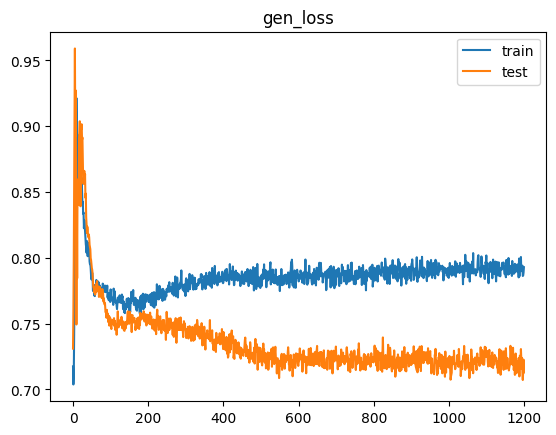

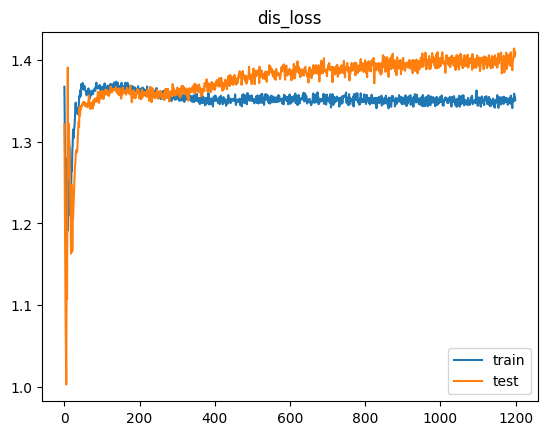

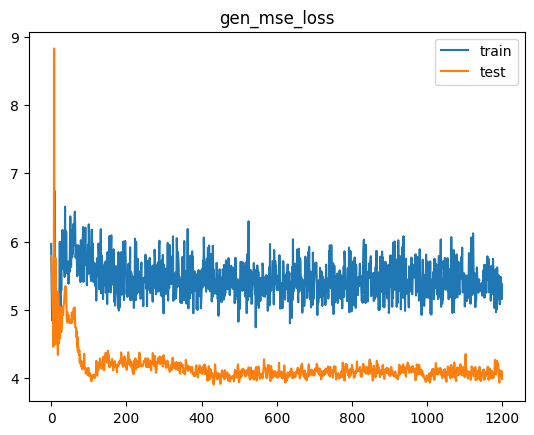

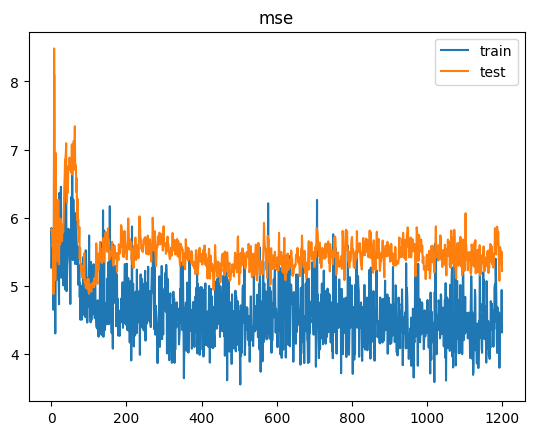

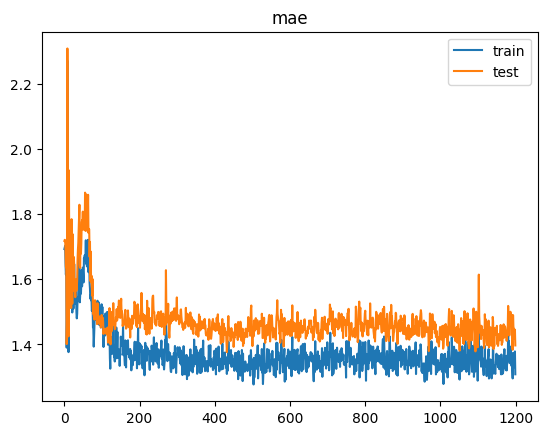

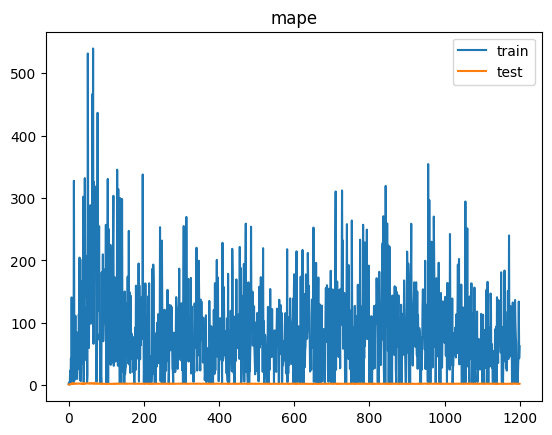

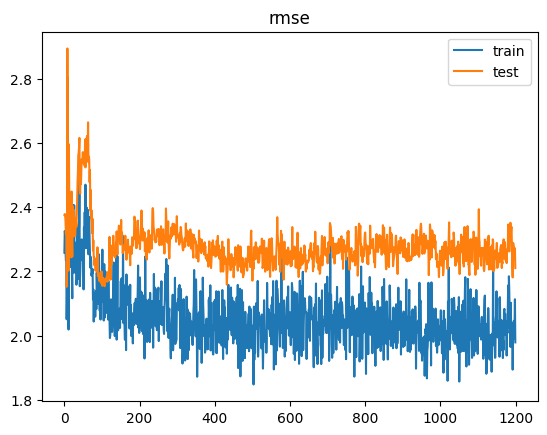

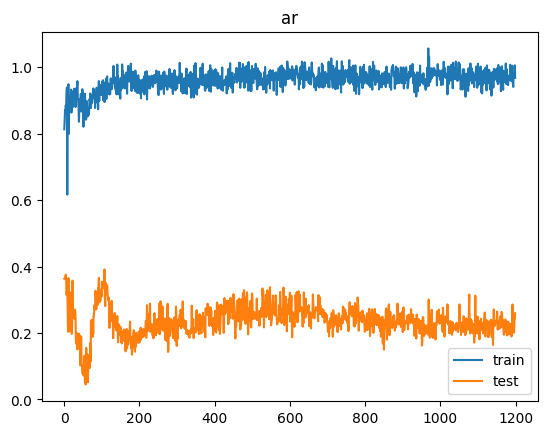

2/2 [==============================] - 1s 3ms/step


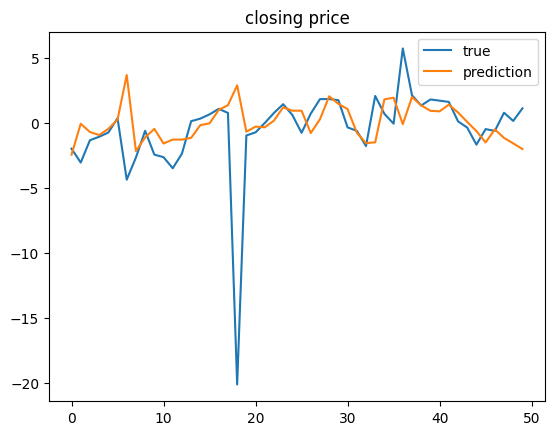

[MSE Baseline] train: 3.671535266407647  test: 4.68758521157695
Delta time with epochs = 1200: 0:19:41.727778
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_10 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 20)             0         
               

Time for epoch 51 is 1.124021053314209 sec Generator Loss: 0.7930188179016113,  Discriminator_loss: 1.3498328924179077
Time for epoch 52 is 1.0845592021942139 sec Generator Loss: 0.7969008684158325,  Discriminator_loss: 1.3539170026779175
Time for epoch 53 is 1.1484019756317139 sec Generator Loss: 0.7931717038154602,  Discriminator_loss: 1.347281813621521
Time for epoch 54 is 1.3525846004486084 sec Generator Loss: 0.798507034778595,  Discriminator_loss: 1.345395565032959
Time for epoch 55 is 1.174093246459961 sec Generator Loss: 0.800595760345459,  Discriminator_loss: 1.3435758352279663
Time for epoch 56 is 1.1135823726654053 sec Generator Loss: 0.8028139472007751,  Discriminator_loss: 1.3375623226165771
Time for epoch 57 is 1.09857177734375 sec Generator Loss: 0.7995125651359558,  Discriminator_loss: 1.3484655618667603
Time for epoch 58 is 1.182488203048706 sec Generator Loss: 0.7926818132400513,  Discriminator_loss: 1.365308403968811
Time for epoch 59 is 1.1506831645965576 sec Genera

Time for epoch 120 is 1.078357219696045 sec Generator Loss: 0.7842252850532532,  Discriminator_loss: 1.3563055992126465
Time for epoch 121 is 1.0392272472381592 sec Generator Loss: 0.781392514705658,  Discriminator_loss: 1.3552473783493042
Time for epoch 122 is 0.992206335067749 sec Generator Loss: 0.7822327017784119,  Discriminator_loss: 1.3567616939544678
Time for epoch 123 is 0.9695765972137451 sec Generator Loss: 0.7781725525856018,  Discriminator_loss: 1.35403573513031
Time for epoch 124 is 0.9926269054412842 sec Generator Loss: 0.7774434685707092,  Discriminator_loss: 1.3569738864898682
Time for epoch 125 is 1.0003936290740967 sec Generator Loss: 0.7853989601135254,  Discriminator_loss: 1.3509129285812378
Time for epoch 126 is 0.9970991611480713 sec Generator Loss: 0.7826892137527466,  Discriminator_loss: 1.3549164533615112
Time for epoch 127 is 0.9983131885528564 sec Generator Loss: 0.783734917640686,  Discriminator_loss: 1.356264591217041
Time for epoch 128 is 0.994705915451049

Time for epoch 188 is 0.9362304210662842 sec Generator Loss: 0.7756455540657043,  Discriminator_loss: 1.3602452278137207
Time for epoch 189 is 0.9299118518829346 sec Generator Loss: 0.7703876495361328,  Discriminator_loss: 1.3616504669189453
Time for epoch 190 is 0.9363951683044434 sec Generator Loss: 0.7767453193664551,  Discriminator_loss: 1.358005166053772
Time for epoch 191 is 0.9320218563079834 sec Generator Loss: 0.7771884202957153,  Discriminator_loss: 1.3620353937149048
Time for epoch 192 is 0.9323267936706543 sec Generator Loss: 0.7761549353599548,  Discriminator_loss: 1.3621373176574707
Time for epoch 193 is 0.9257190227508545 sec Generator Loss: 0.779719889163971,  Discriminator_loss: 1.3616323471069336
Time for epoch 194 is 0.9414987564086914 sec Generator Loss: 0.7736085653305054,  Discriminator_loss: 1.3642741441726685
Time for epoch 195 is 0.9390349388122559 sec Generator Loss: 0.7777885794639587,  Discriminator_loss: 1.3593367338180542
Time for epoch 196 is 0.9163141250

Time for epoch 256 is 0.9236197471618652 sec Generator Loss: 0.781474232673645,  Discriminator_loss: 1.3502655029296875
Time for epoch 257 is 0.938971757888794 sec Generator Loss: 0.7863767147064209,  Discriminator_loss: 1.3518407344818115
Time for epoch 258 is 0.935077428817749 sec Generator Loss: 0.7795032262802124,  Discriminator_loss: 1.3596011400222778
Time for epoch 259 is 0.984877347946167 sec Generator Loss: 0.7803144454956055,  Discriminator_loss: 1.3583781719207764
Time for epoch 260 is 0.984900951385498 sec Generator Loss: 0.7823653817176819,  Discriminator_loss: 1.352163553237915
Time for epoch 261 is 0.9753682613372803 sec Generator Loss: 0.7806410193443298,  Discriminator_loss: 1.3524155616760254
Time for epoch 262 is 1.0104467868804932 sec Generator Loss: 0.7817566990852356,  Discriminator_loss: 1.3518716096878052
Time for epoch 263 is 1.0173966884613037 sec Generator Loss: 0.7827968001365662,  Discriminator_loss: 1.3450568914413452
Time for epoch 264 is 1.00951147079467

Time for epoch 325 is 1.1234641075134277 sec Generator Loss: 0.7848143577575684,  Discriminator_loss: 1.3555470705032349
Time for epoch 326 is 1.0967903137207031 sec Generator Loss: 0.787988007068634,  Discriminator_loss: 1.3487987518310547
Time for epoch 327 is 1.1047673225402832 sec Generator Loss: 0.7862526774406433,  Discriminator_loss: 1.34764564037323
Time for epoch 328 is 1.0756385326385498 sec Generator Loss: 0.7822234034538269,  Discriminator_loss: 1.3551682233810425
Time for epoch 329 is 1.084646224975586 sec Generator Loss: 0.7926329970359802,  Discriminator_loss: 1.348803162574768
Time for epoch 330 is 1.0322606563568115 sec Generator Loss: 0.7900031208992004,  Discriminator_loss: 1.3494789600372314
Time for epoch 331 is 0.9380486011505127 sec Generator Loss: 0.7868454456329346,  Discriminator_loss: 1.3482123613357544
Time for epoch 332 is 1.0311012268066406 sec Generator Loss: 0.786668598651886,  Discriminator_loss: 1.3461158275604248
Time for epoch 333 is 0.98310351371765

Time for epoch 394 is 0.9516909122467041 sec Generator Loss: 0.791714072227478,  Discriminator_loss: 1.346640944480896
Time for epoch 395 is 0.9778947830200195 sec Generator Loss: 0.7862834334373474,  Discriminator_loss: 1.3508870601654053
Time for epoch 396 is 0.9720568656921387 sec Generator Loss: 0.7945263385772705,  Discriminator_loss: 1.342029333114624
Time for epoch 397 is 0.9707069396972656 sec Generator Loss: 0.7963581681251526,  Discriminator_loss: 1.3430984020233154
Time for epoch 398 is 0.9473819732666016 sec Generator Loss: 0.7973718643188477,  Discriminator_loss: 1.3486073017120361
Time for epoch 399 is 0.9530665874481201 sec Generator Loss: 0.7982852458953857,  Discriminator_loss: 1.3422116041183472
Time for epoch 400 is 0.9483449459075928 sec Generator Loss: 0.7915066480636597,  Discriminator_loss: 1.34078848361969
Time for epoch 401 is 0.9548802375793457 sec Generator Loss: 0.79576176404953,  Discriminator_loss: 1.3430489301681519
Time for epoch 402 is 0.946323633193969

Time for epoch 463 is 0.9399516582489014 sec Generator Loss: 0.8007688522338867,  Discriminator_loss: 1.3446359634399414
Time for epoch 464 is 0.9452321529388428 sec Generator Loss: 0.8023457527160645,  Discriminator_loss: 1.3368275165557861
Time for epoch 465 is 0.9262866973876953 sec Generator Loss: 0.7928513884544373,  Discriminator_loss: 1.3403056859970093
Time for epoch 466 is 0.9308600425720215 sec Generator Loss: 0.8000310063362122,  Discriminator_loss: 1.341599941253662
Time for epoch 467 is 0.938525915145874 sec Generator Loss: 0.791492223739624,  Discriminator_loss: 1.353009819984436
Time for epoch 468 is 0.9420442581176758 sec Generator Loss: 0.7990992069244385,  Discriminator_loss: 1.3443126678466797
Time for epoch 469 is 0.9572691917419434 sec Generator Loss: 0.7976365089416504,  Discriminator_loss: 1.3409149646759033
Time for epoch 470 is 0.9479310512542725 sec Generator Loss: 0.8011183738708496,  Discriminator_loss: 1.338672161102295
Time for epoch 471 is 0.9843721389770

Time for epoch 532 is 0.847569465637207 sec Generator Loss: 0.8088599443435669,  Discriminator_loss: 1.335577130317688
Time for epoch 533 is 0.8541288375854492 sec Generator Loss: 0.7918894290924072,  Discriminator_loss: 1.3492188453674316
Time for epoch 534 is 0.8465113639831543 sec Generator Loss: 0.7997536659240723,  Discriminator_loss: 1.335191249847412
Time for epoch 535 is 0.845637321472168 sec Generator Loss: 0.7978824973106384,  Discriminator_loss: 1.3476780652999878
Time for epoch 536 is 0.8574154376983643 sec Generator Loss: 0.8016310930252075,  Discriminator_loss: 1.337896466255188
Time for epoch 537 is 0.8647394180297852 sec Generator Loss: 0.8018918037414551,  Discriminator_loss: 1.3350759744644165
Time for epoch 538 is 0.8450403213500977 sec Generator Loss: 0.7981835007667542,  Discriminator_loss: 1.3427883386611938
Time for epoch 539 is 0.8465967178344727 sec Generator Loss: 0.8057228922843933,  Discriminator_loss: 1.3420007228851318
Time for epoch 540 is 0.8532674312591

Time for epoch 601 is 1.1178083419799805 sec Generator Loss: 0.812243640422821,  Discriminator_loss: 1.3312917947769165
Time for epoch 602 is 1.059131145477295 sec Generator Loss: 0.8133999109268188,  Discriminator_loss: 1.3367137908935547
Time for epoch 603 is 1.0697789192199707 sec Generator Loss: 0.8084934949874878,  Discriminator_loss: 1.328091025352478
Time for epoch 604 is 1.2493696212768555 sec Generator Loss: 0.82109135389328,  Discriminator_loss: 1.3320478200912476
Time for epoch 605 is 1.2594900131225586 sec Generator Loss: 0.8124375343322754,  Discriminator_loss: 1.3377732038497925
Time for epoch 606 is 1.0874404907226562 sec Generator Loss: 0.8105365633964539,  Discriminator_loss: 1.332774043083191
Time for epoch 607 is 1.1783215999603271 sec Generator Loss: 0.8100343942642212,  Discriminator_loss: 1.338572382926941
Time for epoch 608 is 1.0165081024169922 sec Generator Loss: 0.807659924030304,  Discriminator_loss: 1.3347735404968262
Time for epoch 609 is 0.9897181987762451

Time for epoch 670 is 1.0253980159759521 sec Generator Loss: 0.8099220395088196,  Discriminator_loss: 1.329880952835083
Time for epoch 671 is 1.0089001655578613 sec Generator Loss: 0.8136360049247742,  Discriminator_loss: 1.3337266445159912
Time for epoch 672 is 1.0493488311767578 sec Generator Loss: 0.8145685195922852,  Discriminator_loss: 1.3293200731277466
Time for epoch 673 is 0.9885027408599854 sec Generator Loss: 0.8099841475486755,  Discriminator_loss: 1.340317964553833
Time for epoch 674 is 1.0007154941558838 sec Generator Loss: 0.8020861148834229,  Discriminator_loss: 1.3482539653778076
Time for epoch 675 is 0.9911096096038818 sec Generator Loss: 0.8074967861175537,  Discriminator_loss: 1.3267040252685547
Time for epoch 676 is 1.046872615814209 sec Generator Loss: 0.8095565438270569,  Discriminator_loss: 1.3368908166885376
Time for epoch 677 is 1.0802359580993652 sec Generator Loss: 0.8156176209449768,  Discriminator_loss: 1.3320468664169312
Time for epoch 678 is 1.08475565910

Time for epoch 739 is 1.3170175552368164 sec Generator Loss: 0.8153277039527893,  Discriminator_loss: 1.3334202766418457
Time for epoch 740 is 1.2062993049621582 sec Generator Loss: 0.807732343673706,  Discriminator_loss: 1.3383195400238037
Time for epoch 741 is 1.2479095458984375 sec Generator Loss: 0.8136292099952698,  Discriminator_loss: 1.330655813217163
Time for epoch 742 is 1.0162932872772217 sec Generator Loss: 0.8097112774848938,  Discriminator_loss: 1.3302253484725952
Time for epoch 743 is 1.2772583961486816 sec Generator Loss: 0.8090639710426331,  Discriminator_loss: 1.3356040716171265
Time for epoch 744 is 1.1797378063201904 sec Generator Loss: 0.8086613416671753,  Discriminator_loss: 1.3370511531829834
Time for epoch 745 is 1.0303547382354736 sec Generator Loss: 0.8034725189208984,  Discriminator_loss: 1.3377403020858765
Time for epoch 746 is 1.0973045825958252 sec Generator Loss: 0.8055728077888489,  Discriminator_loss: 1.3359631299972534
Time for epoch 747 is 1.0440995693

Time for epoch 808 is 0.9524950981140137 sec Generator Loss: 0.8192328810691833,  Discriminator_loss: 1.3234776258468628
Time for epoch 809 is 1.2386457920074463 sec Generator Loss: 0.8220388293266296,  Discriminator_loss: 1.3265316486358643
Time for epoch 810 is 1.0815980434417725 sec Generator Loss: 0.8215966820716858,  Discriminator_loss: 1.3271433115005493
Time for epoch 811 is 1.0868158340454102 sec Generator Loss: 0.808764636516571,  Discriminator_loss: 1.3334301710128784
Time for epoch 812 is 0.9452922344207764 sec Generator Loss: 0.8083839416503906,  Discriminator_loss: 1.3291065692901611
Time for epoch 813 is 0.952958345413208 sec Generator Loss: 0.8060373663902283,  Discriminator_loss: 1.333300232887268
Time for epoch 814 is 0.9717113971710205 sec Generator Loss: 0.8183856010437012,  Discriminator_loss: 1.3322930335998535
Time for epoch 815 is 0.9605457782745361 sec Generator Loss: 0.8175985217094421,  Discriminator_loss: 1.328840732574463
Time for epoch 816 is 0.936074256896

Time for epoch 876 is 1.0957818031311035 sec Generator Loss: 0.8133156895637512,  Discriminator_loss: 1.332170009613037
Time for epoch 877 is 1.009995460510254 sec Generator Loss: 0.8166804313659668,  Discriminator_loss: 1.3275567293167114
Time for epoch 878 is 1.0478951930999756 sec Generator Loss: 0.8016030788421631,  Discriminator_loss: 1.3421181440353394
Time for epoch 879 is 1.0232155323028564 sec Generator Loss: 0.816927969455719,  Discriminator_loss: 1.3274856805801392
Time for epoch 880 is 1.0279223918914795 sec Generator Loss: 0.814786970615387,  Discriminator_loss: 1.3250892162322998
Time for epoch 881 is 1.0630695819854736 sec Generator Loss: 0.8206517100334167,  Discriminator_loss: 1.3302361965179443
Time for epoch 882 is 0.957080602645874 sec Generator Loss: 0.8074650168418884,  Discriminator_loss: 1.3318510055541992
Time for epoch 883 is 0.9870457649230957 sec Generator Loss: 0.8176550269126892,  Discriminator_loss: 1.3344238996505737
Time for epoch 884 is 1.0623924732208

Time for epoch 945 is 1.0652027130126953 sec Generator Loss: 0.8149558901786804,  Discriminator_loss: 1.3362500667572021
Time for epoch 946 is 1.0869643688201904 sec Generator Loss: 0.8098406791687012,  Discriminator_loss: 1.331067442893982
Time for epoch 947 is 1.3419055938720703 sec Generator Loss: 0.8137505650520325,  Discriminator_loss: 1.336716651916504
Time for epoch 948 is 1.1158552169799805 sec Generator Loss: 0.8080389499664307,  Discriminator_loss: 1.3392640352249146
Time for epoch 949 is 1.0832901000976562 sec Generator Loss: 0.8131877183914185,  Discriminator_loss: 1.3418093919754028
Time for epoch 950 is 1.0702664852142334 sec Generator Loss: 0.8078712224960327,  Discriminator_loss: 1.339354395866394
Time for epoch 951 is 1.2465267181396484 sec Generator Loss: 0.8104775547981262,  Discriminator_loss: 1.3344213962554932
Time for epoch 952 is 1.3341116905212402 sec Generator Loss: 0.8133659958839417,  Discriminator_loss: 1.3367302417755127
Time for epoch 953 is 1.52206873893

Time for epoch 1013 is 1.1136186122894287 sec Generator Loss: 0.8093849420547485,  Discriminator_loss: 1.333933711051941
Time for epoch 1014 is 1.088083267211914 sec Generator Loss: 0.8046541810035706,  Discriminator_loss: 1.337680459022522
Time for epoch 1015 is 1.0935237407684326 sec Generator Loss: 0.8074530959129333,  Discriminator_loss: 1.3396300077438354
Time for epoch 1016 is 1.1122219562530518 sec Generator Loss: 0.8045447468757629,  Discriminator_loss: 1.3349379301071167
Time for epoch 1017 is 1.0961642265319824 sec Generator Loss: 0.810161292552948,  Discriminator_loss: 1.342018723487854
Time for epoch 1018 is 1.0489225387573242 sec Generator Loss: 0.7995434999465942,  Discriminator_loss: 1.3435310125350952
Time for epoch 1019 is 1.0350801944732666 sec Generator Loss: 0.8133954405784607,  Discriminator_loss: 1.3316409587860107
Time for epoch 1020 is 1.038160800933838 sec Generator Loss: 0.8077712655067444,  Discriminator_loss: 1.342591404914856
Time for epoch 1021 is 1.069181

Time for epoch 1081 is 0.9982290267944336 sec Generator Loss: 0.8098621964454651,  Discriminator_loss: 1.3348137140274048
Time for epoch 1082 is 1.0028440952301025 sec Generator Loss: 0.8033917546272278,  Discriminator_loss: 1.3405311107635498
Time for epoch 1083 is 1.0039701461791992 sec Generator Loss: 0.7988279461860657,  Discriminator_loss: 1.3448530435562134
Time for epoch 1084 is 1.0162920951843262 sec Generator Loss: 0.8108248114585876,  Discriminator_loss: 1.3384428024291992
Time for epoch 1085 is 1.0325243473052979 sec Generator Loss: 0.8040960431098938,  Discriminator_loss: 1.3361575603485107
Time for epoch 1086 is 1.0229058265686035 sec Generator Loss: 0.8069309592247009,  Discriminator_loss: 1.3410041332244873
Time for epoch 1087 is 1.030519962310791 sec Generator Loss: 0.8148274421691895,  Discriminator_loss: 1.3334524631500244
Time for epoch 1088 is 1.0053353309631348 sec Generator Loss: 0.8055137991905212,  Discriminator_loss: 1.343446135520935
Time for epoch 1089 is 1.0

Time for epoch 1149 is 1.0175135135650635 sec Generator Loss: 0.7999311685562134,  Discriminator_loss: 1.3423869609832764
Time for epoch 1150 is 1.0111126899719238 sec Generator Loss: 0.8114559650421143,  Discriminator_loss: 1.3336330652236938
Time for epoch 1151 is 1.0235028266906738 sec Generator Loss: 0.8097789287567139,  Discriminator_loss: 1.338294267654419
Time for epoch 1152 is 1.0278301239013672 sec Generator Loss: 0.8119744062423706,  Discriminator_loss: 1.3373106718063354
Time for epoch 1153 is 1.002962350845337 sec Generator Loss: 0.8068212866783142,  Discriminator_loss: 1.3404842615127563
Time for epoch 1154 is 1.0049593448638916 sec Generator Loss: 0.8084051609039307,  Discriminator_loss: 1.3396222591400146
Time for epoch 1155 is 0.9824662208557129 sec Generator Loss: 0.8023931384086609,  Discriminator_loss: 1.344171166419983
Time for epoch 1156 is 1.0233433246612549 sec Generator Loss: 0.8034356236457825,  Discriminator_loss: 1.3416529893875122
Time for epoch 1157 is 1.03

Time for epoch 1217 is 1.0253212451934814 sec Generator Loss: 0.8092014193534851,  Discriminator_loss: 1.3355485200881958
Time for epoch 1218 is 1.0427377223968506 sec Generator Loss: 0.7993825078010559,  Discriminator_loss: 1.3479984998703003
Time for epoch 1219 is 1.0845766067504883 sec Generator Loss: 0.8097577691078186,  Discriminator_loss: 1.3402854204177856
Time for epoch 1220 is 1.032578468322754 sec Generator Loss: 0.7998791933059692,  Discriminator_loss: 1.3408657312393188
Time for epoch 1221 is 1.0167460441589355 sec Generator Loss: 0.8013153076171875,  Discriminator_loss: 1.3338369131088257
Time for epoch 1222 is 1.0573015213012695 sec Generator Loss: 0.8132718801498413,  Discriminator_loss: 1.3367868661880493
Time for epoch 1223 is 1.0409455299377441 sec Generator Loss: 0.8040360808372498,  Discriminator_loss: 1.3465029001235962
Time for epoch 1224 is 1.043684720993042 sec Generator Loss: 0.8066909313201904,  Discriminator_loss: 1.3399931192398071
Time for epoch 1225 is 1.0

Time for epoch 1285 is 0.9372880458831787 sec Generator Loss: 0.800903856754303,  Discriminator_loss: 1.3451708555221558
Time for epoch 1286 is 0.9454751014709473 sec Generator Loss: 0.8026309609413147,  Discriminator_loss: 1.341331958770752
Time for epoch 1287 is 0.9492228031158447 sec Generator Loss: 0.7994045615196228,  Discriminator_loss: 1.3405650854110718
Time for epoch 1288 is 0.9681880474090576 sec Generator Loss: 0.7932746410369873,  Discriminator_loss: 1.3505345582962036
Time for epoch 1289 is 0.9542348384857178 sec Generator Loss: 0.7988294959068298,  Discriminator_loss: 1.3398151397705078
Time for epoch 1290 is 0.9600028991699219 sec Generator Loss: 0.8073447346687317,  Discriminator_loss: 1.341034173965454
Time for epoch 1291 is 0.9521245956420898 sec Generator Loss: 0.8014712929725647,  Discriminator_loss: 1.3376041650772095
Time for epoch 1292 is 0.978377103805542 sec Generator Loss: 0.8047930002212524,  Discriminator_loss: 1.3388302326202393
Time for epoch 1293 is 0.976

Time for epoch 1353 is 0.9480383396148682 sec Generator Loss: 0.8026619553565979,  Discriminator_loss: 1.3441195487976074
Time for epoch 1354 is 0.9937798976898193 sec Generator Loss: 0.8038934469223022,  Discriminator_loss: 1.3389333486557007
Time for epoch 1355 is 0.961306095123291 sec Generator Loss: 0.809220552444458,  Discriminator_loss: 1.342191457748413
Time for epoch 1356 is 0.956244707107544 sec Generator Loss: 0.8213792443275452,  Discriminator_loss: 1.3365596532821655
Time for epoch 1357 is 0.9505040645599365 sec Generator Loss: 0.8018919229507446,  Discriminator_loss: 1.342808485031128
Time for epoch 1358 is 0.9588220119476318 sec Generator Loss: 0.8093332052230835,  Discriminator_loss: 1.3363510370254517
Time for epoch 1359 is 0.972590446472168 sec Generator Loss: 0.8082469701766968,  Discriminator_loss: 1.3371140956878662
Time for epoch 1360 is 0.9562015533447266 sec Generator Loss: 0.7981717586517334,  Discriminator_loss: 1.34690523147583
Time for epoch 1361 is 1.0109121

Time for epoch 1421 is 1.047020435333252 sec Generator Loss: 0.796119213104248,  Discriminator_loss: 1.3439816236495972
Time for epoch 1422 is 1.091043472290039 sec Generator Loss: 0.7965666651725769,  Discriminator_loss: 1.342872142791748
Time for epoch 1423 is 1.1403861045837402 sec Generator Loss: 0.8022388815879822,  Discriminator_loss: 1.3431448936462402
Time for epoch 1424 is 1.0812108516693115 sec Generator Loss: 0.7956666946411133,  Discriminator_loss: 1.3471239805221558
Time for epoch 1425 is 1.1061389446258545 sec Generator Loss: 0.7994601130485535,  Discriminator_loss: 1.3436588048934937
Time for epoch 1426 is 1.0496456623077393 sec Generator Loss: 0.8041227459907532,  Discriminator_loss: 1.3409613370895386
Time for epoch 1427 is 1.051694393157959 sec Generator Loss: 0.8019272685050964,  Discriminator_loss: 1.3447096347808838
Time for epoch 1428 is 1.040384292602539 sec Generator Loss: 0.7986360192298889,  Discriminator_loss: 1.342395544052124
Time for epoch 1429 is 1.026224

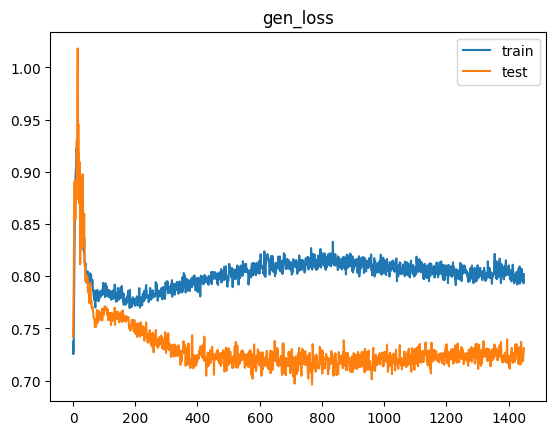

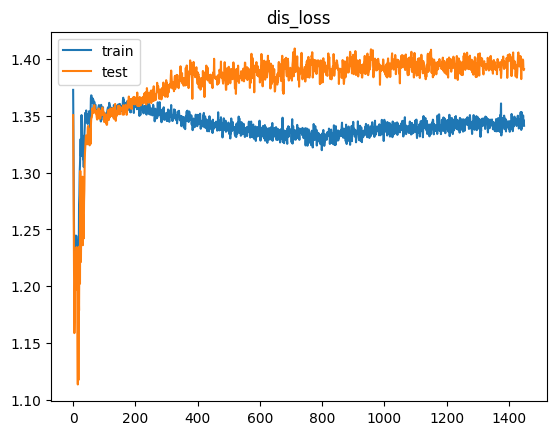

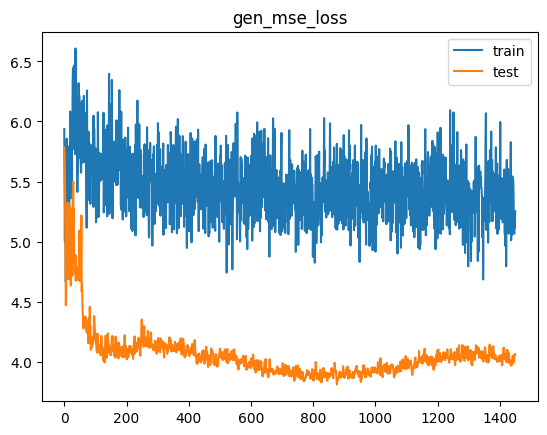

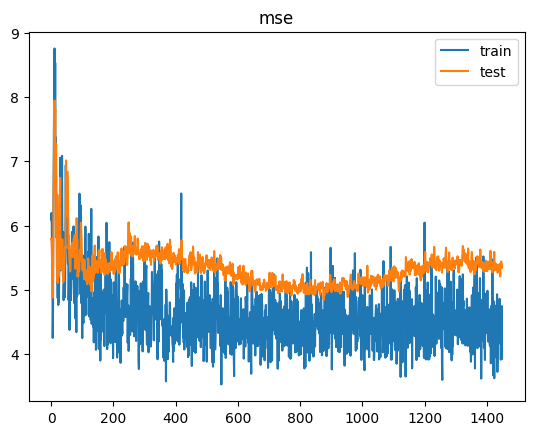

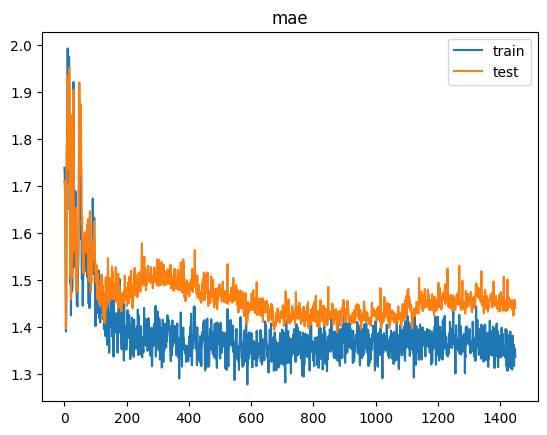

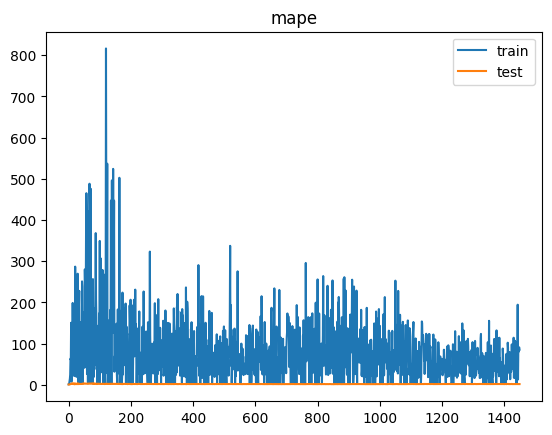

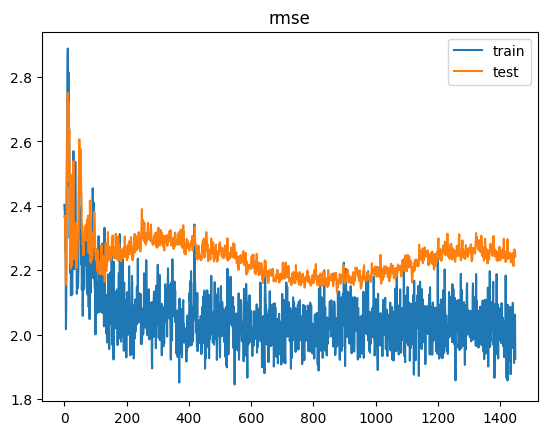

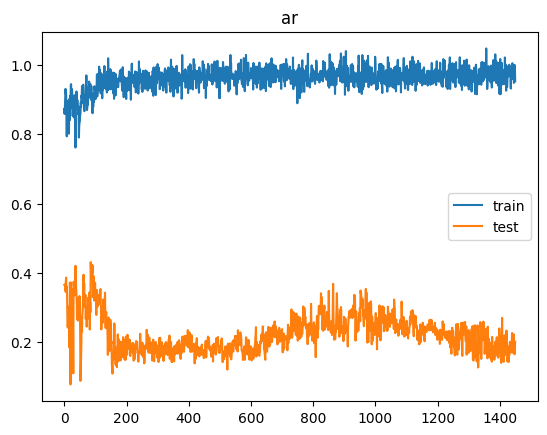

2/2 [==============================] - 1s 4ms/step


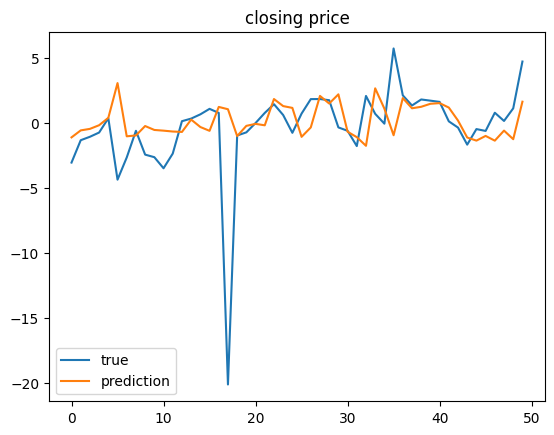

[MSE Baseline] train: 4.10273111322324  test: 4.695498675820508
Delta time with epochs = 1450: 0:25:12.748489
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_12 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 20)             0         
               

Time for epoch 51 is 1.0609021186828613 sec Generator Loss: 0.7931115627288818,  Discriminator_loss: 1.3523741960525513
Time for epoch 52 is 1.0583782196044922 sec Generator Loss: 0.7909477353096008,  Discriminator_loss: 1.3563998937606812
Time for epoch 53 is 1.036642074584961 sec Generator Loss: 0.7836190462112427,  Discriminator_loss: 1.3626747131347656
Time for epoch 54 is 1.2008988857269287 sec Generator Loss: 0.7932806015014648,  Discriminator_loss: 1.3590633869171143
Time for epoch 55 is 1.094484806060791 sec Generator Loss: 0.797610878944397,  Discriminator_loss: 1.362127423286438
Time for epoch 56 is 1.2968623638153076 sec Generator Loss: 0.7987557649612427,  Discriminator_loss: 1.3611396551132202
Time for epoch 57 is 1.3884365558624268 sec Generator Loss: 0.7980967164039612,  Discriminator_loss: 1.3585554361343384
Time for epoch 58 is 1.1871778964996338 sec Generator Loss: 0.7924349904060364,  Discriminator_loss: 1.3649060726165771
Time for epoch 59 is 1.0310590267181396 sec 

Time for epoch 120 is 1.28619384765625 sec Generator Loss: 0.7695834040641785,  Discriminator_loss: 1.3653838634490967
Time for epoch 121 is 1.288825511932373 sec Generator Loss: 0.7716723680496216,  Discriminator_loss: 1.3623411655426025
Time for epoch 122 is 1.1567111015319824 sec Generator Loss: 0.7725900411605835,  Discriminator_loss: 1.3650400638580322
Time for epoch 123 is 0.9837336540222168 sec Generator Loss: 0.7640796303749084,  Discriminator_loss: 1.3692797422409058
Time for epoch 124 is 1.0164895057678223 sec Generator Loss: 0.7726210951805115,  Discriminator_loss: 1.3618664741516113
Time for epoch 125 is 1.003086805343628 sec Generator Loss: 0.7700416445732117,  Discriminator_loss: 1.3635727167129517
Time for epoch 126 is 1.0747768878936768 sec Generator Loss: 0.7731930613517761,  Discriminator_loss: 1.3629390001296997
Time for epoch 127 is 1.1757516860961914 sec Generator Loss: 0.7654117345809937,  Discriminator_loss: 1.364907145500183
Time for epoch 128 is 1.0141422748565

Time for epoch 189 is 0.9515619277954102 sec Generator Loss: 0.767292857170105,  Discriminator_loss: 1.3632537126541138
Time for epoch 190 is 0.9696707725524902 sec Generator Loss: 0.764834463596344,  Discriminator_loss: 1.3653336763381958
Time for epoch 191 is 0.9428050518035889 sec Generator Loss: 0.7591439485549927,  Discriminator_loss: 1.3635492324829102
Time for epoch 192 is 0.9471385478973389 sec Generator Loss: 0.7654904127120972,  Discriminator_loss: 1.362312912940979
Time for epoch 193 is 0.9615755081176758 sec Generator Loss: 0.7713908553123474,  Discriminator_loss: 1.367431402206421
Time for epoch 194 is 0.9465136528015137 sec Generator Loss: 0.7688054442405701,  Discriminator_loss: 1.368496060371399
Time for epoch 195 is 0.9432411193847656 sec Generator Loss: 0.7715492248535156,  Discriminator_loss: 1.3669296503067017
Time for epoch 196 is 0.9500248432159424 sec Generator Loss: 0.7717771530151367,  Discriminator_loss: 1.361793041229248
Time for epoch 197 is 1.07998299598693

Time for epoch 258 is 0.9683928489685059 sec Generator Loss: 0.7762806415557861,  Discriminator_loss: 1.360274076461792
Time for epoch 259 is 0.9932882785797119 sec Generator Loss: 0.7718677520751953,  Discriminator_loss: 1.3623605966567993
Time for epoch 260 is 1.0664713382720947 sec Generator Loss: 0.7729995250701904,  Discriminator_loss: 1.358273983001709
Time for epoch 261 is 0.9915499687194824 sec Generator Loss: 0.7678230404853821,  Discriminator_loss: 1.365246295928955
Time for epoch 262 is 1.0286331176757812 sec Generator Loss: 0.7758222818374634,  Discriminator_loss: 1.3618426322937012
Time for epoch 263 is 0.9424576759338379 sec Generator Loss: 0.7715656757354736,  Discriminator_loss: 1.363755464553833
Time for epoch 264 is 1.0017049312591553 sec Generator Loss: 0.7767834663391113,  Discriminator_loss: 1.3586949110031128
Time for epoch 265 is 0.9404850006103516 sec Generator Loss: 0.7769886255264282,  Discriminator_loss: 1.3603640794754028
Time for epoch 266 is 1.065829038619

Time for epoch 326 is 0.9581887722015381 sec Generator Loss: 0.7791616916656494,  Discriminator_loss: 1.3550165891647339
Time for epoch 327 is 1.0027763843536377 sec Generator Loss: 0.782524049282074,  Discriminator_loss: 1.3559843301773071
Time for epoch 328 is 0.9757692813873291 sec Generator Loss: 0.7795249223709106,  Discriminator_loss: 1.3568623065948486
Time for epoch 329 is 1.0286626815795898 sec Generator Loss: 0.7865934371948242,  Discriminator_loss: 1.3548328876495361
Time for epoch 330 is 1.0075230598449707 sec Generator Loss: 0.7739227414131165,  Discriminator_loss: 1.3578786849975586
Time for epoch 331 is 1.008582592010498 sec Generator Loss: 0.7773895263671875,  Discriminator_loss: 1.3525303602218628
Time for epoch 332 is 0.939612627029419 sec Generator Loss: 0.7751483917236328,  Discriminator_loss: 1.3564934730529785
Time for epoch 333 is 0.9764289855957031 sec Generator Loss: 0.7807549834251404,  Discriminator_loss: 1.3507080078125
Time for epoch 334 is 0.96141791343688

Time for epoch 395 is 1.0613648891448975 sec Generator Loss: 0.7834951281547546,  Discriminator_loss: 1.3537392616271973
Time for epoch 396 is 0.9984087944030762 sec Generator Loss: 0.778986394405365,  Discriminator_loss: 1.3583236932754517
Time for epoch 397 is 1.052863597869873 sec Generator Loss: 0.7807894349098206,  Discriminator_loss: 1.35226309299469
Time for epoch 398 is 0.9987471103668213 sec Generator Loss: 0.7803729176521301,  Discriminator_loss: 1.3551510572433472
Time for epoch 399 is 0.987215518951416 sec Generator Loss: 0.7820247411727905,  Discriminator_loss: 1.3546512126922607
Time for epoch 400 is 0.9842987060546875 sec Generator Loss: 0.7770322561264038,  Discriminator_loss: 1.3563097715377808
Time for epoch 401 is 1.022191047668457 sec Generator Loss: 0.785834014415741,  Discriminator_loss: 1.3509125709533691
Time for epoch 402 is 1.0187652111053467 sec Generator Loss: 0.7865382432937622,  Discriminator_loss: 1.3520749807357788
Time for epoch 403 is 1.005048036575317

Time for epoch 464 is 1.0057950019836426 sec Generator Loss: 0.784217357635498,  Discriminator_loss: 1.3518002033233643
Time for epoch 465 is 1.0032992362976074 sec Generator Loss: 0.781063973903656,  Discriminator_loss: 1.3491591215133667
Time for epoch 466 is 1.0665645599365234 sec Generator Loss: 0.7881036996841431,  Discriminator_loss: 1.3465548753738403
Time for epoch 467 is 1.0440866947174072 sec Generator Loss: 0.7796010375022888,  Discriminator_loss: 1.3520357608795166
Time for epoch 468 is 0.9854640960693359 sec Generator Loss: 0.7824741005897522,  Discriminator_loss: 1.3493595123291016
Time for epoch 469 is 0.9801158905029297 sec Generator Loss: 0.7860045433044434,  Discriminator_loss: 1.3468680381774902
Time for epoch 470 is 0.9785192012786865 sec Generator Loss: 0.785905659198761,  Discriminator_loss: 1.3526644706726074
Time for epoch 471 is 1.0117006301879883 sec Generator Loss: 0.7892748117446899,  Discriminator_loss: 1.350772500038147
Time for epoch 472 is 1.009059667587

Time for epoch 532 is 1.0115232467651367 sec Generator Loss: 0.7926087975502014,  Discriminator_loss: 1.3480744361877441
Time for epoch 533 is 1.0388307571411133 sec Generator Loss: 0.7990880608558655,  Discriminator_loss: 1.3469445705413818
Time for epoch 534 is 0.9901649951934814 sec Generator Loss: 0.7843590974807739,  Discriminator_loss: 1.3563021421432495
Time for epoch 535 is 1.0133552551269531 sec Generator Loss: 0.7909783124923706,  Discriminator_loss: 1.3491052389144897
Time for epoch 536 is 1.0315885543823242 sec Generator Loss: 0.7830761671066284,  Discriminator_loss: 1.3507670164108276
Time for epoch 537 is 0.9846639633178711 sec Generator Loss: 0.7876798510551453,  Discriminator_loss: 1.3507884740829468
Time for epoch 538 is 0.9866876602172852 sec Generator Loss: 0.7888055443763733,  Discriminator_loss: 1.3450959920883179
Time for epoch 539 is 1.0332987308502197 sec Generator Loss: 0.7894963026046753,  Discriminator_loss: 1.350343942642212
Time for epoch 540 is 1.030399322

Time for epoch 601 is 0.9818480014801025 sec Generator Loss: 0.7904402017593384,  Discriminator_loss: 1.3487235307693481
Time for epoch 602 is 0.9807279109954834 sec Generator Loss: 0.7968236804008484,  Discriminator_loss: 1.342045545578003
Time for epoch 603 is 1.0243165493011475 sec Generator Loss: 0.7948275208473206,  Discriminator_loss: 1.3454570770263672
Time for epoch 604 is 1.0471258163452148 sec Generator Loss: 0.7926463484764099,  Discriminator_loss: 1.345362663269043
Time for epoch 605 is 1.0346643924713135 sec Generator Loss: 0.7902937531471252,  Discriminator_loss: 1.3519189357757568
Time for epoch 606 is 1.0204079151153564 sec Generator Loss: 0.7924957275390625,  Discriminator_loss: 1.3462070226669312
Time for epoch 607 is 1.057342529296875 sec Generator Loss: 0.7957476377487183,  Discriminator_loss: 1.3423224687576294
Time for epoch 608 is 1.0526549816131592 sec Generator Loss: 0.7917670011520386,  Discriminator_loss: 1.3519093990325928
Time for epoch 609 is 1.03175687789

Time for epoch 670 is 0.9954724311828613 sec Generator Loss: 0.7930362820625305,  Discriminator_loss: 1.3521029949188232
Time for epoch 671 is 0.9820947647094727 sec Generator Loss: 0.7915403246879578,  Discriminator_loss: 1.350131869316101
Time for epoch 672 is 1.0108373165130615 sec Generator Loss: 0.792804479598999,  Discriminator_loss: 1.34980309009552
Time for epoch 673 is 1.029736042022705 sec Generator Loss: 0.795701801776886,  Discriminator_loss: 1.3469202518463135
Time for epoch 674 is 1.072028398513794 sec Generator Loss: 0.8030556440353394,  Discriminator_loss: 1.344083309173584
Time for epoch 675 is 1.0265777111053467 sec Generator Loss: 0.7902567386627197,  Discriminator_loss: 1.3448160886764526
Time for epoch 676 is 1.078657865524292 sec Generator Loss: 0.79783034324646,  Discriminator_loss: 1.341263771057129
Time for epoch 677 is 1.0534875392913818 sec Generator Loss: 0.7934552431106567,  Discriminator_loss: 1.3453105688095093
Time for epoch 678 is 1.0692591667175293 sec

Time for epoch 739 is 1.1074914932250977 sec Generator Loss: 0.7969967722892761,  Discriminator_loss: 1.3477017879486084
Time for epoch 740 is 1.0720372200012207 sec Generator Loss: 0.7971544861793518,  Discriminator_loss: 1.3498669862747192
Time for epoch 741 is 0.9926433563232422 sec Generator Loss: 0.8047141432762146,  Discriminator_loss: 1.3415974378585815
Time for epoch 742 is 1.0016796588897705 sec Generator Loss: 0.7952385544776917,  Discriminator_loss: 1.3555527925491333
Time for epoch 743 is 1.0257441997528076 sec Generator Loss: 0.7851290702819824,  Discriminator_loss: 1.3509478569030762
Time for epoch 744 is 1.0009267330169678 sec Generator Loss: 0.7893226146697998,  Discriminator_loss: 1.3504326343536377
Time for epoch 745 is 1.0049645900726318 sec Generator Loss: 0.7895117998123169,  Discriminator_loss: 1.3465262651443481
Time for epoch 746 is 0.9826028347015381 sec Generator Loss: 0.7934814691543579,  Discriminator_loss: 1.349514365196228
Time for epoch 747 is 0.984853029

Time for epoch 808 is 0.9216959476470947 sec Generator Loss: 0.7990896701812744,  Discriminator_loss: 1.3453702926635742
Time for epoch 809 is 0.9254195690155029 sec Generator Loss: 0.7964262366294861,  Discriminator_loss: 1.3536064624786377
Time for epoch 810 is 0.9396038055419922 sec Generator Loss: 0.7914491295814514,  Discriminator_loss: 1.3477588891983032
Time for epoch 811 is 0.9919662475585938 sec Generator Loss: 0.7935076355934143,  Discriminator_loss: 1.343909502029419
Time for epoch 812 is 0.9511771202087402 sec Generator Loss: 0.7979264855384827,  Discriminator_loss: 1.344075322151184
Time for epoch 813 is 1.0565078258514404 sec Generator Loss: 0.7900946140289307,  Discriminator_loss: 1.3552089929580688
Time for epoch 814 is 1.0003533363342285 sec Generator Loss: 0.7919502854347229,  Discriminator_loss: 1.3464173078536987
Time for epoch 815 is 0.9625530242919922 sec Generator Loss: 0.7935247421264648,  Discriminator_loss: 1.353621482849121
Time for epoch 816 is 0.95843291282

Time for epoch 877 is 1.0086596012115479 sec Generator Loss: 0.7871822714805603,  Discriminator_loss: 1.3526238203048706
Time for epoch 878 is 1.0173840522766113 sec Generator Loss: 0.7973361015319824,  Discriminator_loss: 1.3390495777130127
Time for epoch 879 is 1.0136897563934326 sec Generator Loss: 0.8078196048736572,  Discriminator_loss: 1.3478294610977173
Time for epoch 880 is 0.9932427406311035 sec Generator Loss: 0.7984655499458313,  Discriminator_loss: 1.3432936668395996
Time for epoch 881 is 1.0027873516082764 sec Generator Loss: 0.7918773293495178,  Discriminator_loss: 1.3505853414535522
Time for epoch 882 is 1.0180089473724365 sec Generator Loss: 0.7944057583808899,  Discriminator_loss: 1.3487178087234497
Time for epoch 883 is 1.0157904624938965 sec Generator Loss: 0.7894374132156372,  Discriminator_loss: 1.345001220703125
Time for epoch 884 is 1.0166854858398438 sec Generator Loss: 0.7958613634109497,  Discriminator_loss: 1.3458740711212158
Time for epoch 885 is 0.996223449

Time for epoch 945 is 1.0058331489562988 sec Generator Loss: 0.7978029251098633,  Discriminator_loss: 1.3459652662277222
Time for epoch 946 is 1.014657974243164 sec Generator Loss: 0.8008242249488831,  Discriminator_loss: 1.341431975364685
Time for epoch 947 is 1.016465663909912 sec Generator Loss: 0.7994514107704163,  Discriminator_loss: 1.3522820472717285
Time for epoch 948 is 1.0016345977783203 sec Generator Loss: 0.797398030757904,  Discriminator_loss: 1.3487297296524048
Time for epoch 949 is 1.0130622386932373 sec Generator Loss: 0.8005037903785706,  Discriminator_loss: 1.3451290130615234
Time for epoch 950 is 1.0488739013671875 sec Generator Loss: 0.7946711778640747,  Discriminator_loss: 1.3473201990127563
Time for epoch 951 is 1.0836231708526611 sec Generator Loss: 0.7909723520278931,  Discriminator_loss: 1.347463846206665
Time for epoch 952 is 1.026066541671753 sec Generator Loss: 0.7970201969146729,  Discriminator_loss: 1.3535451889038086
Time for epoch 953 is 1.14129734039306

Time for epoch 1013 is 1.0193111896514893 sec Generator Loss: 0.7914215326309204,  Discriminator_loss: 1.3478845357894897
Time for epoch 1014 is 1.038224458694458 sec Generator Loss: 0.7983300089836121,  Discriminator_loss: 1.3465403318405151
Time for epoch 1015 is 1.0079267024993896 sec Generator Loss: 0.7967033386230469,  Discriminator_loss: 1.3420593738555908
Time for epoch 1016 is 1.0161757469177246 sec Generator Loss: 0.793707013130188,  Discriminator_loss: 1.3444225788116455
Time for epoch 1017 is 1.0076913833618164 sec Generator Loss: 0.8016099333763123,  Discriminator_loss: 1.3462635278701782
Time for epoch 1018 is 1.0155019760131836 sec Generator Loss: 0.8003307580947876,  Discriminator_loss: 1.3487696647644043
Time for epoch 1019 is 1.0426902770996094 sec Generator Loss: 0.7954640984535217,  Discriminator_loss: 1.3503613471984863
Time for epoch 1020 is 1.0436742305755615 sec Generator Loss: 0.7964949011802673,  Discriminator_loss: 1.34478759765625
Time for epoch 1021 is 0.985

Time for epoch 1081 is 1.0163443088531494 sec Generator Loss: 0.7987777590751648,  Discriminator_loss: 1.3456079959869385
Time for epoch 1082 is 1.0415754318237305 sec Generator Loss: 0.7887713313102722,  Discriminator_loss: 1.3484070301055908
Time for epoch 1083 is 1.022615909576416 sec Generator Loss: 0.7861502766609192,  Discriminator_loss: 1.3559263944625854
Time for epoch 1084 is 1.0070559978485107 sec Generator Loss: 0.7885146737098694,  Discriminator_loss: 1.354905366897583
Time for epoch 1085 is 1.0097758769989014 sec Generator Loss: 0.7996066808700562,  Discriminator_loss: 1.346191167831421
Time for epoch 1086 is 1.018322467803955 sec Generator Loss: 0.7996379733085632,  Discriminator_loss: 1.3542660474777222
Time for epoch 1087 is 1.0419206619262695 sec Generator Loss: 0.7909163236618042,  Discriminator_loss: 1.351420283317566
Time for epoch 1088 is 1.0542404651641846 sec Generator Loss: 0.7975537180900574,  Discriminator_loss: 1.3480867147445679
Time for epoch 1089 is 1.0688

Time for epoch 1149 is 1.0177297592163086 sec Generator Loss: 0.7909870147705078,  Discriminator_loss: 1.3476790189743042
Time for epoch 1150 is 1.0278053283691406 sec Generator Loss: 0.7993927001953125,  Discriminator_loss: 1.3452825546264648
Time for epoch 1151 is 1.0359117984771729 sec Generator Loss: 0.8099021315574646,  Discriminator_loss: 1.3369355201721191
Time for epoch 1152 is 1.0217196941375732 sec Generator Loss: 0.8023104667663574,  Discriminator_loss: 1.3437345027923584
Time for epoch 1153 is 1.1707158088684082 sec Generator Loss: 0.7978789806365967,  Discriminator_loss: 1.3470183610916138
Time for epoch 1154 is 1.096705436706543 sec Generator Loss: 0.7985630035400391,  Discriminator_loss: 1.3500056266784668
Time for epoch 1155 is 1.0064804553985596 sec Generator Loss: 0.7919340133666992,  Discriminator_loss: 1.34689199924469
Time for epoch 1156 is 1.0132532119750977 sec Generator Loss: 0.7962428331375122,  Discriminator_loss: 1.352404236793518
Time for epoch 1157 is 1.024

Time for epoch 1217 is 1.0347545146942139 sec Generator Loss: 0.7937154769897461,  Discriminator_loss: 1.3524547815322876
Time for epoch 1218 is 1.031078577041626 sec Generator Loss: 0.7972139120101929,  Discriminator_loss: 1.3461105823516846
Time for epoch 1219 is 1.0306110382080078 sec Generator Loss: 0.7955465316772461,  Discriminator_loss: 1.3497167825698853
Time for epoch 1220 is 1.0713658332824707 sec Generator Loss: 0.7993648052215576,  Discriminator_loss: 1.3485922813415527
Time for epoch 1221 is 1.0654213428497314 sec Generator Loss: 0.7920011281967163,  Discriminator_loss: 1.3504695892333984
Time for epoch 1222 is 1.0716781616210938 sec Generator Loss: 0.7940534353256226,  Discriminator_loss: 1.3446063995361328
Time for epoch 1223 is 1.0978195667266846 sec Generator Loss: 0.7952265739440918,  Discriminator_loss: 1.3461439609527588
Time for epoch 1224 is 1.0332670211791992 sec Generator Loss: 0.8007121086120605,  Discriminator_loss: 1.3429590463638306
Time for epoch 1225 is 1.

Time for epoch 1285 is 1.071747064590454 sec Generator Loss: 0.793752133846283,  Discriminator_loss: 1.3460197448730469
Time for epoch 1286 is 1.020850419998169 sec Generator Loss: 0.7961224317550659,  Discriminator_loss: 1.3455785512924194
Time for epoch 1287 is 1.027679443359375 sec Generator Loss: 0.7962802648544312,  Discriminator_loss: 1.3493950366973877
Time for epoch 1288 is 1.039879560470581 sec Generator Loss: 0.7953786849975586,  Discriminator_loss: 1.3446505069732666
Time for epoch 1289 is 1.0365586280822754 sec Generator Loss: 0.7977821826934814,  Discriminator_loss: 1.3510469198226929
Time for epoch 1290 is 1.02842378616333 sec Generator Loss: 0.7948861122131348,  Discriminator_loss: 1.3521174192428589
Time for epoch 1291 is 1.066093921661377 sec Generator Loss: 0.7954608201980591,  Discriminator_loss: 1.3444122076034546
Time for epoch 1292 is 1.0287261009216309 sec Generator Loss: 0.803654670715332,  Discriminator_loss: 1.3461861610412598
Time for epoch 1293 is 1.03031039

Time for epoch 1353 is 1.0713813304901123 sec Generator Loss: 0.7954031229019165,  Discriminator_loss: 1.3474422693252563
Time for epoch 1354 is 1.0388479232788086 sec Generator Loss: 0.8011342287063599,  Discriminator_loss: 1.3455851078033447
Time for epoch 1355 is 1.0262761116027832 sec Generator Loss: 0.7833572030067444,  Discriminator_loss: 1.3576693534851074
Time for epoch 1356 is 1.0383377075195312 sec Generator Loss: 0.7967140674591064,  Discriminator_loss: 1.3409887552261353
Time for epoch 1357 is 1.0177371501922607 sec Generator Loss: 0.7995398044586182,  Discriminator_loss: 1.3469158411026
Time for epoch 1358 is 1.0300171375274658 sec Generator Loss: 0.8017475605010986,  Discriminator_loss: 1.348820686340332
Time for epoch 1359 is 1.0255260467529297 sec Generator Loss: 0.7995093464851379,  Discriminator_loss: 1.3526829481124878
Time for epoch 1360 is 1.0228443145751953 sec Generator Loss: 0.8027385473251343,  Discriminator_loss: 1.3441534042358398
Time for epoch 1361 is 1.091

Time for epoch 1421 is 1.0180282592773438 sec Generator Loss: 0.8025826215744019,  Discriminator_loss: 1.3442816734313965
Time for epoch 1422 is 1.0316314697265625 sec Generator Loss: 0.798755407333374,  Discriminator_loss: 1.3464268445968628
Time for epoch 1423 is 1.0382637977600098 sec Generator Loss: 0.7971936464309692,  Discriminator_loss: 1.3451160192489624
Time for epoch 1424 is 1.1067211627960205 sec Generator Loss: 0.8027124404907227,  Discriminator_loss: 1.3372761011123657
Time for epoch 1425 is 1.0433664321899414 sec Generator Loss: 0.797161340713501,  Discriminator_loss: 1.3491027355194092
Time for epoch 1426 is 1.0609803199768066 sec Generator Loss: 0.7898544073104858,  Discriminator_loss: 1.349308967590332
Time for epoch 1427 is 1.0575048923492432 sec Generator Loss: 0.7949247360229492,  Discriminator_loss: 1.3461657762527466
Time for epoch 1428 is 1.0303385257720947 sec Generator Loss: 0.7930858731269836,  Discriminator_loss: 1.351955533027649
Time for epoch 1429 is 1.015

Time for epoch 1489 is 1.030773639678955 sec Generator Loss: 0.7864422798156738,  Discriminator_loss: 1.353832721710205
Time for epoch 1490 is 1.03053879737854 sec Generator Loss: 0.7803053855895996,  Discriminator_loss: 1.3574634790420532
Time for epoch 1491 is 1.011833906173706 sec Generator Loss: 0.7911993265151978,  Discriminator_loss: 1.3523433208465576
Time for epoch 1492 is 1.0129523277282715 sec Generator Loss: 0.803562581539154,  Discriminator_loss: 1.340432047843933
Time for epoch 1493 is 1.0817947387695312 sec Generator Loss: 0.7995322346687317,  Discriminator_loss: 1.3458964824676514
Time for epoch 1494 is 1.136636734008789 sec Generator Loss: 0.7997178435325623,  Discriminator_loss: 1.3486539125442505
Time for epoch 1495 is 1.0297985076904297 sec Generator Loss: 0.8051239252090454,  Discriminator_loss: 1.3445894718170166
Time for epoch 1496 is 1.0147616863250732 sec Generator Loss: 0.8043907880783081,  Discriminator_loss: 1.345300555229187
Time for epoch 1497 is 1.06346654

Time for epoch 1557 is 1.021998405456543 sec Generator Loss: 0.797098696231842,  Discriminator_loss: 1.3529767990112305
Time for epoch 1558 is 1.0774304866790771 sec Generator Loss: 0.7995412349700928,  Discriminator_loss: 1.3494746685028076
Time for epoch 1559 is 1.2167940139770508 sec Generator Loss: 0.7874980568885803,  Discriminator_loss: 1.3464939594268799
Time for epoch 1560 is 1.1368274688720703 sec Generator Loss: 0.7958915829658508,  Discriminator_loss: 1.348427653312683
Time for epoch 1561 is 1.0387458801269531 sec Generator Loss: 0.7972844839096069,  Discriminator_loss: 1.3471187353134155
Time for epoch 1562 is 1.0314998626708984 sec Generator Loss: 0.805425226688385,  Discriminator_loss: 1.34580659866333
Time for epoch 1563 is 1.0465312004089355 sec Generator Loss: 0.7975348234176636,  Discriminator_loss: 1.3521836996078491
Time for epoch 1564 is 1.8909027576446533 sec Generator Loss: 0.7973991632461548,  Discriminator_loss: 1.345681071281433
Time for epoch 1565 is 1.046646

Time for epoch 1625 is 1.0557444095611572 sec Generator Loss: 0.8006176948547363,  Discriminator_loss: 1.3462965488433838
Time for epoch 1626 is 1.0336270332336426 sec Generator Loss: 0.8015885353088379,  Discriminator_loss: 1.3381961584091187
Time for epoch 1627 is 1.0369625091552734 sec Generator Loss: 0.797837495803833,  Discriminator_loss: 1.352057695388794
Time for epoch 1628 is 1.0405032634735107 sec Generator Loss: 0.8081321120262146,  Discriminator_loss: 1.3404885530471802
Time for epoch 1629 is 1.1330981254577637 sec Generator Loss: 0.7973690032958984,  Discriminator_loss: 1.3493926525115967
Time for epoch 1630 is 1.0389139652252197 sec Generator Loss: 0.7970030307769775,  Discriminator_loss: 1.3418923616409302
Time for epoch 1631 is 1.049252986907959 sec Generator Loss: 0.7989465594291687,  Discriminator_loss: 1.3478507995605469
Time for epoch 1632 is 1.0272891521453857 sec Generator Loss: 0.7940916419029236,  Discriminator_loss: 1.351749062538147
Time for epoch 1633 is 1.044

Time for epoch 1693 is 1.0422296524047852 sec Generator Loss: 0.795791506767273,  Discriminator_loss: 1.3517483472824097
Time for epoch 1694 is 1.029677152633667 sec Generator Loss: 0.7859304547309875,  Discriminator_loss: 1.3533865213394165
Time for epoch 1695 is 1.1172442436218262 sec Generator Loss: 0.7887631058692932,  Discriminator_loss: 1.3524354696273804
Time for epoch 1696 is 1.08333158493042 sec Generator Loss: 0.7920011878013611,  Discriminator_loss: 1.3532891273498535
Time for epoch 1697 is 1.0601942539215088 sec Generator Loss: 0.7866919636726379,  Discriminator_loss: 1.3502482175827026
Time for epoch 1698 is 1.0357434749603271 sec Generator Loss: 0.7965957522392273,  Discriminator_loss: 1.3464076519012451
Time for epoch 1699 is 1.0358607769012451 sec Generator Loss: 0.7892787456512451,  Discriminator_loss: 1.3548634052276611
Time for epoch 1700 is 1.0281338691711426 sec Generator Loss: 0.7881588339805603,  Discriminator_loss: 1.351114273071289


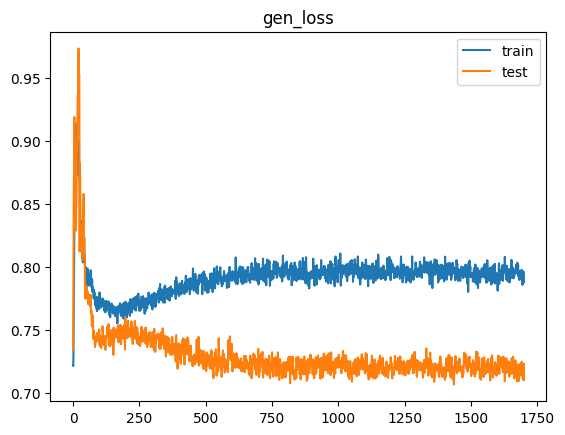

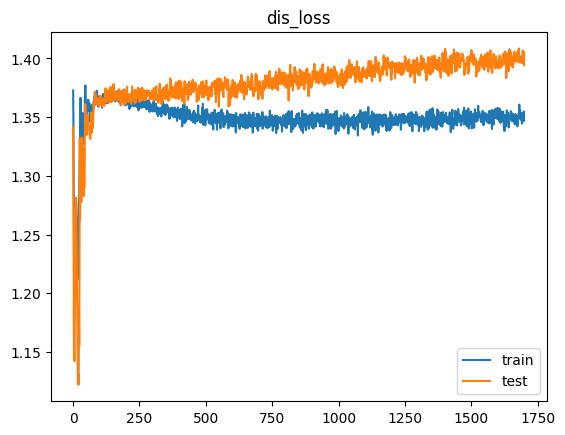

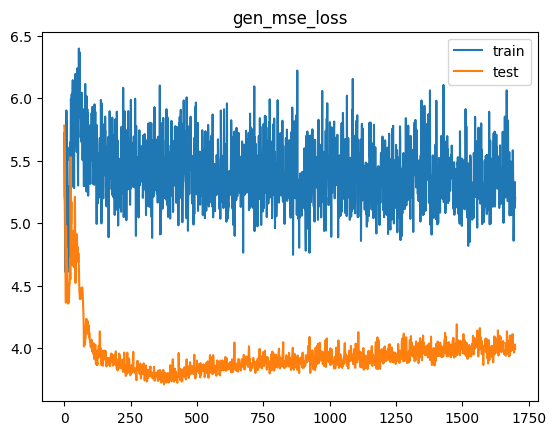

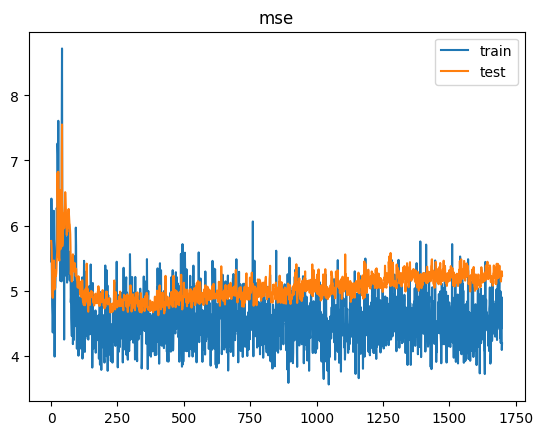

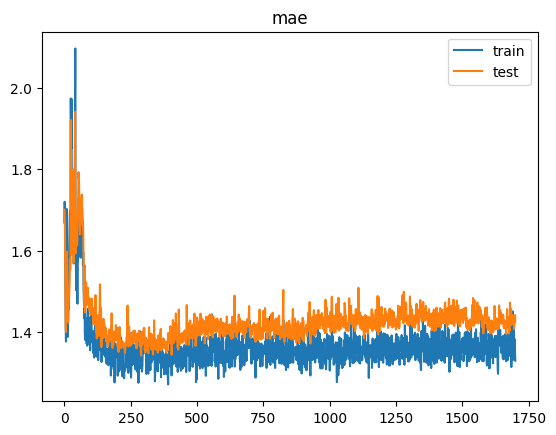

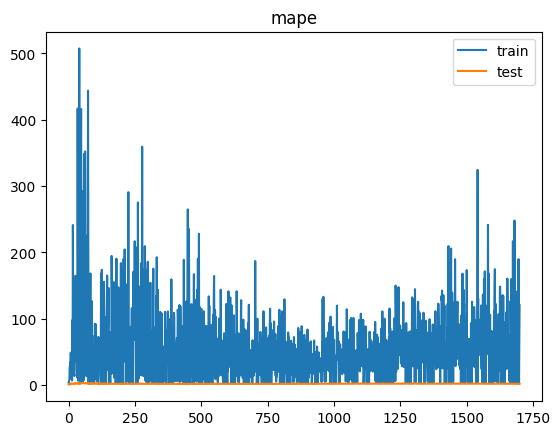

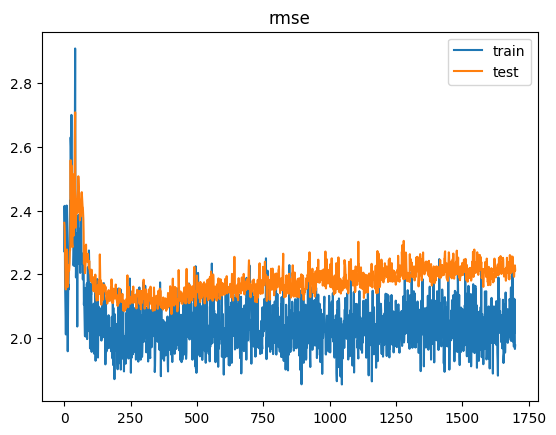

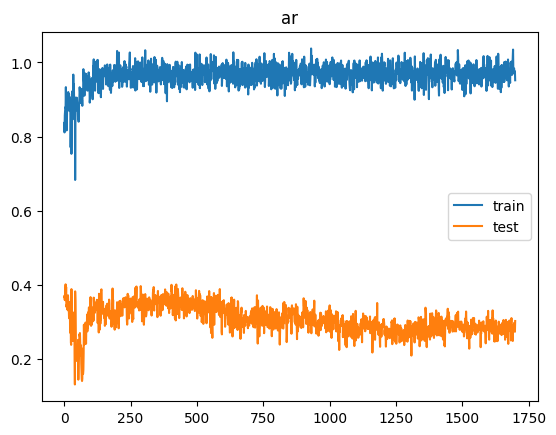

2/2 [==============================] - 1s 3ms/step


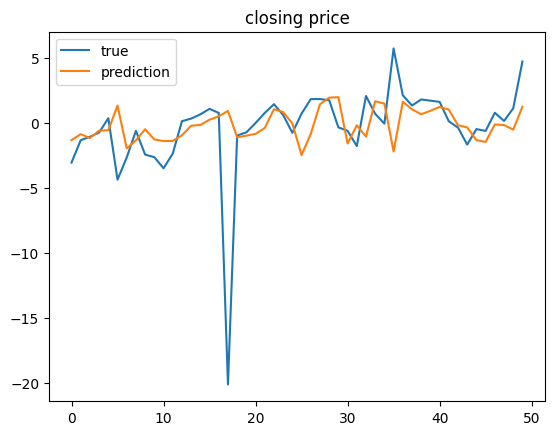

[MSE Baseline] train: 4.514986929029807  test: 4.695498675820508
Delta time with epochs = 1700: 0:29:57.878566
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_14 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.0090556144714355 sec Generator Loss: 0.8104907870292664,  Discriminator_loss: 1.3426281213760376
Time for epoch 52 is 1.0527262687683105 sec Generator Loss: 0.8092086911201477,  Discriminator_loss: 1.3434642553329468
Time for epoch 53 is 1.1013996601104736 sec Generator Loss: 0.7910605669021606,  Discriminator_loss: 1.3487142324447632
Time for epoch 54 is 1.3301422595977783 sec Generator Loss: 0.7877647876739502,  Discriminator_loss: 1.364676833152771
Time for epoch 55 is 1.1490333080291748 sec Generator Loss: 0.7729325890541077,  Discriminator_loss: 1.384426236152649
Time for epoch 56 is 1.2464334964752197 sec Generator Loss: 0.7789869904518127,  Discriminator_loss: 1.378865361213684
Time for epoch 57 is 1.1473419666290283 sec Generator Loss: 0.7915363311767578,  Discriminator_loss: 1.3638038635253906
Time for epoch 58 is 1.0297644138336182 sec Generator Loss: 0.7860428690910339,  Discriminator_loss: 1.3674068450927734
Time for epoch 59 is 1.0249559879302979 sec

Time for epoch 120 is 0.9897902011871338 sec Generator Loss: 0.771701991558075,  Discriminator_loss: 1.3710857629776
Time for epoch 121 is 1.047344446182251 sec Generator Loss: 0.7714240550994873,  Discriminator_loss: 1.3702893257141113
Time for epoch 122 is 0.9930713176727295 sec Generator Loss: 0.7709411978721619,  Discriminator_loss: 1.3633270263671875
Time for epoch 123 is 0.9936635494232178 sec Generator Loss: 0.7735341787338257,  Discriminator_loss: 1.3627994060516357
Time for epoch 124 is 1.062403678894043 sec Generator Loss: 0.7685189247131348,  Discriminator_loss: 1.3620797395706177
Time for epoch 125 is 1.015819787979126 sec Generator Loss: 0.7697975039482117,  Discriminator_loss: 1.3635694980621338
Time for epoch 126 is 0.9905245304107666 sec Generator Loss: 0.7756533622741699,  Discriminator_loss: 1.3635449409484863
Time for epoch 127 is 1.1574537754058838 sec Generator Loss: 0.763811469078064,  Discriminator_loss: 1.3691089153289795
Time for epoch 128 is 1.133718490600586 

Time for epoch 189 is 0.9970810413360596 sec Generator Loss: 0.7676352262496948,  Discriminator_loss: 1.3657557964324951
Time for epoch 190 is 0.981464147567749 sec Generator Loss: 0.7667705416679382,  Discriminator_loss: 1.3619117736816406
Time for epoch 191 is 0.9993093013763428 sec Generator Loss: 0.7612857818603516,  Discriminator_loss: 1.3705263137817383
Time for epoch 192 is 1.018899917602539 sec Generator Loss: 0.7678019404411316,  Discriminator_loss: 1.3651089668273926
Time for epoch 193 is 0.9983820915222168 sec Generator Loss: 0.7706157565116882,  Discriminator_loss: 1.363015055656433
Time for epoch 194 is 1.0833773612976074 sec Generator Loss: 0.777022123336792,  Discriminator_loss: 1.3622580766677856
Time for epoch 195 is 0.993192195892334 sec Generator Loss: 0.777552604675293,  Discriminator_loss: 1.3649792671203613
Time for epoch 196 is 0.981520414352417 sec Generator Loss: 0.7680865526199341,  Discriminator_loss: 1.3623244762420654
Time for epoch 197 is 1.019804239273071

Time for epoch 257 is 1.0058882236480713 sec Generator Loss: 0.7835121154785156,  Discriminator_loss: 1.3582006692886353
Time for epoch 258 is 0.9748952388763428 sec Generator Loss: 0.782133936882019,  Discriminator_loss: 1.3616293668746948
Time for epoch 259 is 0.9715573787689209 sec Generator Loss: 0.7785642147064209,  Discriminator_loss: 1.3661917448043823
Time for epoch 260 is 1.0201714038848877 sec Generator Loss: 0.7767367362976074,  Discriminator_loss: 1.3610814809799194
Time for epoch 261 is 0.9805808067321777 sec Generator Loss: 0.7845953702926636,  Discriminator_loss: 1.3572567701339722
Time for epoch 262 is 1.0104930400848389 sec Generator Loss: 0.7770813703536987,  Discriminator_loss: 1.3613823652267456
Time for epoch 263 is 0.9870038032531738 sec Generator Loss: 0.7794421315193176,  Discriminator_loss: 1.3610053062438965
Time for epoch 264 is 0.9811768531799316 sec Generator Loss: 0.7779987454414368,  Discriminator_loss: 1.3584650754928589
Time for epoch 265 is 1.048631429

Time for epoch 325 is 0.988318920135498 sec Generator Loss: 0.7719323039054871,  Discriminator_loss: 1.3615624904632568
Time for epoch 326 is 1.019618272781372 sec Generator Loss: 0.7807583808898926,  Discriminator_loss: 1.3528718948364258
Time for epoch 327 is 0.9746031761169434 sec Generator Loss: 0.7763722538948059,  Discriminator_loss: 1.3569775819778442
Time for epoch 328 is 0.9750993251800537 sec Generator Loss: 0.7724964618682861,  Discriminator_loss: 1.356397032737732
Time for epoch 329 is 1.0086414813995361 sec Generator Loss: 0.7733463644981384,  Discriminator_loss: 1.3593462705612183
Time for epoch 330 is 0.9757652282714844 sec Generator Loss: 0.7803608775138855,  Discriminator_loss: 1.3546150922775269
Time for epoch 331 is 0.9905352592468262 sec Generator Loss: 0.7799299955368042,  Discriminator_loss: 1.3574868440628052
Time for epoch 332 is 0.9909505844116211 sec Generator Loss: 0.7862390875816345,  Discriminator_loss: 1.348570466041565
Time for epoch 333 is 0.974973917007

Time for epoch 394 is 1.1548521518707275 sec Generator Loss: 0.7833654880523682,  Discriminator_loss: 1.3555092811584473
Time for epoch 395 is 1.2419486045837402 sec Generator Loss: 0.7841909527778625,  Discriminator_loss: 1.3541245460510254
Time for epoch 396 is 1.169457197189331 sec Generator Loss: 0.7931017279624939,  Discriminator_loss: 1.3490785360336304
Time for epoch 397 is 1.0637764930725098 sec Generator Loss: 0.7844349145889282,  Discriminator_loss: 1.3586868047714233
Time for epoch 398 is 1.0554590225219727 sec Generator Loss: 0.7865087389945984,  Discriminator_loss: 1.3527525663375854
Time for epoch 399 is 1.0012502670288086 sec Generator Loss: 0.7910280823707581,  Discriminator_loss: 1.3484125137329102
Time for epoch 400 is 1.0592424869537354 sec Generator Loss: 0.7873082756996155,  Discriminator_loss: 1.3537594079971313
Time for epoch 401 is 0.9735605716705322 sec Generator Loss: 0.7804698348045349,  Discriminator_loss: 1.3574888706207275
Time for epoch 402 is 1.198863744

Time for epoch 462 is 0.9790782928466797 sec Generator Loss: 0.8010700941085815,  Discriminator_loss: 1.3466790914535522
Time for epoch 463 is 0.9930081367492676 sec Generator Loss: 0.7951440215110779,  Discriminator_loss: 1.3530356884002686
Time for epoch 464 is 0.9813604354858398 sec Generator Loss: 0.7874041795730591,  Discriminator_loss: 1.350955843925476
Time for epoch 465 is 0.9839682579040527 sec Generator Loss: 0.790555477142334,  Discriminator_loss: 1.3507797718048096
Time for epoch 466 is 0.9809203147888184 sec Generator Loss: 0.7882470488548279,  Discriminator_loss: 1.3475399017333984
Time for epoch 467 is 0.9735970497131348 sec Generator Loss: 0.7862122654914856,  Discriminator_loss: 1.351287603378296
Time for epoch 468 is 0.9797296524047852 sec Generator Loss: 0.7815783619880676,  Discriminator_loss: 1.3540316820144653
Time for epoch 469 is 0.984154462814331 sec Generator Loss: 0.8033411502838135,  Discriminator_loss: 1.3442046642303467
Time for epoch 470 is 1.015885829925

Time for epoch 531 is 0.981522798538208 sec Generator Loss: 0.7962566614151001,  Discriminator_loss: 1.3405776023864746
Time for epoch 532 is 0.9871537685394287 sec Generator Loss: 0.7938030958175659,  Discriminator_loss: 1.3480256795883179
Time for epoch 533 is 0.9752795696258545 sec Generator Loss: 0.8025528788566589,  Discriminator_loss: 1.344419002532959
Time for epoch 534 is 0.9910135269165039 sec Generator Loss: 0.7885170578956604,  Discriminator_loss: 1.3522814512252808
Time for epoch 535 is 1.024430751800537 sec Generator Loss: 0.7977553009986877,  Discriminator_loss: 1.3414214849472046
Time for epoch 536 is 1.0590989589691162 sec Generator Loss: 0.7948140501976013,  Discriminator_loss: 1.3470014333724976
Time for epoch 537 is 1.195122480392456 sec Generator Loss: 0.7974017262458801,  Discriminator_loss: 1.342445969581604
Time for epoch 538 is 1.506385326385498 sec Generator Loss: 0.7932705879211426,  Discriminator_loss: 1.3542943000793457
Time for epoch 539 is 1.21274328231811

Time for epoch 600 is 0.9803760051727295 sec Generator Loss: 0.802791178226471,  Discriminator_loss: 1.3380446434020996
Time for epoch 601 is 0.9806365966796875 sec Generator Loss: 0.7972199320793152,  Discriminator_loss: 1.3449342250823975
Time for epoch 602 is 1.0642125606536865 sec Generator Loss: 0.7955068945884705,  Discriminator_loss: 1.3499118089675903
Time for epoch 603 is 0.9761514663696289 sec Generator Loss: 0.8063855767250061,  Discriminator_loss: 1.3404291868209839
Time for epoch 604 is 0.995887041091919 sec Generator Loss: 0.7990338206291199,  Discriminator_loss: 1.3452436923980713
Time for epoch 605 is 0.9741976261138916 sec Generator Loss: 0.7930163145065308,  Discriminator_loss: 1.3457289934158325
Time for epoch 606 is 0.9723079204559326 sec Generator Loss: 0.8076207041740417,  Discriminator_loss: 1.3403593301773071
Time for epoch 607 is 1.0072481632232666 sec Generator Loss: 0.7963610291481018,  Discriminator_loss: 1.346618890762329
Time for epoch 608 is 0.96373772621

Time for epoch 668 is 1.0005452632904053 sec Generator Loss: 0.8047820329666138,  Discriminator_loss: 1.3401906490325928
Time for epoch 669 is 0.991847038269043 sec Generator Loss: 0.7981414794921875,  Discriminator_loss: 1.3475842475891113
Time for epoch 670 is 0.9856002330780029 sec Generator Loss: 0.8006840348243713,  Discriminator_loss: 1.3441331386566162
Time for epoch 671 is 1.0133647918701172 sec Generator Loss: 0.793638288974762,  Discriminator_loss: 1.3463127613067627
Time for epoch 672 is 0.9855136871337891 sec Generator Loss: 0.8033507466316223,  Discriminator_loss: 1.3423726558685303
Time for epoch 673 is 1.0275263786315918 sec Generator Loss: 0.8033652305603027,  Discriminator_loss: 1.3434990644454956
Time for epoch 674 is 1.0185236930847168 sec Generator Loss: 0.806800365447998,  Discriminator_loss: 1.3390377759933472
Time for epoch 675 is 1.0062308311462402 sec Generator Loss: 0.807819128036499,  Discriminator_loss: 1.3411927223205566
Time for epoch 676 is 0.992403984069

Time for epoch 736 is 1.0460083484649658 sec Generator Loss: 0.7971947193145752,  Discriminator_loss: 1.353027582168579
Time for epoch 737 is 1.1093952655792236 sec Generator Loss: 0.7987955212593079,  Discriminator_loss: 1.3466993570327759
Time for epoch 738 is 1.0614829063415527 sec Generator Loss: 0.8055029511451721,  Discriminator_loss: 1.3397777080535889
Time for epoch 739 is 1.0352730751037598 sec Generator Loss: 0.8103744387626648,  Discriminator_loss: 1.3408550024032593
Time for epoch 740 is 1.0535922050476074 sec Generator Loss: 0.7996217012405396,  Discriminator_loss: 1.3453409671783447
Time for epoch 741 is 1.0384867191314697 sec Generator Loss: 0.8087127208709717,  Discriminator_loss: 1.3449686765670776
Time for epoch 742 is 1.1498782634735107 sec Generator Loss: 0.8048838376998901,  Discriminator_loss: 1.338873267173767
Time for epoch 743 is 1.07218337059021 sec Generator Loss: 0.8027282357215881,  Discriminator_loss: 1.3437466621398926
Time for epoch 744 is 1.037553071975

Time for epoch 804 is 1.2228727340698242 sec Generator Loss: 0.7912588119506836,  Discriminator_loss: 1.3527694940567017
Time for epoch 805 is 1.4606451988220215 sec Generator Loss: 0.8038580417633057,  Discriminator_loss: 1.342665433883667
Time for epoch 806 is 1.2955503463745117 sec Generator Loss: 0.7901301980018616,  Discriminator_loss: 1.3495672941207886
Time for epoch 807 is 1.1929140090942383 sec Generator Loss: 0.7929449677467346,  Discriminator_loss: 1.3500479459762573
Time for epoch 808 is 1.0943384170532227 sec Generator Loss: 0.7950266003608704,  Discriminator_loss: 1.3478831052780151
Time for epoch 809 is 1.041926383972168 sec Generator Loss: 0.795428991317749,  Discriminator_loss: 1.3491406440734863
Time for epoch 810 is 1.0812408924102783 sec Generator Loss: 0.7962451577186584,  Discriminator_loss: 1.345368504524231
Time for epoch 811 is 1.0531651973724365 sec Generator Loss: 0.7961768507957458,  Discriminator_loss: 1.3490440845489502
Time for epoch 812 is 1.135925292968

Time for epoch 873 is 1.214681625366211 sec Generator Loss: 0.7952638864517212,  Discriminator_loss: 1.3489619493484497
Time for epoch 874 is 1.2115471363067627 sec Generator Loss: 0.7984597682952881,  Discriminator_loss: 1.3424392938613892
Time for epoch 875 is 1.3258538246154785 sec Generator Loss: 0.8043916821479797,  Discriminator_loss: 1.3411272764205933
Time for epoch 876 is 1.2238802909851074 sec Generator Loss: 0.7883120179176331,  Discriminator_loss: 1.3571476936340332
Time for epoch 877 is 1.2830653190612793 sec Generator Loss: 0.787882387638092,  Discriminator_loss: 1.347786784172058
Time for epoch 878 is 1.1695597171783447 sec Generator Loss: 0.7930309176445007,  Discriminator_loss: 1.3475532531738281
Time for epoch 879 is 1.1606481075286865 sec Generator Loss: 0.7896029949188232,  Discriminator_loss: 1.3494733572006226
Time for epoch 880 is 1.193497657775879 sec Generator Loss: 0.8008929491043091,  Discriminator_loss: 1.3428616523742676
Time for epoch 881 is 1.197844505310

Time for epoch 942 is 1.0723164081573486 sec Generator Loss: 0.7930161952972412,  Discriminator_loss: 1.349555492401123
Time for epoch 943 is 1.0743408203125 sec Generator Loss: 0.7889896035194397,  Discriminator_loss: 1.354498028755188
Time for epoch 944 is 1.0755090713500977 sec Generator Loss: 0.8027950525283813,  Discriminator_loss: 1.3492928743362427
Time for epoch 945 is 1.0389196872711182 sec Generator Loss: 0.7991794347763062,  Discriminator_loss: 1.3438159227371216
Time for epoch 946 is 1.0458967685699463 sec Generator Loss: 0.7973645925521851,  Discriminator_loss: 1.3511006832122803
Time for epoch 947 is 1.2334895133972168 sec Generator Loss: 0.7910099625587463,  Discriminator_loss: 1.3487640619277954
Time for epoch 948 is 1.191593885421753 sec Generator Loss: 0.7873727083206177,  Discriminator_loss: 1.3529086112976074
Time for epoch 949 is 1.1100003719329834 sec Generator Loss: 0.7910551428794861,  Discriminator_loss: 1.3524636030197144
Time for epoch 950 is 1.06220984458923

Time for epoch 1010 is 1.0851521492004395 sec Generator Loss: 0.7975732088088989,  Discriminator_loss: 1.3470194339752197
Time for epoch 1011 is 1.0630173683166504 sec Generator Loss: 0.7910501956939697,  Discriminator_loss: 1.3574986457824707
Time for epoch 1012 is 1.0439884662628174 sec Generator Loss: 0.7876915335655212,  Discriminator_loss: 1.3483960628509521
Time for epoch 1013 is 1.0480246543884277 sec Generator Loss: 0.7891712188720703,  Discriminator_loss: 1.3502421379089355
Time for epoch 1014 is 1.081083059310913 sec Generator Loss: 0.7919883131980896,  Discriminator_loss: 1.3544987440109253
Time for epoch 1015 is 1.1080892086029053 sec Generator Loss: 0.7982892394065857,  Discriminator_loss: 1.348652958869934
Time for epoch 1016 is 1.035797119140625 sec Generator Loss: 0.7907080054283142,  Discriminator_loss: 1.3574188947677612
Time for epoch 1017 is 1.0474493503570557 sec Generator Loss: 0.7860136032104492,  Discriminator_loss: 1.3549708127975464
Time for epoch 1018 is 1.04

Time for epoch 1078 is 1.0436124801635742 sec Generator Loss: 0.7934565544128418,  Discriminator_loss: 1.3483076095581055
Time for epoch 1079 is 1.0444772243499756 sec Generator Loss: 0.7958232760429382,  Discriminator_loss: 1.3473539352416992
Time for epoch 1080 is 1.0555741786956787 sec Generator Loss: 0.7883764505386353,  Discriminator_loss: 1.3517804145812988
Time for epoch 1081 is 1.1244409084320068 sec Generator Loss: 0.7898371815681458,  Discriminator_loss: 1.3592826128005981
Time for epoch 1082 is 1.0925028324127197 sec Generator Loss: 0.8001990914344788,  Discriminator_loss: 1.349692702293396
Time for epoch 1083 is 1.0430817604064941 sec Generator Loss: 0.7969750165939331,  Discriminator_loss: 1.350799322128296
Time for epoch 1084 is 1.0333106517791748 sec Generator Loss: 0.8009564876556396,  Discriminator_loss: 1.3463749885559082
Time for epoch 1085 is 1.0462064743041992 sec Generator Loss: 0.7872344851493835,  Discriminator_loss: 1.3535749912261963
Time for epoch 1086 is 1.1

Time for epoch 1146 is 1.088592529296875 sec Generator Loss: 0.8011032938957214,  Discriminator_loss: 1.3425463438034058
Time for epoch 1147 is 1.032766580581665 sec Generator Loss: 0.7897698283195496,  Discriminator_loss: 1.3589979410171509
Time for epoch 1148 is 1.0621812343597412 sec Generator Loss: 0.7866510152816772,  Discriminator_loss: 1.3549753427505493
Time for epoch 1149 is 1.0453124046325684 sec Generator Loss: 0.7916741371154785,  Discriminator_loss: 1.354591965675354
Time for epoch 1150 is 1.034590482711792 sec Generator Loss: 0.7954899072647095,  Discriminator_loss: 1.3475855588912964
Time for epoch 1151 is 1.0669398307800293 sec Generator Loss: 0.7917695641517639,  Discriminator_loss: 1.3512639999389648
Time for epoch 1152 is 1.1706078052520752 sec Generator Loss: 0.796542763710022,  Discriminator_loss: 1.3472113609313965
Time for epoch 1153 is 1.2146477699279785 sec Generator Loss: 0.7908211946487427,  Discriminator_loss: 1.3590471744537354
Time for epoch 1154 is 1.1699

Time for epoch 1214 is 1.1521456241607666 sec Generator Loss: 0.7948437929153442,  Discriminator_loss: 1.3534355163574219
Time for epoch 1215 is 1.0638494491577148 sec Generator Loss: 0.7919042706489563,  Discriminator_loss: 1.3527387380599976
Time for epoch 1216 is 1.0744507312774658 sec Generator Loss: 0.7939212322235107,  Discriminator_loss: 1.3460417985916138
Time for epoch 1217 is 1.0722813606262207 sec Generator Loss: 0.7947394847869873,  Discriminator_loss: 1.3517602682113647
Time for epoch 1218 is 1.0667808055877686 sec Generator Loss: 0.7966846823692322,  Discriminator_loss: 1.3452088832855225
Time for epoch 1219 is 1.0703628063201904 sec Generator Loss: 0.7975389361381531,  Discriminator_loss: 1.3489142656326294
Time for epoch 1220 is 1.0577611923217773 sec Generator Loss: 0.7927842140197754,  Discriminator_loss: 1.3482130765914917
Time for epoch 1221 is 1.0744915008544922 sec Generator Loss: 0.8015353679656982,  Discriminator_loss: 1.3437420129776
Time for epoch 1222 is 1.04

Time for epoch 1282 is 1.0625932216644287 sec Generator Loss: 0.7933396697044373,  Discriminator_loss: 1.3533241748809814
Time for epoch 1283 is 1.0462615489959717 sec Generator Loss: 0.7929257154464722,  Discriminator_loss: 1.3497453927993774
Time for epoch 1284 is 1.0649218559265137 sec Generator Loss: 0.7979047298431396,  Discriminator_loss: 1.3472228050231934
Time for epoch 1285 is 1.040313482284546 sec Generator Loss: 0.8006949424743652,  Discriminator_loss: 1.3484545946121216
Time for epoch 1286 is 1.1997613906860352 sec Generator Loss: 0.790172815322876,  Discriminator_loss: 1.3526970148086548
Time for epoch 1287 is 1.2089753150939941 sec Generator Loss: 0.7891339063644409,  Discriminator_loss: 1.3549286127090454
Time for epoch 1288 is 1.0476748943328857 sec Generator Loss: 0.794655442237854,  Discriminator_loss: 1.3501235246658325
Time for epoch 1289 is 1.0437676906585693 sec Generator Loss: 0.7953957319259644,  Discriminator_loss: 1.349338412284851
Time for epoch 1290 is 1.057

Time for epoch 1350 is 1.035189151763916 sec Generator Loss: 0.8019241094589233,  Discriminator_loss: 1.347119688987732
Time for epoch 1351 is 1.3688371181488037 sec Generator Loss: 0.7957158088684082,  Discriminator_loss: 1.352359414100647
Time for epoch 1352 is 1.2834413051605225 sec Generator Loss: 0.7963565587997437,  Discriminator_loss: 1.3499295711517334
Time for epoch 1353 is 1.2090976238250732 sec Generator Loss: 0.7970397472381592,  Discriminator_loss: 1.346945881843567
Time for epoch 1354 is 1.1373865604400635 sec Generator Loss: 0.7956036329269409,  Discriminator_loss: 1.3560746908187866
Time for epoch 1355 is 1.1151189804077148 sec Generator Loss: 0.7901753187179565,  Discriminator_loss: 1.3516905307769775
Time for epoch 1356 is 1.146742343902588 sec Generator Loss: 0.8090181350708008,  Discriminator_loss: 1.3442720174789429
Time for epoch 1357 is 1.166170358657837 sec Generator Loss: 0.8009355068206787,  Discriminator_loss: 1.344663143157959
Time for epoch 1358 is 1.136311

Time for epoch 1418 is 1.065000057220459 sec Generator Loss: 0.7922215461730957,  Discriminator_loss: 1.3563086986541748
Time for epoch 1419 is 1.0834650993347168 sec Generator Loss: 0.7899414896965027,  Discriminator_loss: 1.3492541313171387
Time for epoch 1420 is 1.0944759845733643 sec Generator Loss: 0.795678973197937,  Discriminator_loss: 1.351194143295288
Time for epoch 1421 is 1.0521838665008545 sec Generator Loss: 0.7972580194473267,  Discriminator_loss: 1.3499985933303833
Time for epoch 1422 is 1.031433343887329 sec Generator Loss: 0.7900431752204895,  Discriminator_loss: 1.3530054092407227
Time for epoch 1423 is 1.0495104789733887 sec Generator Loss: 0.7982693314552307,  Discriminator_loss: 1.3463695049285889
Time for epoch 1424 is 1.0540072917938232 sec Generator Loss: 0.8020737767219543,  Discriminator_loss: 1.3484702110290527
Time for epoch 1425 is 1.0351755619049072 sec Generator Loss: 0.7920582294464111,  Discriminator_loss: 1.353471279144287
Time for epoch 1426 is 1.0554

Time for epoch 1486 is 1.106950283050537 sec Generator Loss: 0.7920284867286682,  Discriminator_loss: 1.3507035970687866
Time for epoch 1487 is 1.0578622817993164 sec Generator Loss: 0.8001392483711243,  Discriminator_loss: 1.3473608493804932
Time for epoch 1488 is 1.0719504356384277 sec Generator Loss: 0.7955746650695801,  Discriminator_loss: 1.3495876789093018
Time for epoch 1489 is 1.0391771793365479 sec Generator Loss: 0.7969442009925842,  Discriminator_loss: 1.3466910123825073
Time for epoch 1490 is 1.0342626571655273 sec Generator Loss: 0.7959919571876526,  Discriminator_loss: 1.3531376123428345
Time for epoch 1491 is 1.0382797718048096 sec Generator Loss: 0.7929661273956299,  Discriminator_loss: 1.347722053527832
Time for epoch 1492 is 1.0774312019348145 sec Generator Loss: 0.7910380363464355,  Discriminator_loss: 1.3530879020690918
Time for epoch 1493 is 1.1442837715148926 sec Generator Loss: 0.7849019169807434,  Discriminator_loss: 1.354299545288086
Time for epoch 1494 is 1.11

Time for epoch 1554 is 1.1671245098114014 sec Generator Loss: 0.7867448925971985,  Discriminator_loss: 1.3553577661514282
Time for epoch 1555 is 1.1076452732086182 sec Generator Loss: 0.7954522967338562,  Discriminator_loss: 1.3525938987731934
Time for epoch 1556 is 1.0950284004211426 sec Generator Loss: 0.7951212525367737,  Discriminator_loss: 1.345758080482483
Time for epoch 1557 is 1.0986709594726562 sec Generator Loss: 0.7947630286216736,  Discriminator_loss: 1.3492884635925293
Time for epoch 1558 is 1.0909953117370605 sec Generator Loss: 0.7955743074417114,  Discriminator_loss: 1.35043203830719
Time for epoch 1559 is 1.1558899879455566 sec Generator Loss: 0.7921381592750549,  Discriminator_loss: 1.3522863388061523
Time for epoch 1560 is 1.115844964981079 sec Generator Loss: 0.7986564040184021,  Discriminator_loss: 1.349234700202942
Time for epoch 1561 is 1.1436169147491455 sec Generator Loss: 0.7924200296401978,  Discriminator_loss: 1.3558868169784546
Time for epoch 1562 is 1.1079

Time for epoch 1622 is 1.0731725692749023 sec Generator Loss: 0.7967212200164795,  Discriminator_loss: 1.3458091020584106
Time for epoch 1623 is 1.0569846630096436 sec Generator Loss: 0.8018732070922852,  Discriminator_loss: 1.3526149988174438
Time for epoch 1624 is 1.054997205734253 sec Generator Loss: 0.7969923615455627,  Discriminator_loss: 1.3525716066360474
Time for epoch 1625 is 1.0900912284851074 sec Generator Loss: 0.785681426525116,  Discriminator_loss: 1.3513656854629517
Time for epoch 1626 is 1.068830966949463 sec Generator Loss: 0.7929934859275818,  Discriminator_loss: 1.3495043516159058
Time for epoch 1627 is 1.074371337890625 sec Generator Loss: 0.7901801466941833,  Discriminator_loss: 1.349083423614502
Time for epoch 1628 is 1.0552175045013428 sec Generator Loss: 0.7956521511077881,  Discriminator_loss: 1.350135326385498
Time for epoch 1629 is 1.0792663097381592 sec Generator Loss: 0.7959612607955933,  Discriminator_loss: 1.3513705730438232
Time for epoch 1630 is 1.08088

Time for epoch 1690 is 1.2152161598205566 sec Generator Loss: 0.7876197099685669,  Discriminator_loss: 1.3523281812667847
Time for epoch 1691 is 1.1403229236602783 sec Generator Loss: 0.7994198203086853,  Discriminator_loss: 1.3476990461349487
Time for epoch 1692 is 1.1778268814086914 sec Generator Loss: 0.7919108271598816,  Discriminator_loss: 1.3514108657836914
Time for epoch 1693 is 1.151045322418213 sec Generator Loss: 0.7972186207771301,  Discriminator_loss: 1.3431975841522217
Time for epoch 1694 is 1.089057207107544 sec Generator Loss: 0.7999880909919739,  Discriminator_loss: 1.3459800481796265
Time for epoch 1695 is 1.1745729446411133 sec Generator Loss: 0.7992606163024902,  Discriminator_loss: 1.3487083911895752
Time for epoch 1696 is 1.4249627590179443 sec Generator Loss: 0.7968251705169678,  Discriminator_loss: 1.3502130508422852
Time for epoch 1697 is 1.3684921264648438 sec Generator Loss: 0.8023592233657837,  Discriminator_loss: 1.3494888544082642
Time for epoch 1698 is 1.2

Time for epoch 1758 is 1.0842716693878174 sec Generator Loss: 0.8009637594223022,  Discriminator_loss: 1.350250482559204
Time for epoch 1759 is 1.2637255191802979 sec Generator Loss: 0.7999150156974792,  Discriminator_loss: 1.3475704193115234
Time for epoch 1760 is 1.1563827991485596 sec Generator Loss: 0.7900660037994385,  Discriminator_loss: 1.3557244539260864
Time for epoch 1761 is 1.0616650581359863 sec Generator Loss: 0.7885394096374512,  Discriminator_loss: 1.3529417514801025
Time for epoch 1762 is 1.0982906818389893 sec Generator Loss: 0.8026228547096252,  Discriminator_loss: 1.3483381271362305
Time for epoch 1763 is 1.0838971138000488 sec Generator Loss: 0.7992107272148132,  Discriminator_loss: 1.3503168821334839
Time for epoch 1764 is 1.2443923950195312 sec Generator Loss: 0.8012784123420715,  Discriminator_loss: 1.3466887474060059
Time for epoch 1765 is 1.1883823871612549 sec Generator Loss: 0.7901886105537415,  Discriminator_loss: 1.3544039726257324
Time for epoch 1766 is 1.

Time for epoch 1826 is 1.0921790599822998 sec Generator Loss: 0.809095561504364,  Discriminator_loss: 1.3469921350479126
Time for epoch 1827 is 1.0905210971832275 sec Generator Loss: 0.802146852016449,  Discriminator_loss: 1.3542317152023315
Time for epoch 1828 is 1.1832318305969238 sec Generator Loss: 0.7932741641998291,  Discriminator_loss: 1.3502967357635498
Time for epoch 1829 is 1.0896682739257812 sec Generator Loss: 0.7909096479415894,  Discriminator_loss: 1.356167197227478
Time for epoch 1830 is 1.0899150371551514 sec Generator Loss: 0.7960513234138489,  Discriminator_loss: 1.3491194248199463
Time for epoch 1831 is 1.0988869667053223 sec Generator Loss: 0.7986266613006592,  Discriminator_loss: 1.3488163948059082
Time for epoch 1832 is 1.0713887214660645 sec Generator Loss: 0.7963550686836243,  Discriminator_loss: 1.3480758666992188
Time for epoch 1833 is 1.0788252353668213 sec Generator Loss: 0.7925369739532471,  Discriminator_loss: 1.3499068021774292
Time for epoch 1834 is 1.07

Time for epoch 1894 is 1.3407623767852783 sec Generator Loss: 0.7922390103340149,  Discriminator_loss: 1.3499516248703003
Time for epoch 1895 is 1.096907138824463 sec Generator Loss: 0.7931698560714722,  Discriminator_loss: 1.346714973449707
Time for epoch 1896 is 1.0724513530731201 sec Generator Loss: 0.7941937446594238,  Discriminator_loss: 1.3526099920272827
Time for epoch 1897 is 1.062058448791504 sec Generator Loss: 0.7919811606407166,  Discriminator_loss: 1.353115439414978
Time for epoch 1898 is 1.1508703231811523 sec Generator Loss: 0.7865439057350159,  Discriminator_loss: 1.3546028137207031
Time for epoch 1899 is 1.1001348495483398 sec Generator Loss: 0.797842800617218,  Discriminator_loss: 1.3477920293807983
Time for epoch 1900 is 1.2510778903961182 sec Generator Loss: 0.7862318158149719,  Discriminator_loss: 1.353963851928711
Time for epoch 1901 is 1.2581312656402588 sec Generator Loss: 0.8044494986534119,  Discriminator_loss: 1.3471845388412476
Time for epoch 1902 is 1.09561

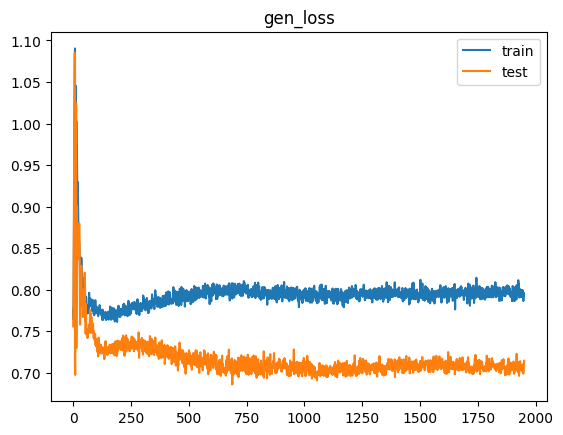

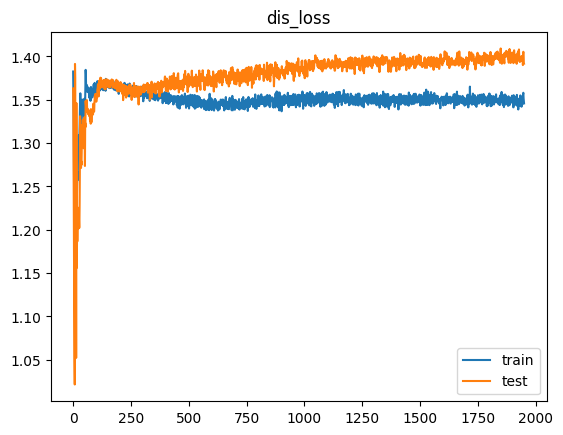

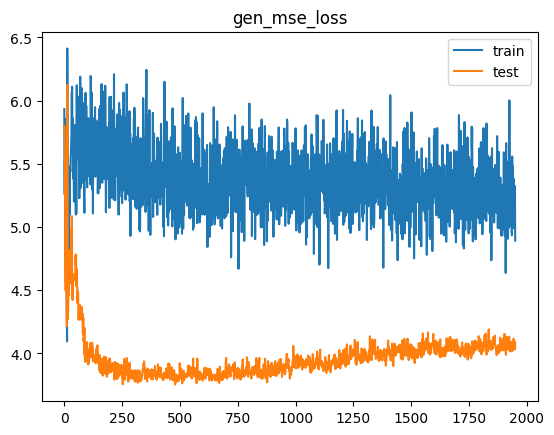

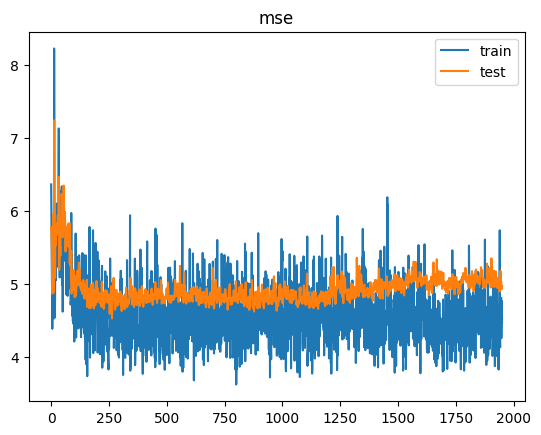

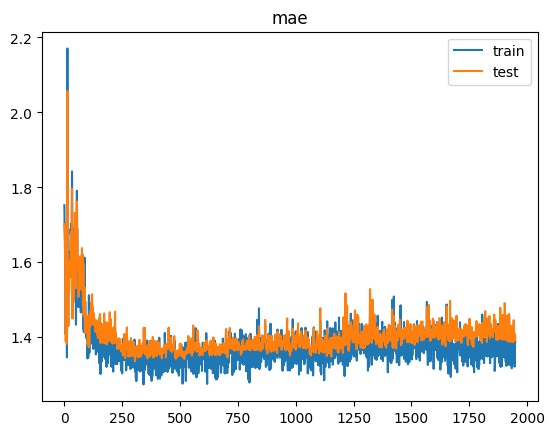

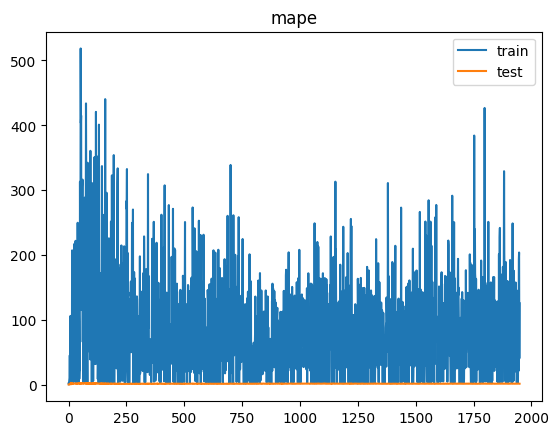

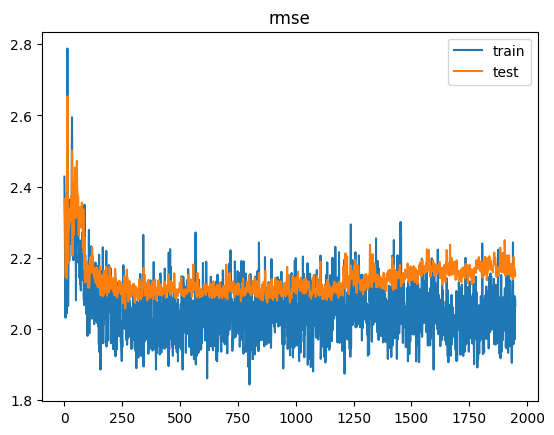

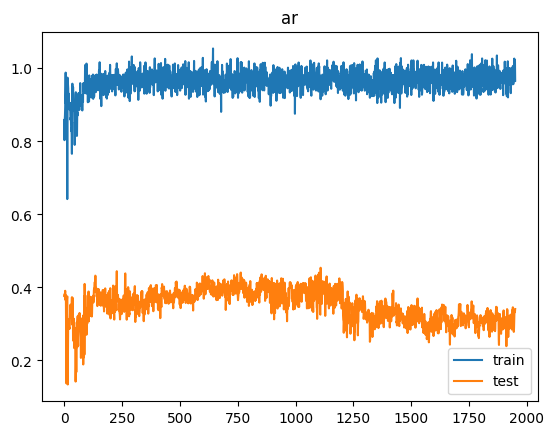

2/2 [==============================] - 1s 4ms/step


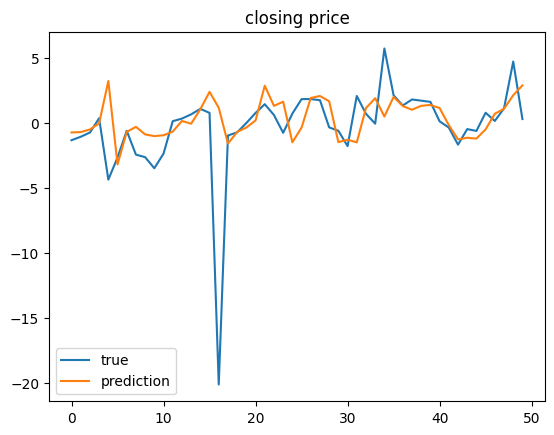

[MSE Baseline] train: 4.089578209957878  test: 4.711719681333692
Delta time with epochs = 1950: 0:35:19.349774


In [19]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))